# SELF SUPERVISED LEARNING

In [ ]:
%cd ~/Documents/TESI/TESI/notebooks
%load_ext autoreload
%autoreload 2

/home/zano/Documents/TESI/TESI/notebooks


/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
from utils.setup_functions import set_environment_flags
# Example usage:
environment_flags = set_environment_flags()
kaggle,gdrive,linux = environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"]
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment settings: {'gdrive': False, 'linux': True, 'kaggle': False, 'ssl': True}


In [ ]:
import os
import re
import tifffile
import glob
import random
import torch
import pytorch_lightning as pl
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from configs.ConfigLoader import ConfigLoader
from utils.train_functions import (
# train_epoch,
# val_epoch,
# print_model_summary,
# plot_cv_results,
# train_epoch_mixUp,
# print_layers,
# oversample_minority,
# undersample_majority,
# freeze_layers_up_to,
# freeze_layers_up_to_progressive_ft,
train_epoch_vit,
val_epoch_vit,
    )

from utils.test_functions import evaluate_model
from utils.data_visualization_functions import plot_confusion_matrix, show_misclassified_images, plot_roc_curve

import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
# import torch.nn.functional as F
# from monai.visualize.class_activation_maps import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False: ")
kaggle = False
if gdrive:
    import os

    # Change to the desired directory:
    os.chdir('/content/drive/MyDrive/TESI/TESI/notebooks')

    # Verify the current directory:
    print(os.getcwd())


2.6.0+cu124
1.4.0


In [4]:
# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

you are on linux
Linux detected, setting tracking URI
Final Tracking URI: /home/zano/Documents/TESI/mlruns
Does the directory exist? True


# UNIFIED DATA SELECTION

## DATA EXTRACTION

In [ ]:
from utils.directory_functions import get_data_directory, get_base_directory
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))

from utils.directory_functions import get_data_and_base_directory
data_dir, base_dir = get_data_and_base_directory(environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"], num_input_channels=num_input_channels)

3 channels input
you are in linux
/home/zano/Documents/TESI/3c_MIP_new
data dir: /home/zano/Documents/TESI/3c_MIP_new
base_dir: /home/zano/Documents/TESI/TESI


In [6]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

# DATA EXTRACTION

In [7]:
## Paths of ALL images into a numpy array without labels used for SSL
all_images_folder_path = os.path.join(data_dir, "ALL")
all_images_paths = glob.glob(os.path.join(all_images_folder_path, "*.tif"))
all_images_paths = np.array(all_images_paths)
print("Number of images in ALL folder:", len(all_images_paths))

Number of images in ALL folder: 152


{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
Class directories:
{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
MSA images (before filtering): 'gh' count: 83, 'vaso' count: 0
After removing 'vaso', MSA images: 'gh' count: 83, 'vaso' count: 0
PD images (before filtering): 'gh' count: 57, 'vaso' count: 0
After removing 'vaso', PD images: 'gh' count: 57, 'vaso' count: 0


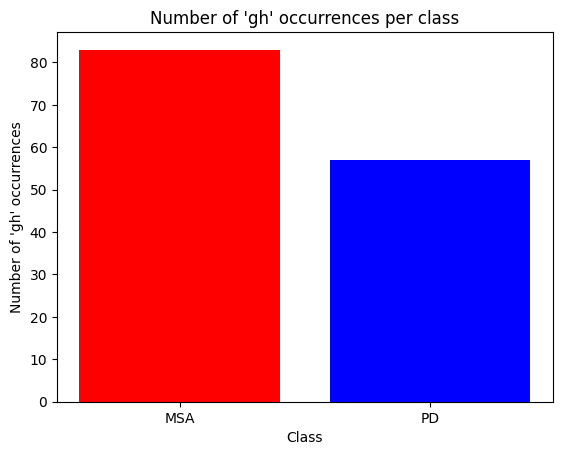


Checking image shapes:
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh2.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5463 gh.tif.tif  dt

In [8]:
# Create a dictionary mapping each class to its directory
class_dirs = {}
three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    image_paths = [path for path in image_paths if 'vaso' not in os.path.basename(path).lower()]
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
# random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts.keys(), key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

## TEST SET SPLIT

Original dataset size: 140
Original label distribution: {0: 83, 1: 57}

Aiming for a balanced test set with 57 samples per class.
Total balanced test set size will be: 114
Test set size: 114

Test set distribution: {0: 57, 1: 57}


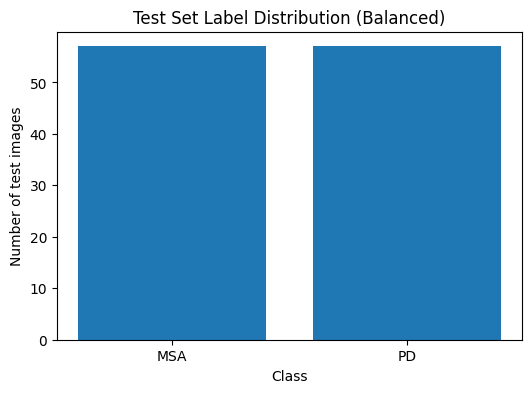


Test set counts and percentages:
MSA: 57 images (50.0% of test set)
PD: 57 images (50.0% of test set)


In [9]:
# --- Your Split Logic for 50/50 distribution in test set ---

print("Original dataset size:", len(images_paths_np))

# Find unique labels and their counts in the original dataset
unique_labels, counts = np.unique(labels_np, return_counts=True)
original_distribution = dict(zip(unique_labels, counts))
print(f"Original label distribution: {original_distribution}")

# Determine the maximum possible size for a balanced test set per class
# This is limited by the count of the smallest class
if len(unique_labels) > 1:
    min_class_count = min(counts)
    # We want a balanced test set, so take 'min_class_count' samples from each class
    test_samples_per_class = min_class_count
    total_balanced_test_size = test_samples_per_class * len(unique_labels)

    print(f"\nAiming for a balanced test set with {test_samples_per_class} samples per class.")
    print(f"Total balanced test set size will be: {total_balanced_test_size}")

    test_indices = []
    train_indices = []

    # Iterate through each class to split
    for label in unique_labels:
        # Get the indices in the original array that correspond to the current class
        # print ( labels_np == label) # returns a boolean array
        class_indices = np.where(labels_np == label)[0]  #use the boolean array to get the indices where cond is true 
        # print(f"\nClass {label} indices: {class_indices}") #retuns the indices of the class in the original array and the boolarray so we use [0] to get the indices

        # Randomly select a fixed number of indices for the test set from this class
        # Use np.random.choice with replace=False for sampling without replacement
        # Set a random_state for reproducibility if needed
        rng = np.random.default_rng(42) # Use new random generator recommended over np.random.seed
        test_class_indices = rng.choice(
            class_indices,
            size=test_samples_per_class,
            replace=False
        )
        test_indices.extend(test_class_indices)

    # Convert lists of indices to NumPy arrays
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)

    # Shuffle the indices to mix up the classes in the final arrays (optional but good practice)
    # rng.shuffle(test_indices)
    # rng.shuffle(train_indices)

    balanced_test_images_paths = images_paths_np[test_indices]
    balanced_test_true_labels = labels_np[test_indices]
    print(f"Test set size: {len(balanced_test_images_paths)}")

    # Verify the test set distribution
    test_unique_labels, test_counts = np.unique(balanced_test_true_labels, return_counts=True)
    test_distribution = dict(zip(test_unique_labels, test_counts))
    print(f"\nTest set distribution: {test_distribution}")


    plt.figure(figsize=(6, 4))
    # Use test_unique_labels and test_counts for the bar plot
    labels_for_plot = [class_names[label] if 'class_names' in locals() else f"Label {label}" for label in test_unique_labels]
    plt.bar(labels_for_plot, test_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of test images")
    plt.title("Test Set Label Distribution (Balanced)")
    plt.show()

    # Print counts and percentages for the balanced test set
    print("\nTest set counts and percentages:")
    for label, count in zip(test_unique_labels, test_counts):
         class_name = class_names[label] if 'class_names' in locals() else f"Label {label}"
         print(f"{class_name}: {count} images ({count/len(balanced_test_true_labels):.1%} of test set)")

else:
    print("Cannot perform a balanced split with less than two unique classes.")

119 training images
21 test images
<class 'numpy.ndarray'>


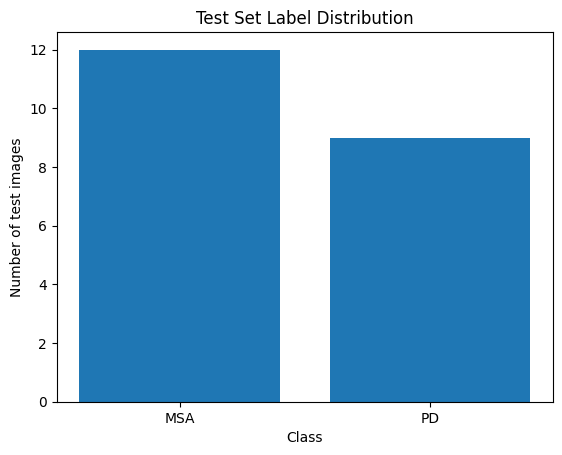

Label 0 (MSA): 12 images
Label 1 (PD): 9 images
Label 0 (MSA) is: 0.5714285714285714 
Label 1 (PD) is: 0.42857142857142855 


In [ ]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size= 0.15,
    stratify=labels,
    random_state=42,
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
# print("train images paths:", train_images_paths)
# print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
# print(test_images_paths)
print(type(train_images_paths))

unique_labels, counts = np.unique(test_true_labels_np, return_counts=True)


plt.bar([class_names[label] for label in unique_labels], counts)
plt.xlabel("Class")
plt.ylabel("Number of test images")
plt.title("Test Set Label Distribution")
plt.show()

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}): {count} images")

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}) is: {count/test_true_labels_np.shape[0]}")

In [11]:
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id)

display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str)

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first()

unique_pat_ids = patient_label_df["patient_id"].values  # need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

patient_label_df

image_path  label patient_id
0    /home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...      0       4092
1    /home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...      0       4092
2    /home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...      0       4121
3    /home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...      0       4121
4    /home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_5...      0       5358
..                                                 ...    ...        ...
135  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_74...      1       7461
136  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_75...      1       7544
137  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...      1       7677
138  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...      1       7688
139  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_77...      1       7710

[140 rows x 3 columns]

Unique patient IDs: ['4092' '4121' '5358' '5435' '5463' '5717' '5745' '5753' '5767' '5776'
 '5878' '5881' '5904' '5954' '5969' '5978' '5992' '5996' '6008' '6046'
 '6053' '6060' '6085' '6179' '6308' '6311' '6320' '6323' '6326' '6337'
 '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6459' '6485'
 '6491' '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6663' '6690'
 '6696' '6749' '6773' '6791' '7105' '7120' '7132' '7144' '7155' '7179'
 '7185' '7191' '7222' '7229' '7239' '7284' '7293' '7343' '7461' '7544'
 '7579' '7677' '7688' '7710']
Number of unique patients: 74
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1]


patient_id  label
0        4092      0
1        4121      0
2        5358      0
3        5435      0
4        5463      0
..        ...    ...
69       7544      1
70       7579      0
71       7677      1
72       7688      1
73       7710      1

[74 rows x 2 columns]

In [12]:
yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/densenet121.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
cfg.set_transfer_learning(False)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = None# "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet"
model_library = "torchvision" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

if model.__class__.__name__ == "ViT":
    print("Using ViT hence it requires custom training and validation functions")
    train_epoch = train_epoch_vit
    val_epoch = val_epoch_vit
    
        
def print_transform_names(compose):
    """
    Print the class names of the transformations inside a Compose object.

    Args:
        compose: A torchvision.transforms.Compose object.
    """
    for idx, transform in enumerate(compose.transforms):
        print(f"{idx + 1}. {transform.__class__.__name__}")

print_transform_names(train_transforms)

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

## TEST SET VISUALIZATIONS

In [ ]:
from utils.data_visualization_functions import visualize_tiff
# Example usage:
for i in range(len(balanced_test_images_paths)):
    print(f" Image{i} : {balanced_test_images_paths[i]}")
    visualize_tiff(balanced_test_images_paths[i])

In [ ]:
from utils.data_visualization_functions import display_images_by_class
# from utils.filtering_functions import filter_paths_by_imageIds, filter_paths_by_classIndex

# filtered_paths, filtered_labels = filter_paths_by_classIndex(images_paths_np, labels_np, 0)
# indexes_to_exclude = [4121, 5358, 5435, 5745, 5717, 5767,5753,5878,5776,5978,6179,6053]
# filtered_paths, filtered_labels = filter_paths_by_imageIds(filtered_paths, filtered_labels, indexes_to_exclude)
# filtered_paths_x, filtered_labels_x = filtered_paths[1], filtered_labels[1]
# visualize_tiff(filtered_paths_x,channel_wise_norm=True)
# Display filtered images
class_names = [class0_name,class1_name]
display_images_by_class(images_paths_np, labels_np, class_names, ncols=5, normalize=True)
# test_msa_ids = [7144,7120,7239,7293]
# test_dir = os.path.join(data_dir, "TEST")
# test_imagesx_paths = list(sorted(glob.glob(os.path.join(test_dir, "*.tif"))))
# print(f"class 0:{class0_name} class 1:{class1_name}")

# #nice result if i flip the labels dont know why
# truex_test_labels = [get_label(path,test_msa_ids,test_class0_ids) for path in test_imagesx_paths]
# truex_test_labels = np.array(truex_test_labels)
# display_images_by_class(test_imagesx_paths, truex_test_labels, class_names, ncols=5, normalize=True, channel_wise_norm=True)

# SELF-SUPERVISED LEARNING

## simCLR

With a limited labeled dataset, achieving great generalization scores is difficult. SimCLR is a Self-Supervised Learning (SSL) approach to learn meaningful features directly from unlabeled data by contrasting augmented image pairs, without requiring explicit disease labels initially.

The goals are:

*   Learn robust, biologically relevant embeddings from your microscopy images.
*   Reduce overfitting by leveraging subtle structural patterns in data.

The implementation consists of:

*   A SimCLR dataset returning augmented pairs.
*   Using MONAI's contrastive loss to minimize the similarity between negative samples and maximize the similarity between positive samples (cosine similarity).
*   Training a DenseNet121-based SimCLR model, clearly defined with a modular encoder and projection head (the projection head has been shown to increase performance in the original paper).

Once the model is trained to minimize the contrastive loss (i.e., push embeddings of different subjects apart and push closer the ones of the same):

*   Replace the projection head with a linear classifier.
*   Fine-tune this network (pre-trained encoder + linear classifier) with the labeled data.

Hopefully, fine-tuning leverages embeddings previously learned by SSL, improving classification performance compared to standard supervised training or pure ImageNet transfer learning since the images on which it's trained are very different.

Before starting the fine-tuning, visualizing extracted features (e.g., via t-SNE) is useful to understand if the decoders learned meaningful features (if clusters can be detected).


### Problems of SimClr
* requires large batches to have good results --> high vram needed
*   Sensitive to the choice of data augmentations.
*   Contrastive loss can be computationally expensive.
*   May not work well if the unlabeled data is very different from the labeled data.
*   The quality of learned representations depends heavily on the quality and diversity of the unlabeled data.


### LIGHTLY AND LIGHTNING IMPLEMENTATION VERSION

In [63]:
yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
cfg.set_transfer_learning(False)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = None #"imagenet" if transfer_learning else None # 'microscopynet' or "imagenet"
model_library = "torchvision" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [54]:
import time
import torchvision.transforms.v2 as T
from lightly.data import LightlyDataset
from lightly.data.collate import SimCLRCollateFunction
import pytorch_lightning as pl
from lightly.loss import NTXentLoss
import torch.nn as nn
from pytorch_lightning import Trainer
from lightly.transforms import SimCLRTransform
from lightly.models.modules import SimCLRProjectionHead
from utils.train_functions import LinearProbeHead 
# from lightly.models.modules import SimCLRProjectionHead
torch.set_float32_matmul_precision('high')  # or 'high' for better performance to enable tensor cores?
pl.seed_everything(42)
ssl_input_dir = f"/home/zano/Documents/TESI/{num_input_channels}c_MIP_new/CONTROL"
# encoder = DenseNet121(
#     spatial_dims=2,
#     in_channels=3,
#     out_channels=128,  # final feature dim for dense layers
#     pretrained=False
# )

# # 1) define the encoder
# encoder, device = ModelManager(cfg, library=model_library).setup_model(
#     num_classes=128,  # not used in SSL
#     # pretrained_weights="imagenet",
# )
# Ensure the model's output matches the number of classes
encoder, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
print(encoder)

print(f"encoder class: {encoder.__class__.__name__}")

class SimCLRModule(pl.LightningModule):
    def __init__(self, backbone, emb_dim=64, proj_hidden_dim=512, temperature=0.07, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = backbone
        self.temperature = temperature
        self.lr = lr
        
        ##STRIP ENCODER LINEAR PROBE HEAD
        backbone_outdim = self._get_projection_head_input_dim()
        # print(self.backbone)
        self._remove_linear_probe_head()
        
        self.projection_head = SimCLRProjectionHead(
            input_dim=backbone_outdim,
            hidden_dim=proj_hidden_dim,
            output_dim=emb_dim,
        )

        self.criterion = NTXentLoss(temperature=self.temperature)
    
    @property
    def encoder(self):
        return self.backbone
        
    def _remove_linear_probe_head(self):
        # if isinstance(self.backbone.fc, LinearProbeHead):
        # print(self.backbone.fc.__class__.__name__)
        if hasattr(self.backbone, "fc"):
            if self.backbone.fc.__class__.__name__ == "LinearProbeHead":
                self.backbone.fc = nn.Identity()
            
        elif hasattr(self.backbone, "classifier"):
            if self.backbone.classifier.__class__.__name__ == "LinearProbeHead":
                self.backbone.classifier = nn.Identity()
        else:
            raise RuntimeError(
                    "Could not remove linear probe head"
                )
    
    def _get_projection_head_input_dim(self):
        """
        Return the dimensionality of the **feature vector that comes right
        before the classifier** (the value you must feed into a projection
        or linear-probe head).
        
        """
        print(f"backbone: {self.backbone}")
        print(f"hasattr(self.backbone, 'fc'): {hasattr(self.backbone, 'fc')}")
        print(f"hasattr(self.backbone, 'classifier'): {hasattr(self.backbone, 'classifier')}")
        print(f"hasattr(self.backbone, 'in_features'): {hasattr(self.backbone.fc, 'in_features')}")
        
        if hasattr(self.backbone, "fc") and hasattr(self.backbone.fc, "in_dim"):
            print(f"backbone.fc.in_features: {self.backbone.fc.in_dim}")
            if self.backbone.fc.__class__.__name__ == "LinearProbeHead":
                return self.backbone.fc.in_dim
            # return self.backbone.fc.in_features
        elif hasattr(self.backbone, "classifier"):
            if self.backbone.classifier.__class__.__name__ == "LinearProbeHead":
                return self.backbone.classifier.in_dim
            
        print(f" backbone input dim: {self.backbone.in_dim}")
        return self.backbone.in_dim
        
    def forward(self, x):
        feats = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(feats)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1),_,_ = batch #x0,x1 are tensor of shape (B,C,H,W)
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # optim = torch.optim.SGD(self.parameters(), lr=self.lr) 
        optim = torch.optim.Adam(self.parameters(), lr=self.lr,weight_decay=1e-6)
        return optim
    

Seed set to 42


Using Torchvision for model instantiation.
pretrained_weights? None pretrained? False
Building torchvision ResNet18...
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [55]:
from lightly.transforms.simclr_transform import SimCLRTransform

STABLE_BACKBONE_PATH = f"simclr_encoder_weights_{num_input_channels}c_{encoder.__class__.__name__}.pth"
# 3) Create the SimCLR transform
transform = SimCLRTransform(
    input_size=256,
    gaussian_blur=0.5,  # probability of applying blur
    random_gray_scale = 0.2,  # probability of grayscale
    cj_strength=0.4, # color jitter strength
    vf_prob=0.5,
    hf_prob=0.5,
    rr_prob=0.5,
    rr_degrees=180,
)


dataset = LightlyDataset(
    input_dir=ssl_input_dir,
    transform=transform
)

# collate_fn = SimCLRCollateFunction(input_size=256)
print("len of dataset")
print(len(dataset)) 

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = len(dataset),
    shuffle=True,
    # collate_fn=collate_fn,
    drop_last=True,
    num_workers=2
)

# 4) Create the module & trainer
model = SimCLRModule(
    backbone=encoder,
    emb_dim=128,
    proj_hidden_dim=512,
    temperature=0.07,
    lr=3e-4
)

trainer = pl.Trainer(
    max_epochs= 120,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=True,
    log_every_n_steps=1
)

start_time = time.time()
# 5) Fit
trainer.fit(model=model, train_dataloaders=loader)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")
# 6) Save weights
STABLE_BACKBONE_PATH = f"simclr_encoder_weights_{num_input_channels}c_{encoder.__class__.__name__}.pth"

torch.save(
    model.backbone.state_dict(),
    STABLE_BACKBONE_PATH
)

print(f"Saved encoder weights to {STABLE_BACKBONE_PATH}")

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | backbone        | ResNet               | 11.2 M | train
1 | projection_head | SimCLRProjectionHead | 328 K  | train
2 | criterion       | NTXentLoss           | 0      | train
-----------------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


len of dataset
19
backbone: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

Training: |          | 0/? [00:00<?, ?it/s]

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 19. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=120` reached.


Training completed in 78.33 seconds.
Saved encoder weights to simclr_encoder_weights_3c_ResNet.pth


In [64]:
import copy
# 7) Reload the backbone
encoder_type = "simclr"
simclr_encoder = copy.deepcopy(model.backbone) # Extract the encoder part not taking into consideration the projection head
# 3) Load your pre-trained SSL weights
state_dict = torch.load(STABLE_BACKBONE_PATH, map_location=device)
simclr_encoder.load_state_dict(state_dict)
simclr_encoder = simclr_encoder.to(device)
# 8) Use encoder for downstream tasks
# small test to see the encoder output dimension
from utils.train_functions import remove_projection_head
import copy
# 4) (Optional) Quick check of encoder output dim
encoder = copy.deepcopy(simclr_encoder).eval()  # Set the encoder to evaluation mode
print(cfg.get_image_shape())
with torch.no_grad():
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    encoder_out = simclr_encoder(test_input).flatten(start_dim=1)
    model_without_projection = remove_projection_head(copy.deepcopy(simclr_encoder))  # Set the encoder to evaluation mode
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    feats = model_without_projection(test_input).flatten(start_dim=1)
print(f"Detected encoder output dimension: {encoder_out.shape[1]}")
print(f"Detected encoder output dimension once removed classification head: {feats.shape[1]}")

print(simclr_encoder)
# encoder.train()  # Set the encoder back to training mode
# load the model weights

(256, 256)
Removed fc from encoder.
Detected encoder output dimension: 512
Detected encoder output dimension once removed classification head: 512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
#LOAD WITH RANDOMLY INITIALIZED BACKBONE TO TEST IF SSL IS WORKING
simclr_encoder, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
encoder_type = "NOSSL"

def _remove_linear_probe_head(backbone):
        # if isinstance(self.backbone.fc, LinearProbeHead):
        # print(self.backbone.fc.__class__.__name__)
        if hasattr(backbone, "fc"):
            if  backbone.fc.__class__.__name__ == "LinearProbeHead":
                print("removing linear probe head")
                backbone.fc = nn.Identity()
            
        elif hasattr(backbone, "classifier"):
            if backbone.classifier.__class__.__name__ == "LinearProbeHead":
                backbone.classifier = nn.Identity()
        else:
            raise RuntimeError(
                    "Could not remove linear probe head"
                )
_remove_linear_probe_head(simclr_encoder)
print(simclr_encoder)

Using Torchvision for model instantiation.
pretrained_weights? None pretrained? False
Building torchvision ResNet18...
removing linear probe head
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

### TRAINING LOOP

In [ ]:
import copy
from utils.data_visualization_functions import generate_cv_results_figure
from utils.train_functions import  SSLClassifierModule

FREEZE_ENCODER = True  
bool_list = [True, False] 
for FREEZE_ENCODER in bool_list:
    def model_factory(lr: float)-> torch.nn.Module:
        """
        Model‐factory that instantiates a fresh SSLClassifierModule
        with the given learning rate.
        """
        fresh_encoder = copy.deepcopy(simclr_encoder)
        return SSLClassifierModule(
            encoder=fresh_encoder,     # capture this from your outer scope
            num_classes=2,
            freeze_encoder=FREEZE_ENCODER,
            lr=lr,
            backbone_output_dim=feats.shape[1],
            # input_shape=(1,3,256,256),  # Adjust as needed (B, C, H, W)
        )
        

    from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
    # cfg.set_freezed_layer_index(None)
    experiment = NestedCVStratifiedByPatient(
        df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
        pretrained_weights = pretrained_weights,
        class_names = class_names, model_factory=model_factory, num_folds=6
    )
    # cfg.set_freezed_layer_index(None)
    # hold_out_cv = True
    using_cosine_scheduler = False

    per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


    from utils.mlflow_functions import log_SSL_run_to_mlflow
    def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
        """
        Get the index of the best fold based on a specified metric.

        Args:
            outer_fold_test_results (list of dict): List containing test results for 
                each outer fold. Each element should be a dictionary with metrics 
                as keys.
            metric (str): The metric name to use for selecting the best fold. 
                Default is "test_balanced_acc".

        Returns:
            int: The index of the fold with the highest value for the specified metric.

        Example:
            best_idx = get_best_fold_idx(results, metric="test_f1")
        """

        print(outer_fold_test_results)
        best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
        # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
        best_fold_result = outer_fold_test_results[best_fold_idx]
        print(f"Best {metric} Fold Result: {best_fold_result}")
        fold_idx = best_fold_result["fold"]
        return fold_idx

    #loading the best model for the metric selected, it's then used for computing gradcams during logging
    best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
    model_instance_for_logging, _ = experiment._get_model_and_device()
    model_instance_for_logging.eval()
    try:
        model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
    except FileNotFoundError:
        raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
    except Exception as e:
        raise Exception(f"Error loading model weights: {str(e)}")

    # Now, call the logging function:
    train_transforms, val_transforms,_ = experiment.get_current_fold_transforms()
    # Now, call the logging function:
      # or "moco" if using MoCo
    log_SSL_run_to_mlflow(
        environmentFlags=environment_flags,
        cfg=cfg,
        model=model_factory(0.001),  # Pass a dummy model to log the run
        class_names=class_names,
        fold_results=outer_fold_test_results,
        per_fold_metrics=per_fold_training_metrics,
        hold_out_cv=True,
        test_transforms=val_transforms,
        all_images_paths_np=images_paths_np,
        all_labels_np=labels_np,
        test_images_paths_np=test_images_paths_np,
        test_true_labels_np=test_true_labels_np,
        yaml_path=yaml_path,
        color_transforms=color_transforms,
        model_library=model_library,
        encoder_type= encoder_type,
        pretrained_backbone_path = STABLE_BACKBONE_PATH,
        train_transforms=train_transforms,
        # val_transforms=val_transforms,
        freeze_encoder=FREEZE_ENCODER,
        ssl=True,
    )

In [ ]:
fold_6_val_image_paths = experiment.get_val_image_paths_per_fold(6)
print(fold_6_val_image_paths)

from utils.data_visualization_functions import visualize_tiff
# Example usage:
for i in range(len(fold_6_val_image_paths)):
    print(f" Image{i} : {fold_6_val_image_paths[i]}")
    visualize_tiff(fold_6_val_image_paths[i])

## BYOL & SIMSIAM

BYOL (Bootstrap Your Own Latent) is another Self-Supervised Learning (SSL) approach that aims to learn meaningful representations from unlabeled data. Unlike SimCLR, BYOL does not require negative samples, which simplifies the training process and reduces the need for large batch sizes.

The goals of BYOL are:
* Learn robust and meaningful embeddings from microscopy images.
* Improve generalization by leveraging structural patterns in the data.

The implementation consists of:
* A BYOL dataset returning augmented pairs.
* Using a target network and an online network to learn representations by minimizing the difference between their outputs.
* Training a ResNet-based BYOL model with a predictor network to improve performance.

Once the model is trained:
* The target network is discarded.
* The online network is fine-tuned with labeled data using a linear classifier.

BYOL improves upon SimCLR in several ways:
* It does not require negative samples, reducing the need for large batch sizes.
* It is less sensitive to the choice of data augmentations.
* It can achieve competitive performance with smaller batch sizes and less computational resources.

### Problems of BYOL
* Still computationally expensive, though less so than SimCLR.
* The quality of learned representations depends on the quality and diversity of the unlabeled data.
* May not work well if the unlabeled data is very different from the labeled data.

Note: the Online network is also called student while the target is called teacher

![alt text](image.png)

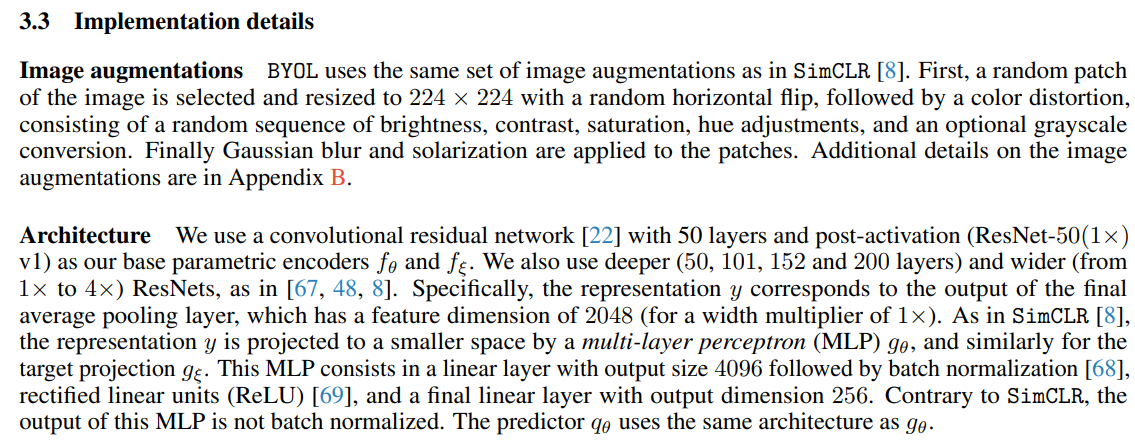

Training Loop in a Nutshell
1. Augment your Image Twice

    For each sample x, create two augmented versions: x1 and x2.
2. Forward Pass

    Student sees x1 → outputs z1 (encoder + projector), then p1 (predictor).
    
    Teacher sees x2 → outputs z2 (encoder + projector).
3. Loss Function

    - BYOL aims to match p1 with z2 (stop-gradient on the teacher side).
    - Symmetry: Then do the reverse pass (Teacher sees x1, Student sees x2) and combine losses.
    - Final loss is a mean squared error between normalized p1 and z2, plus the symmetrical term.

4. Update Student Weights

    - Standard backprop on the Student network.

5. Momentum Update

    - Update the Teacher’s weights with the exponential moving average.
6. Repeat for all images in the dataset.

    - Typically we do many epochs to learn stable representations.

* implement SIMCLR, BYOL, MOCO, BIG SSL MODEL
* Evaluate resulted features via K-NN, K-mean, Linear classifier

<span style="font-size: 1.5em;">**DOWNSTREAM CLASSIFICATION**</span>

After you’ve done BYOL pretraining for some epochs:

1. Freeze the BYOL encoder (i.e., model.online_encoder).
2. Add a classifier head for PD vs. MSA.
3. Train that classifier with your limited labeled data.

In [ ]:
## TODO try Patch-based training for BYOL. Extract multiple patches from each 2D MIP to effectively increase your dataset size.
## TODO Using pretrained 2D ResNet weights as a starting point, then apply BYOL (or SSL more in general).
## TODO choosing the right augmentations

### USING THE REPO BYOL (https://github.com/lucidrains/byol-pytorch)

In [ ]:
%pip install byol-pytorch kornia

In [ ]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "torchvision" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

In [13]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL+MSA-C")
else:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL")
    
ssl_images_paths = glob.glob(os.path.join(ssl_images_folder_path, "*.tif"))
ssl_images_paths_np = np.array(ssl_images_paths)
print("Number of images in ALL folder:", len(ssl_images_paths))

['MSA', 'PD']
Number of images in ALL folder: 19


In [14]:
from monai.data import PatchDataset
from monai.transforms import (
        LoadImage, EnsureChannelFirst, ScaleIntensity,
        RandSpatialCropSamples, RandFlip, RandRotate90, Compose
)

from classes.CustomTiffFileReader import CustomTiffFileReader
# -----------------------------------------------------------
# a) image‑level MONAI dataset (each item is a filepath)
# -----------------------------------------------------------

dataset_ssl = [{'img': p} for p in ssl_images_paths]          # MONAI style dicts to make monai dict transform works

img_level_tf = Compose([
        CustomTiffFileReader(keys=["image"]),
        EnsureChannelFirst(),  #optional
        Resized(keys=["image"], spatial_size=(512,512)), 
            # CenterSpatialCropd(keys="image", roi_size=(224,224)),
        ScaleIntensityd(keys="image"),  # Scale to [0.0, 1.0]
        EnsureTyped(keys=["image", "label"], data_type="tensor", dtype=torch.float32),
])

# -----------------------------------------------------------
# b) patch sampler  –  K random 256×256 crops per image
# -----------------------------------------------------------
n_patches = 8
roi_size = (256, 256)         

sampler = RandSpatialCropSamples(          # returns list of patches
        roi_size      = roi_size,
        num_samples   = n_patches,
        random_center = True,
        random_size   = False,
)
# -----------------------------------------------------------
# c) patch‑level augmentations (colour, flips, etc.)
# Only executed **after** the crop.
# -----------------------------------------------------------
patch_tf = Compose([
        RandFlipd(keys="image", spatial_axis=0, prob=0.5),   # horiz
        RandFlipd(keys="image", spatial_axis=1, prob=0.5),   # vert
        RandRotate90d(keys="image", prob=0.5, max_k=3),
])
# -----------------------------------------------------------
# d) build MONAI PatchDataset
# -----------------------------------------------------------
# img_paths  = images_paths_np.tolist()
# img_ds     = [{'image': p} for p in img_paths]  
print(f"img_ds: {dataset_ssl}") 

patch_ds = PatchDataset(
        data              = dataset_ssl,
        patch_func        = lambda d: sampler(d["image"]), # PatchDataset expects *sequence* of patches
        samples_per_image = n_patches,
        transform         = patch_tf
)
# print(patch_ds)

img_ds: [{'img': '/home/zano/Documents/TESI/3c_MIP_new/CONTROL/MAX_6731.lif - 6731 DL VIP r Sinapto gr TH b 63x z2 gh 2 pinhole 1 z 05.tif'}, {'img': '/home/zano/Documents/TESI/3c_MIP_new/CONTROL/MAX_5168.lif - 5168 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 3.tif'}, {'img': '/home/zano/Documents/TESI/3c_MIP_new/CONTROL/MAX_5167.lif - 5167 DL VIP red Sinapto gr TH b D grey 63x z2 pinhole 1 z 05 gh.tif'}, {'img': '/home/zano/Documents/TESI/3c_MIP_new/CONTROL/MAX_5199.lif - 5199 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'}, {'img': '/home/zano/Documents/TESI/3c_MIP_new/CONTROL/MAX_6743.lif - 6743 DL VIP r Sinapto gr TH b 63x z2 gh 2 pinhole 1 z 05.tif'}, {'img': '/home/zano/Documents/TESI/3c_MIP_new/CONTROL/MAX_5197.lif - 5197 gh DL VIP r TH b Sinapto gr 63x z2 pinhole 06 z 022.tif'}, {'img': '/home/zano/Documents/TESI/3c_MIP_new/CONTROL/MAX_5167.lif - 5167 DL VIP red Sinapto gr TH b D grey 63x z2 pinhole 1 z 05 gh2.tif'}, {'img': '/home/zano/Documen

Original image tensor shape #15: torch.Size([3, 512, 512])


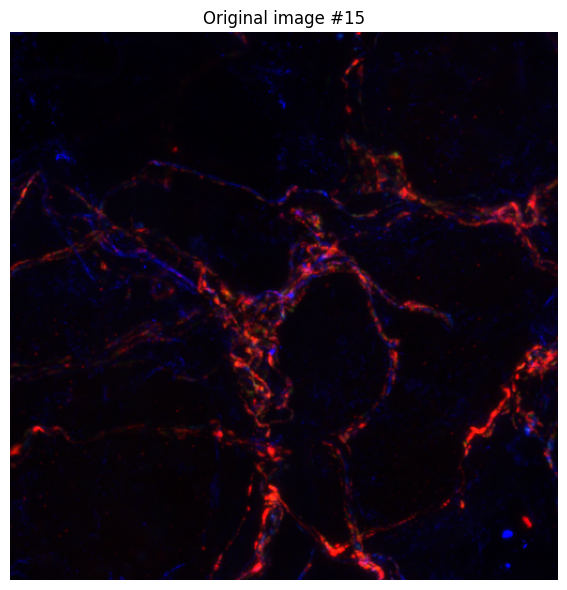

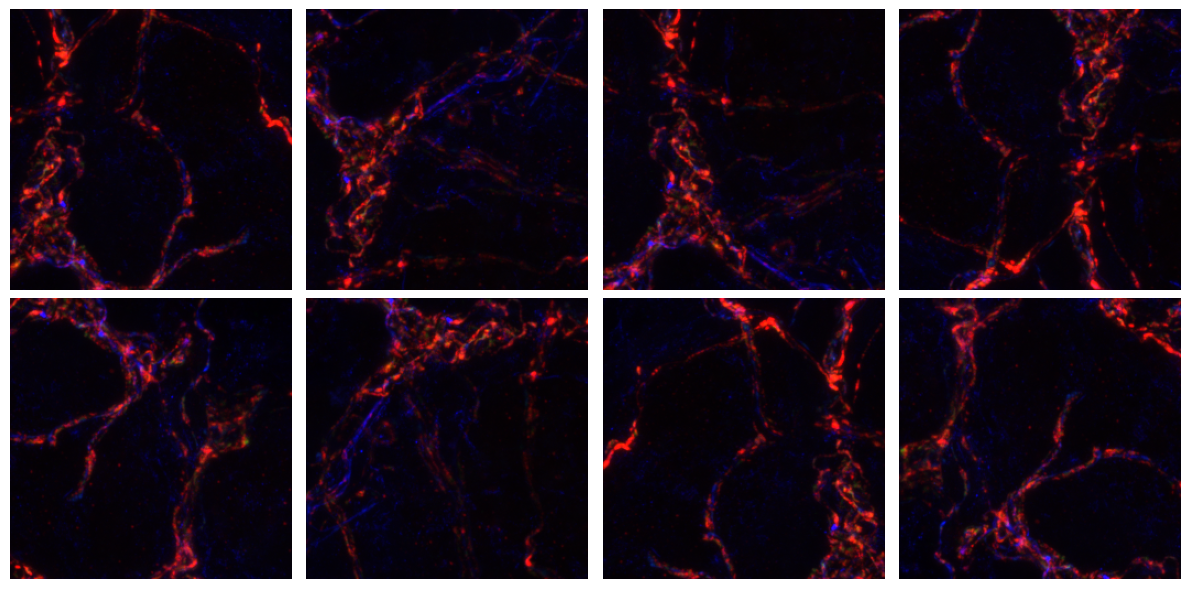

In [15]:
from monai.transforms import (
    Compose,
    # EnsureChannelFirstd,
    Resized,
    ScaleIntensityd,
    RandFlip,                    # pure flip
    RandRotate90,                # pure 90° rotation
)

from monai.transforms.croppad.array import RandSpatialCropSamples  # pure sampler
from monai.data.grid_dataset import PatchDataset
import matplotlib.pyplot as plt
import torch, itertools, math, numpy as np

# ------------------------------------------------------------------
# a) 1‑per‑image dicts with a path under key "image"
# ------------------------------------------------------------------

dataset_ssl = [{"image": p} for p in ssl_images_paths]

# ------------------------------------------------------------------
# b) image‑level transforms  (path  →  dict with Tensor under "image")
# ------------------------------------------------------------------
from utils.transformations_functions import from_GBR_to_RGB

img_tf = Compose([
    CustomTiffFileReader(keys=["image"]), # loads the image from the path as a numpy array (C,H,W) in GBR format
    EnsureTyped(keys=["image"], data_type="tensor", dtype=torch.float32), # Ensure image is a tensor
    LambdaD(keys="image", func=from_GBR_to_RGB),
    # EnsureChannelFirstd(keys="image"),
    Resized(keys="image", spatial_size=(512, 512)),
    ScaleIntensityd(keys="image"),
])

# ------------------------------------------------------------------
# c) patch sampler : 8 random 256×256 crops — pure (non‑dict) version
# ------------------------------------------------------------------
sampler = RandSpatialCropSamples(
    roi_size=(256, 256),
    num_samples=8,
    random_center=True,
    random_size=False,
)

# ------------------------------------------------------------------
# d) patch‑level augments
# ------------------------------------------------------------------
    
patch_tf = Compose([
    # RandChannelShift(max_shift=15, prob=0.70),
    RandFlip(spatial_axis=0, prob=0.5),  
    RandFlip(spatial_axis=1, prob=0.5),
    RandRotate90(max_k=3, prob=0.5),
])

# ------------------------------------------------------------------
# e) PatchDataset – extract the Tensor, sample, then augment
# ------------------------------------------------------------------
patch_ds = PatchDataset(
    data=dataset_ssl,                                             # use named arg `data`
    # dataset=img_ds,                                             # use named arg `dataset`
    samples_per_image=8,                                        # produces 8 patches per image
    patch_func=lambda d: sampler(img_tf(d)["image"]),           # <-- pull out d["image"]
    transform=patch_tf,                                         # augment each pure Tensor
)

# ------------------------------------------------------------------
# helper to visualise the 8 patches from image `img_idx`
# ------------------------------------------------------------------
def show_patches(
    ds,
    img_idx: int = 0,
    n_patches: int = 8,
    show_original: bool = False
):
    """
    Display random cropped patches (and optionally the original image)
    for the image at index `img_idx` in a PatchDataset.

    Parameters
    ----------
    ds : monai.data.PatchDataset
        A PatchDataset yielding Tensor patches (C, H, W).
    img_idx : int, optional
        Zero-based index of which source image to pull patches from.
        Default is 0.
    n_patches : int, optional
        How many patches were sampled per image (so for slicing the iterator).
        Default is 8.
    show_original : bool, optional
        If True, will display the full pre‑processed image before the patches.
        Default is False.

    Raises
    ------
    ValueError
        If `img_idx` is out of range (i.e. no patches found).
    """
    # -- optionally show the original full‐image (after img_tf) --
    if show_original:
        # pull the same dict you used to build patch_ds
        d = dataset_ssl[img_idx] # get the img_idx element of the list of dictionaries ie  {"image": path_idx}
        # print(d) #{ "image": "path"}
        image_tensor = img_tf(d)["image"]           # apply the image-level transforms to the image ternsor ie d["image"] ie load the tensor associated to that path
        print(f"Original image tensor shape #{img_idx}: {image_tensor.shape}") # Print the shape of the tensor
        # visualize_tiff(img_ds[img_idx]["image"]) # Use your custom function to visualize the TIFF image
        # print(f"Original image shape #{img_idx}: {d["image"].shape}")
        img = image_tensor.cpu().numpy().transpose(1, 2, 0)  # H×W×C to plot
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Original image #{img_idx}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # -- now grab the n_patches for that image index --
    start = img_idx * n_patches
    end   = start + n_patches
    stream = itertools.islice(iter(ds), start, end) # iterator of Tensors
    patches = [p.cpu() for p in stream] # list of Tensors

    if not patches:
        raise ValueError(f"img_idx {img_idx} out of range (no patches)")

    # -- plot the patches in a grid --
    n_cols = 4
    n_rows = math.ceil(n_patches / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(3 * n_cols, 3 * n_rows))
    for ax, patch in zip(axes.flat, patches):
        img = patch.numpy().transpose(1, 2, 0)  # H×W×C
        ax.imshow(img)
        ax.axis("off")

    # blank out any leftover axes
    for ax in axes.flat[len(patches):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    # show original + patches from the 3rd image
show_patches(patch_ds, img_idx=15, n_patches=8, show_original=True)

In [ ]:
from monai.data import Dataset, DataLoader
from classes.PrintShapeTransform import PrintShapeTransform
from classes.CustomTiffFileReader import CustomTiffFileReader

base_transforms = train_transforms

# ### LOADER FOR PATCHES
# train_loader_patch_ds = DataLoader(
#     patch_ds,
#     batch_size=16,
#     num_workers=2,        # try increasing this
#     pin_memory=True,      # important when using GPU
# )
# Wrap your patch_ds with a custom collate function that returns dictionaries
def dict_collate_fn(batch):
    return {"image": torch.stack(batch, 0)}
import ipywidgets as widgets
from IPython.display import display

# Create the patch-based DataLoader
train_loader_patch_ds = DataLoader(
    patch_ds,
    batch_size=16,
    num_workers=2,
    pin_memory=True,
    collate_fn=dict_collate_fn
)

# Create the full-image DataLoader
from utils.train_functions import make_unlabeled_loader
train_loader_full_ds = make_unlabeled_loader(
    image_paths=ssl_images_paths_np,
    transforms=base_transforms,
    cfg=cfg,
    shuffle=True,
)

# Dictionary to map dropdown options to loaders
loader_options = {
    "Patch DataLoader": train_loader_patch_ds,
    "Full Image DataLoader": train_loader_full_ds,
}

# Dropdown widget for loader selection
loader_dropdown = widgets.Dropdown(
    options=list(loader_options.keys()),
    value="Patch DataLoader",
    description="Train Loader:",
    style={'description_width': 'initial'},
)

# Variable to hold the selected loader
train_loader = loader_options[loader_dropdown.value]

def on_loader_change(change):
    """
    Callback to update the train_loader variable when the dropdown changes.
    """
    global train_loader
    train_loader = loader_options[change['new']]
    print(f"train_loader set to: {change['new']} ({type(train_loader)})")

# Attach the callback to the dropdown
loader_dropdown.observe(on_loader_change, names='value')

display(loader_dropdown)
print(f"Initial train_loader: {loader_dropdown.value} ({type(train_loader)})")

print(type(train_loader))

import kornia.augmentation as K
import kornia.filters as KF

_final_resize = K.Resize(size=(256, 256))

# ──────────────────────────────
# View 1 — “global crop”
# ──────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Common safeguard: always finish at 256 × 256
_final_resize = K.Resize(size=(256, 256), antialias=True)

# ──────────────────────────────
# View 1 — “global crop”
# ──────────────────────────────
augment_fn = nn.Sequential(
    # Multi-scale global crop (55–100 % area)
    K.RandomResizedCrop(
        size=(256, 256), scale=(0.55, 1.0), ratio=(1.0, 1.0), p=1.0
    ),

    # Geometric invariances
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    K.RandomRotation(degrees=180.0, resample="bilinear", p=0.5),

    # # Mild tissue-like deformation
    # K.RandomElasticTransform(
    #     kernel_size=(75, 75),      # coarser grid → smoother field
    #     sigma=(9.0, 13.0),         # keep σ ≈ kernel_size / 8
    #     alpha=(2.0, 4.0),          # 2-4 px average displacement
    #     p=0.20,
    #     align_corners=False,
    #     padding_mode="border",
    # ),

    # Image-formation perturbations
    K.RandomGaussianBlur(kernel_size=(5, 5), sigma=(0.2, 1.2), p=0.50),
    # K.RandomPoissonNoise(lam=(4.0, 12.0), p=0.40),
    K.RandomGaussianNoise(mean=0.0, std=0.015, p=0.40),

    # Intensity jitter (per-channel invariance)
    K.ColorJiggle(brightness=(0.8, 1.2), contrast=(0.8, 1.2), p=0.40),
    # K.RandomGamma(gamma=(0.8, 1.2), p=0.30),

    # Channel robustness
    K.RandomChannelDropout(num_drop_channels=1, p=0.20),
    # Occlusion regularisation  
    K.RandomErasing(
        scale=(0.02, 0.08),
        ratio=(0.3, 3.3),
        same_on_batch=False,
        # value="random",  # coloured blocks instead of black
        p=0.15,
    ),
    

    _final_resize,  # ensure 256 × 256 output
).to(device)

# ──────────────────────────────
# View 2 — “local crop + deformation”
# ──────────────────────────────
augment_fn2 = nn.Sequential(
    # Tighter crop (35–60 % area)
    K.RandomResizedCrop(
        size=(256, 256), scale=(0.35, 0.60), ratio=(1.0, 1.0), p=1.0
    ),

    # Mild illumination & contrast jitter before geometry
    K.ColorJiggle(brightness=(0.85, 1.15), contrast=(0.85, 1.15), p=0.50),

    # Geometric invariances
    K.RandomAffine(
        degrees=0.0,
        translate=(0.05, 0.05),
        scale=(0.90, 1.10),
        shear=(3.0, 3.0),
        padding_mode="border",
        p=0.50,
    ),
    
    # K.RandomElasticTransform(
    #     kernel_size=(75, 75),      # coarser grid → smoother field
    #     sigma=(9.0, 13.0),         # keep σ ≈ kernel_size / 8
    #     alpha=(2.0, 4.0),          # 2-4 px average displacement
    #     p=0.20,
    #     align_corners=False,
    #     padding_mode="border",
    # ),

    # Focus & noise perturbations
    K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0), p=0.50),
    # K.RandomPoissonNoise(lam=(4.0, 12.0), p=0.40),
    K.RandomGaussianNoise(mean=0.0, std=0.020, p=0.60),

    # Channel robustness
    K.RandomChannelDropout(num_drop_channels=1, p=0.30),

    # Occlusion regularisation
    K.RandomErasing(
        scale=(0.03, 0.10),
        ratio=(0.3, 3.3),
        same_on_batch=False,
        # value="random",
        p=0.20,
    ),

    _final_resize,
).to(device)

Dropdown(description='Train Loader:', options=('Patch DataLoader', 'Full Image DataLoader'), style=Description…

Initial train_loader: Patch DataLoader (<class 'monai.data.dataloader.DataLoader'>)
<class 'monai.data.dataloader.DataLoader'>


In [91]:
%load_ext autoreload
%autoreload 2
%ls -a

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
./
../
546527502349762475/
activations_overlays_all/
barlow_backbone.pth
barlow_backbone_stable_pytorch_sched.pth
best_model_final.pth
best_model_fold_1.pth
best_model_fold_2.pth
best_model_fold_3.pth
best_model_fold_4.pth
best_model_fold_5.pth
best_model_fold_6.pth
best_model.pth
byol_pretrained_resnet_best.pth
BYOL_pretrained_resnet_noPatches.pth
BYOL_pretrained_resnet_noPatches_withLotsOfAugmentations.pth
byol_pretrained_resnet_noRandomChannelShuffle.pth
byol_pretrained_resnet.pth
BYOL_Resnet18_pretrained.pth
BYOL_Resnet18_pretrained_resnet_noPatches.pth
BYOL_Resnet18_pretrained_resnet_Patches.pth
classes/
CNN_classifier.ipynb
configs/
confusion_matrices/
.github/
image.png
ImagePreProcessing.ipynb
.ipynb_checkpoints/
jupyter_server.ipynb
learning_curves/
lightning_logs/
mae_backbone.pth
mlflow.log
mlruns/
moco_backbone1.pth
moco_backbone_es.pth
models/
output/
requirements2.txt
simclr_encoder_we

In [ ]:
from utils.ssl.byol_transformation_functions import get_byol_transforms_nd

augment_fn, augment_fn2 = get_byol_transforms_nd(cfg, normalize_intensity=False)
# Print the Compose object to see its structure
print(augment_fn)

# If augment_fn is a torchvision or kornia Compose, its transforms are usually stored in .transforms
if hasattr(augment_fn, 'transforms'):
    print("Transforms inside Compose:")
    for t in augment_fn.transforms:
        print(t)
else:
    print("This Compose object does not have a 'transforms' attribute. Check its documentation or type:")
    print(type(augment_fn))


ImportError: cannot import name 'get_byol_transforms_nd' from 'utils.ssl.byol_transformation_functions' (/home/zano/Documents/TESI/TESI/utils/ssl/byol_transformation_functions.py)

In [55]:
import torch
import matplotlib.pyplot as plt
from typing import Union, Sequence

import torch, itertools, math
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
from typing import Union, Sequence

def _nth_from_iterable(ds: IterableDataset, n: int):
    """Return the n-th element of an IterableDataset."""
    return next(itertools.islice(ds, n, None))

@torch.no_grad()
def viz_augmented_views(
    sample: Union[int, torch.Tensor, Sequence[torch.Tensor]],
    augment_fn,
    augment_fn2,
    dataset=None,
    device="cuda" if torch.cuda.is_available() else "cpu",
    show_batch: bool = False,
):
    """
    Visualise a patch (or batch) alongside its BYOL augmentations.

    Parameters
    ----------
    sample : int | Tensor | sequence[Tensor]
        - int  : fetches the n-th element from `dataset`
        - Tensor : a single (C,H,W) tensor
        - sequence[Tensor] : a batch
    dataset : Dataset or IterableDataset, optional
        Required if `sample` is int.
    """
    # 1️⃣ get the tensor(s) -------------------------------------------------
    if isinstance(sample, int):
        if dataset is None:
            raise ValueError("Need `dataset` when sample is an int index.")
        if hasattr(dataset, "__getitem__") and not isinstance(dataset, IterableDataset):
            tensor = dataset[sample]
        else:  # IterableDataset path
            tensor = _nth_from_iterable(dataset, sample)
        # If the dataset returns a dict, extract the image tensor
        if isinstance(tensor, dict) and "image" in tensor:
            tensor = tensor["image"]
    else:
        tensor = sample

     # ---------- make batch ----------
    if isinstance(tensor, torch.Tensor):
        if tensor.ndim == 3:            # single patch
            batch = tensor.unsqueeze(0)
        elif tensor.ndim == 4:          # already a batch
            batch = tensor
        else:
            raise ValueError(f"Tensor rank {tensor.ndim} not supported.")
    else:                               # sequence of tensors
        batch = torch.stack(tensor, dim=0)

    view1 = augment_fn(batch)
    view2 = augment_fn2(batch)
    
    print(f"View 1 Range: {view1.min().item()} to {view1.max().item()}")
    print(f"View 2 Range: {view2.min().item()} to {view2.max().item()}")

    batch, view1, view2 = [x.cpu() for x in (batch, view1, view2)]

    # 3️⃣ plot --------------------------------------------------------------
    B = batch.size(0)
    n_rows = B if show_batch else 1
    fig, axes = plt.subplots(n_rows, 3, figsize=(9, 3 * n_rows), squeeze=False)
    titles = ["original", "augment_fn", "augment_fn2"]

    for r in range(n_rows):
        imgs = [batch[r], view1[r], view2[r]]
        for c, img in enumerate(imgs):
            ax = axes[r, c]
            np_img = img.numpy().transpose(1, 2, 0)
            ax.imshow(np_img)
            if r == 0:
                ax.set_title(titles[c])
            ax.axis("off")

    plt.tight_layout()
    plt.show()

viz_augmented_views(0, augment_fn, augment_fn2, dataset=patch_ds)
# batch = next(iter(train_loader))  # shape (B,C,H,W)
# viz_augmented_views(batch, augment_fn, augment_fn2, show_batch=True)

RuntimeError: applying transform <monai.transforms.spatial.dictionary.Resized object at 0x77dbe1f308c0>

To fetch the embeddings or the projections, you simply have to pass in a return_embeddings = True flag to the BYOL learner instance


```python
resnet = models.resnet50(pretrained=True)

learner = BYOL(
    resnet,
    image_size = 256,
    hidden_layer = 'avgpool'
)

imgs = torch.randn(2, 3, 256, 256)
projection, embedding = learner(imgs, return_embedding = True)
```

or

```python

# 1) Load your BYOL-pretrained ResNet
model = models.resnet50(pretrained=False)
model.load_state_dict(torch.load('byol_pretrained_resnet.pth'))

# 2) (Optional) Remove the final FC if you want raw 2048-d features
model.fc = nn.Identity()

model = model.to('cuda')
model.eval()

# 3) Pass images through for embeddings
with torch.no_grad():
    embeddings = model(your_images_tensor)  # shape: (B, 2048) if you removed fc
    ```

In [18]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "torchvision" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [36]:
from byol_pytorch import BYOL
from torchvision import models
import time
# resnet = models.resnet50(weights = None)  # or pretrained=True if you like
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

#usage Simply plugin your neural network, specifying 
# (1) the image dimensions
# (2) the name (or index) of the hidden layer, 
# whose output is used as the latent representati
# this library will use the augmentations from the SimCLR paper (which is also used in the BYOL paper).
# learner = BYOL(
#     resnet,
#     image_size = 256,          # the height & width of your input images
#     augment_fn = custom_augment_fn,
#     augment_fn2 = custom_augment_fn,  # or define a second pipeline if desired
#     hidden_layer = 'avgpool',  # output layer used for representation
#     # projection_size = 256,     # defaults to 256
#     # projection_hidden_size = 4096,
#     # moving_average_decay = 0.99
# )

simsiam = True

if not simsiam:
    print("BYOL")
    learner = BYOL(
        net=model,
        image_size=256,           # must match your input size
        hidden_layer='avgpool',   # layer to extract embeddings from in ResNet
        augment_fn=augment_fn,   # our custom random transforms
        augment_fn2=augment_fn2,  # can define a second if you want different augmentations
        projection_size=256,
        projection_hidden_size=4096,
        moving_average_decay=0.99
    )
else:
    print("SimSiam")
    learner = BYOL(
        net=model,
        image_size=256,  # must match your input size
        hidden_layer=-2, #or "avgpool"   # layer to extract embeddings from in ResNet
        augment_fn=augment_fn,   # our custom random transforms
        augment_fn2=augment_fn2,  # can define a second if you want different augmentations
        # projection_size=256,
        # projection_hidden_size=4096,
        # moving_average_decay=0.99
        use_momentum=False, # This is the main difference from byol
    ) 

device = "cuda" if torch.cuda.is_available() else "cpu"
learner = learner.to(device)
optimizer = optim.Adam(learner.parameters(), lr=1e-4)
scaler = torch.GradScaler("cuda")  # for mixed precision training

start_time = time.time()
#Encoder Pre-training loop
patience          = 25          
best_train_loss   = float("inf")
epochs_no_improve = 0
best_state_dict   = None

num_epochs = 120
for epoch in range(1, num_epochs + 1):
    learner.train()
    total_loss = 0.0
    for batch in train_loader:
        imgs = batch["image"].to(device)

        with torch.autocast(device_type=device, dtype=torch.float16):
            loss = learner(imgs)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(learner.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        if not simsiam:
            learner.update_moving_average()

        total_loss += loss.item() * imgs.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch:3d} | train loss {train_loss:.4f}")

    # ---------- early-stopping on training loss ----------
    if train_loss < best_train_loss - 1e-6:     # 1e-6 = small min_delta
        best_train_loss   = train_loss
        epochs_no_improve = 0
        best_state_dict   = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n⏹️  Stopping: train loss hasn’t improved for {patience} epochs.")
            break

# restore best weights (optional but typical)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

encoder_type = "BYOL" if not simsiam else "SimSiam"
# model = resnet
# model_class_name = model.__class__.__name__
# print(f"Model class name: {model_class_name}")
# print(cfg.get_model_name())

pretrained_backbone_name = f"{encoder_type}_{cfg.get_model_name()}_pretrained"
STABLE_BACKBONE_PATH = pretrained_backbone_name + ".pth"
torch.save(model.state_dict(), STABLE_BACKBONE_PATH)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
SimSiam


RuntimeError: applying transform <classes.CustomTiffFileReader.CustomTiffFileReader object at 0x77dc04b6e090>

### LOADING PRE-TRAINED ENCODER

In [21]:
import copy
# 7) Reload the pretrained backbone
encoder_type = "byol"
byol_encoder = copy.deepcopy(model) # Extract the encoder part not taking into consideration the projection head
# 3) Load your pre-trained SSL weights
state_dict = torch.load(STABLE_BACKBONE_PATH, map_location=device)
byol_encoder.load_state_dict(state_dict)
byol_encoder = byol_encoder.to(device)
# 8) Use encoder for downstream tasks
# small test to see the encoder output dimension
from utils.train_functions import remove_projection_head
import copy
# 4) (Optional) Quick check of encoder output dim
encoder = copy.deepcopy(byol_encoder).eval()  # Set the encoder to evaluation mode
print(cfg.get_image_shape())
with torch.no_grad():
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    encoder_out = byol_encoder(test_input).flatten(start_dim=1)
    model_without_projection = remove_projection_head(copy.deepcopy(byol_encoder))  # Set the encoder to evaluation mode
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    feats = model_without_projection(test_input).flatten(start_dim=1)
print(f"Detected encoder output dimension: {encoder_out.shape[1]}")
print(f"Detected encoder output dimension once removed classification head: {feats.shape[1]}")

(256, 256)
Removed fc from encoder.
Detected encoder output dimension: 2
Detected encoder output dimension once removed classification head: 512


### LOADING RANDOM INITIALIZED ENCODER

In [ ]:
from utils.reproducibility_functions import set_global_seed

# Set seed for reproducibility
set_global_seed(42)

In [29]:
from utils.reproducibility_functions import models_equal_hash
byol_encoder_notPretrained, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
byol_encoder_notPretrained2, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
are_equally_initialized = models_equal_hash(byol_encoder_notPretrained, byol_encoder_notPretrained2)
print(f"Are the two encoders equally initialized? {are_equally_initialized}")

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Are the two encoders equally initialized? True


In [22]:
#LOAD WITH RANDOMLY INITIALIZED BACKBONE TO TEST IF SSL IS WORKING
byol_encoder_notPretrained, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
encoder_type = "NOSSL"

def _remove_linear_probe_head(backbone):
        # if isinstance(self.backbone.fc, LinearProbeHead):
        # print(self.backbone.fc.__class__.__name__)
        if hasattr(backbone, "fc"):
            if  backbone.fc.__class__.__name__ == "LinearProbeHead":
                print("removing linear probe head")
                backbone.fc = nn.Identity()
            
        elif hasattr(backbone, "classifier"):
            if backbone.classifier.__class__.__name__ == "LinearProbeHead":
                backbone.classifier = nn.Identity()
        else:
            raise RuntimeError(
                    "Could not remove linear probe head"
                )
            
_remove_linear_probe_head(byol_encoder_notPretrained)
print(byol_encoder_notPretrained)

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
removing linear probe head
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

### DOWNSTREAM CLASSIFICATION

- Create a new ResNet with the same architecture (4-channel mod if needed).
- Load the improved weights into it.
- Replace the final layer with a custom classification head.
- Train/Fine-tune on your labeled data (50 PD, 50 MSA).

Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 115 | Outer Test images: 25
--- Calculating normalization stats for Fold 1 Training Data ---
Fold 1 stats: {'mean': [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], 'std': [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms


[I 2025-05-27 11:39:26,027] A new study created in memory with name: no-name-f05fee00-5128-4bd7-8fac-0de0607a8c75


Applying fold-specific normalization with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Applying fold-specific normalization to validation data with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier

[I 2025-05-27 11:39:33,579] Trial 0 finished with value: 0.6962965726852417 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6962965726852417.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:39:40,840] Trial 1 finished with value: 0.8030165806412697 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6962965726852417.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:39:48,068] Trial 2 finished with value: 0.732429176568985 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6962965726852417.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (95,) | X_val_es: (20,)
Early stopping split: Train images: 95, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 1 Epoch 1/200: Tr L: 0.7105, Tr Acc: 0.5273, Val L: 0.6562, Val Acc: 0.5000, Val F1: 0.5455 lr: 0.000047
 Fold 1 Epoch 2/200: Tr L: 0.6950, Tr Acc: 0.5273, Val L: 0.6458, Val Acc: 0.5500, Val F1: 0.5714 lr: 0.000047
 Fold 1 Epoch 3/200: Tr L: 0.6992, Tr Acc: 0.5273, Val L: 0.6427, Val Acc: 0.5500, Val F1: 0.5714 lr: 0.000047
 Fold 1 Epoch 4/200: Tr L: 0.7067, Tr Acc: 0.4182, Val L: 0.6508, Val Acc: 0.5500, Val F1: 0.5714 lr: 0.000047
 Fold 1 Epoch 5/200: Tr L: 0.7067, Tr Acc: 0.4273, Val L: 0.6649, Val Acc: 0.5500, 

[I 2025-05-27 11:40:42,029] A new study created in memory with name: no-name-b875ad25-bfdd-4279-8106-a73d641be754



===== OUTER FOLD 2 / 6 =====
Outer Train images: 114 | Outer Test images: 26
--- Calculating normalization stats for Fold 2 Training Data ---
Fold 2 stats: {'mean': [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], 'std': [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]
Applying fold-specific normalization to validation data with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.01590

[I 2025-05-27 11:40:49,242] Trial 0 finished with value: 0.6664035692811012 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6664035692811012.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:40:56,281] Trial 1 finished with value: 0.739165797829628 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6664035692811012.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:41:03,417] Trial 2 finished with value: 0.6738085821270943 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6664035692811012.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (94,) | X_val_es: (20,)
Early stopping split: Train images: 94, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 2 Epoch 1/200: Tr L: 0.7203, Tr Acc: 0.4912, Val L: 0.5584, Val Acc: 0.6000, Val F1: 0.5000 lr: 0.000047
 Fold 2 Epoch 2/200: Tr L: 0.7101, Tr Acc: 0.5088, Val L: 0.5724, Val Acc: 0.4500, Val F1: 0.4211 lr: 0.000047
 Fold 2 Epoch 3/200: Tr L: 0.6945, Tr Acc: 0.5088, Val L: 0.5903, Val Acc: 0.5500, Val F1: 0.6400 lr: 0.000047
 Fold 2 Epoch 4/200: Tr L: 0.7018, Tr Acc: 0.5088, Val L: 0.5937, Val Acc: 0.5500, Val F1: 0.6400 lr: 0.000047
 Fold 2 Epoch 5/200: Tr L: 0.6992, Tr Acc: 0.5000, Val L: 0.5708, Val Acc: 0.5500, 

[I 2025-05-27 11:42:30,806] A new study created in memory with name: no-name-05cc0a15-9df1-491e-bc91-7333177884da



===== OUTER FOLD 3 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 3 Training Data ---
Fold 3 stats: {'mean': [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], 'std': [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]
Applying fold-specific normalization to validation data with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.0163638908

[I 2025-05-27 11:42:37,991] Trial 0 finished with value: 0.6862073391675949 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6862073391675949.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:42:45,189] Trial 1 finished with value: 0.702991709113121 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6862073391675949.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:42:52,354] Trial 2 finished with value: 0.6763303056359291 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6763303056359291.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 3 with LR=0.000401 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 3 Epoch 1/200: Tr L: 0.7270, Tr Acc: 0.4737, Val L: 0.6207, Val Acc: 0.6500, Val F1: 0.4615 lr: 0.000401
 Fold 3 Epoch 2/200: Tr L: 0.7130, Tr Acc: 0.5000, Val L: 0.6724, Val Acc: 0.6500, Val F1: 0.6316 lr: 0.000401
 Fold 3 Epoch 3/200: Tr L: 0.7263, Tr Acc: 0.4035, Val L: 0.6806, Val Acc: 0.5000, Val F1: 0.2857 lr: 0.000401
 Fold 3 Epoch 4/200: Tr L: 0.7340, Tr Acc: 0.4649, Val L: 0.8151, Val Acc: 0.2500, Val F1: 0.4000 lr: 0.000401
 Fold 3 Epoch 5/200: Tr L: 0.7040, Tr Acc: 0.4123, Val L: 0.6838, Val Acc: 0.5500, 

[I 2025-05-27 11:43:30,094] A new study created in memory with name: no-name-55fb0163-f795-4157-beee-a2d6650c3671



===== OUTER FOLD 4 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 4 Training Data ---
Fold 4 stats: {'mean': [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], 'std': [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]
Applying fold-specific normalization to validation data with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.01686383

[I 2025-05-27 11:43:37,293] Trial 0 finished with value: 0.6952719539403915 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6952719539403915.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:43:44,751] Trial 1 finished with value: 0.6823610961437225 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6823610961437225.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:43:51,857] Trial 2 finished with value: 0.686696283519268 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6823610961437225.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 4 with LR=0.001489 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 4 Epoch 1/200: Tr L: 0.7536, Tr Acc: 0.4474, Val L: 1.9714, Val Acc: 0.4000, Val F1: 0.5714 lr: 0.001489
 Fold 4 Epoch 2/200: Tr L: 0.7425, Tr Acc: 0.4649, Val L: 0.6778, Val Acc: 0.6000, Val F1: 0.0000 lr: 0.001489
 Fold 4 Epoch 3/200: Tr L: 0.6858, Tr Acc: 0.5088, Val L: 1.5815, Val Acc: 0.4500, Val F1: 0.5600 lr: 0.001489
 Fold 4 Epoch 4/200: Tr L: 0.7833, Tr Acc: 0.5614, Val L: 0.6753, Val Acc: 0.6000, Val F1: 0.0000 lr: 0.001489
 Fold 4 Epoch 5/200: Tr L: 0.7624, Tr Acc: 0.5000, Val L: 0.6586, Val Acc: 0.5000, 

[I 2025-05-27 11:45:17,447] A new study created in memory with name: no-name-3db20724-111d-4e87-8918-0479579953be



===== OUTER FOLD 5 / 6 =====
Outer Train images: 119 | Outer Test images: 21
--- Calculating normalization stats for Fold 5 Training Data ---
Fold 5 stats: {'mean': [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], 'std': [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]
Applying fold-specific normalization to validation data with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.01690668053925

[I 2025-05-27 11:45:24,834] Trial 0 finished with value: 0.6946226954460144 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6946226954460144.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:45:32,171] Trial 1 finished with value: 0.7368418537080288 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6946226954460144.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:45:39,554] Trial 2 finished with value: 0.6971278376877308 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6946226954460144.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (98,) | X_val_es: (21,)
Early stopping split: Train images: 98, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 5 Epoch 1/200: Tr L: 0.7198, Tr Acc: 0.5086, Val L: 1.1636, Val Acc: 0.3810, Val F1: 0.5517 lr: 0.000047
 Fold 5 Epoch 2/200: Tr L: 0.7200, Tr Acc: 0.5086, Val L: 0.7601, Val Acc: 0.3810, Val F1: 0.5185 lr: 0.000047
 Fold 5 Epoch 3/200: Tr L: 0.7162, Tr Acc: 0.4741, Val L: 0.6738, Val Acc: 0.5238, Val F1: 0.5833 lr: 0.000047
 Fold 5 Epoch 4/200: Tr L: 0.7068, Tr Acc: 0.5603, Val L: 0.6551, Val Acc: 0.5238, Val F1: 0.5455 lr: 0.000047
 Fold 5 Epoch 5/200: Tr L: 0.7112, Tr Acc: 0.4741, Val L: 0.6674, Val Acc: 0.5238, 

[I 2025-05-27 11:46:24,918] A new study created in memory with name: no-name-aa064506-47f4-4715-b7df-89d69bace263



===== OUTER FOLD 6 / 6 =====
Outer Train images: 118 | Outer Test images: 22
--- Calculating normalization stats for Fold 6 Training Data ---
Fold 6 stats: {'mean': [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], 'std': [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]
Applying fold-specific normalization to validation data with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.0150002352

[I 2025-05-27 11:46:32,221] Trial 0 finished with value: 0.7039876729249954 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7039876729249954.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:46:39,404] Trial 1 finished with value: 0.6925731524825096 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6925731524825096.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:46:46,682] Trial 2 finished with value: 0.687504269182682 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.687504269182682.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 6 with LR=0.000401 ---
X_train_es: (97,) | X_val_es: (21,)
Early stopping split: Train images: 97, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 6 Epoch 1/200: Tr L: 0.6998, Tr Acc: 0.5172, Val L: 0.6847, Val Acc: 0.5238, Val F1: 0.3750 lr: 0.000401
 Fold 6 Epoch 2/200: Tr L: 0.6958, Tr Acc: 0.4655, Val L: 0.5968, Val Acc: 0.5238, Val F1: 0.2857 lr: 0.000401
 Fold 6 Epoch 3/200: Tr L: 0.6998, Tr Acc: 0.4828, Val L: 0.6909, Val Acc: 0.4286, Val F1: 0.3333 lr: 0.000401
 Fold 6 Epoch 4/200: Tr L: 0.6990, Tr Acc: 0.4741, Val L: 0.7522, Val Acc: 0.5714, Val F1: 0.6667 lr: 0.000401
 Fold 6 Epoch 5/200: Tr L: 0.6959, Tr Acc: 0.4914, Val L: 0.6496, Val Acc: 0.6667, 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =


-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=0.6779, Acc=0.5200, F1=0.4545, Bal Acc=0.5278, AUC=1.0000 (Best LR=0.000047)
  Fold 2: Test Loss=0.7232, Acc=0.3846, F1=0.2727, Bal Acc=0.3750, AUC=1.0000 (Best LR=0.000047)
  Fold 3: Test Loss=0.9139, Acc=0.5217, F1=0.1538, Bal Acc=0.4484, AUC=1.0000 (Best LR=0.000401)
  Fold 4: Test Loss=0.6756, Acc=0.5652, F1=0.5000, Bal Acc=0.5635, AUC=1.0000 (Best LR=0.001489)
  Fold 5: Test Loss=0.6991, Acc=0.4762, F1=0.5600, Bal Acc=0.5139, AUC=1.0000 (Best LR=0.000047)
  Fold 6: Test Loss=0.6086, Acc=0.6818, F1=0.5882, Bal Acc=0.6624, AUC=1.0000 (Best LR=0.000401)

--- Aggregate Results ---
Avg Test Accuracy: 0.5249 +/- 0.0898
Avg Test F1-Score: 0.4216 +/- 0.1571
Avg Test Balanced Acc: 0.5152 +/- 0.0897
Avg Test Precision: 0.4086 +/- 0.1206
Avg Test Recall: 0.4676 +/- 0.2213
-------------------------------------------------
[{'fold': 1, 'test_loss': 0.6778525710105896, 'test_acc': 0.52

2025/05/27 11:48:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 115 | Outer Test images: 25
--- Calculating normalization stats for Fold 1 Training Data ---


[I 2025-05-27 11:48:48,310] A new study created in memory with name: no-name-f3de6c91-56d8-41ac-b0f1-1c728fe757aa


Fold 1 stats: {'mean': [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], 'std': [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Applying fold-specific normalization to validation data with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Using

[I 2025-05-27 11:48:57,652] Trial 0 finished with value: 1.0351579636335373 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 1.0351579636335373.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:49:06,735] Trial 1 finished with value: 5.407888127323531 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 1.0351579636335373.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:49:15,761] Trial 2 finished with value: 3.424020577222109 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 1.0351579636335373.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (95,) | X_val_es: (20,)
Early stopping split: Train images: 95, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 1 Epoch 1/200: Tr L: 0.7186, Tr Acc: 0.5091, Val L: 0.5067, Val Acc: 0.6000, Val F1: 0.3333 lr: 0.000047
 Fold 1 Epoch 2/200: Tr L: 0.6398, Tr Acc: 0.6636, Val L: 0.5087, Val Acc: 0.7500, Val F1: 0.7368 lr: 0.000047
 Fold 1 Epoch 3/200: Tr L: 0.6014, Tr Acc: 0.7636, Val L: 0.5506, Val Acc: 0.7500, Val F1: 0.7619 lr: 0.000047
 Fold 1 Epoch 4/200: Tr L: 0.5587, Tr Acc: 0.6818, Val L: 0.8675, Val Acc: 0.6500, Val F1: 0.6957 lr: 0.000047
 Fold 1 Epoch 5/200: Tr L: 0.5014, Tr Acc: 0.7455, Val L: 0.5584, Val Acc: 0.7500, Val 

[I 2025-05-27 11:50:15,873] A new study created in memory with name: no-name-2a82e368-c7c7-4709-b58c-3e1b28f59e68



===== OUTER FOLD 2 / 6 =====
Outer Train images: 114 | Outer Test images: 26
--- Calculating normalization stats for Fold 2 Training Data ---
Fold 2 stats: {'mean': [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], 'std': [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]
Applying fold-specific normalization to validation data with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.01590

[I 2025-05-27 11:50:25,131] Trial 0 finished with value: 0.7392135970294476 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7392135970294476.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:50:34,144] Trial 1 finished with value: 9.775129098445177 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7392135970294476.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:50:43,299] Trial 2 finished with value: 1.6686483807861805 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7392135970294476.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (94,) | X_val_es: (20,)
Early stopping split: Train images: 94, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 2 Epoch 1/200: Tr L: 0.7208, Tr Acc: 0.5263, Val L: 0.4825, Val Acc: 0.6500, Val F1: 0.5882 lr: 0.000047
 Fold 2 Epoch 2/200: Tr L: 0.6891, Tr Acc: 0.6316, Val L: 0.6415, Val Acc: 0.5000, Val F1: 0.6154 lr: 0.000047
 Fold 2 Epoch 3/200: Tr L: 0.6283, Tr Acc: 0.6842, Val L: 0.5205, Val Acc: 0.6000, Val F1: 0.6364 lr: 0.000047
 Fold 2 Epoch 4/200: Tr L: 0.6354, Tr Acc: 0.6491, Val L: 0.4822, Val Acc: 0.6500, Val F1: 0.6316 lr: 0.000047
 Fold 2 Epoch 5/200: Tr L: 0.5505, Tr Acc: 0.7281, Val L: 0.4392, Val Acc: 0.7000, Val 

[I 2025-05-27 11:51:38,170] A new study created in memory with name: no-name-3016b942-0b4a-44b4-b06f-72b9cf9dd39d



===== OUTER FOLD 3 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 3 Training Data ---
Fold 3 stats: {'mean': [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], 'std': [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]
Applying fold-specific normalization to validation data with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.0163638908

[I 2025-05-27 11:51:47,502] Trial 0 finished with value: 0.7680732049047947 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7680732049047947.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:51:56,737] Trial 1 finished with value: 22.775508778955555 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7680732049047947.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:52:05,821] Trial 2 finished with value: 2.084507412277162 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7680732049047947.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 3 with LR=0.000047 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 3 Epoch 1/200: Tr L: 0.7625, Tr Acc: 0.5175, Val L: 0.9787, Val Acc: 0.7000, Val F1: 0.5000 lr: 0.000047
 Fold 3 Epoch 2/200: Tr L: 0.6521, Tr Acc: 0.5526, Val L: 0.7824, Val Acc: 0.4000, Val F1: 0.4000 lr: 0.000047
 Fold 3 Epoch 3/200: Tr L: 0.6680, Tr Acc: 0.5965, Val L: 0.7207, Val Acc: 0.5000, Val F1: 0.4444 lr: 0.000047
 Fold 3 Epoch 4/200: Tr L: 0.6263, Tr Acc: 0.6667, Val L: 0.6665, Val Acc: 0.5500, Val F1: 0.4706 lr: 0.000047
 Fold 3 Epoch 5/200: Tr L: 0.5882, Tr Acc: 0.7018, Val L: 0.6608, Val Acc: 0.6500, Val 

[I 2025-05-27 11:53:03,221] A new study created in memory with name: no-name-a9a76be6-d9e5-43e3-9251-1639864c0c92



===== OUTER FOLD 4 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 4 Training Data ---
Fold 4 stats: {'mean': [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], 'std': [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]
Applying fold-specific normalization to validation data with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.01686383

[I 2025-05-27 11:53:12,562] Trial 0 finished with value: 0.6928845345973969 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6928845345973969.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:53:21,723] Trial 1 finished with value: 8.1103949919343 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6928845345973969.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:53:30,765] Trial 2 finished with value: 1.1005787625908852 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6928845345973969.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 4 with LR=0.000047 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 4 Epoch 1/200: Tr L: 0.7667, Tr Acc: 0.5175, Val L: 0.9445, Val Acc: 0.5500, Val F1: 0.3077 lr: 0.000047
 Fold 4 Epoch 2/200: Tr L: 0.6710, Tr Acc: 0.5263, Val L: 1.7316, Val Acc: 0.5000, Val F1: 0.6154 lr: 0.000047
 Fold 4 Epoch 3/200: Tr L: 0.6726, Tr Acc: 0.6140, Val L: 0.7928, Val Acc: 0.5500, Val F1: 0.6087 lr: 0.000047
 Fold 4 Epoch 4/200: Tr L: 0.6312, Tr Acc: 0.6667, Val L: 0.6064, Val Acc: 0.6500, Val F1: 0.4615 lr: 0.000047
 Fold 4 Epoch 5/200: Tr L: 0.5859, Tr Acc: 0.7281, Val L: 0.6671, Val Acc: 0.7000, Val 

[I 2025-05-27 11:54:28,845] A new study created in memory with name: no-name-a5eafc30-3df9-4328-88bd-6d32c27b48be



===== OUTER FOLD 5 / 6 =====
Outer Train images: 119 | Outer Test images: 21
--- Calculating normalization stats for Fold 5 Training Data ---
Fold 5 stats: {'mean': [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], 'std': [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]
Applying fold-specific normalization to validation data with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.01690668053925

[I 2025-05-27 11:54:38,396] Trial 0 finished with value: 0.6688452810049057 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6688452810049057.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:54:47,812] Trial 1 finished with value: 10.78681256348682 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6688452810049057.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:54:57,328] Trial 2 finished with value: 0.9026950020343065 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6688452810049057.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (98,) | X_val_es: (21,)
Early stopping split: Train images: 98, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 5 Epoch 1/200: Tr L: 0.7436, Tr Acc: 0.5345, Val L: 0.8041, Val Acc: 0.4762, Val F1: 0.5926 lr: 0.000047
 Fold 5 Epoch 2/200: Tr L: 0.7228, Tr Acc: 0.5776, Val L: 0.7026, Val Acc: 0.5714, Val F1: 0.4706 lr: 0.000047
 Fold 5 Epoch 3/200: Tr L: 0.5950, Tr Acc: 0.6810, Val L: 0.9460, Val Acc: 0.3333, Val F1: 0.5000 lr: 0.000047
 Fold 5 Epoch 4/200: Tr L: 0.5856, Tr Acc: 0.7155, Val L: 0.7717, Val Acc: 0.3810, Val F1: 0.4348 lr: 0.000047
 Fold 5 Epoch 5/200: Tr L: 0.5702, Tr Acc: 0.7241, Val L: 0.7320, Val Acc: 0.5238, Val 

[I 2025-05-27 11:56:32,131] A new study created in memory with name: no-name-746b33f1-ea31-40f0-86bf-ec33d29ba40b



===== OUTER FOLD 6 / 6 =====
Outer Train images: 118 | Outer Test images: 22
--- Calculating normalization stats for Fold 6 Training Data ---
Fold 6 stats: {'mean': [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], 'std': [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]
Applying fold-specific normalization to validation data with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.0150002352

[I 2025-05-27 11:56:41,333] Trial 0 finished with value: 0.8561892323195934 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.8561892323195934.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:56:50,574] Trial 1 finished with value: 5.16930315643549 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.8561892323195934.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:56:59,992] Trial 2 finished with value: 1.8077621571719646 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.8561892323195934.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (97,) | X_val_es: (21,)
Early stopping split: Train images: 97, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 6 Epoch 1/200: Tr L: 0.7044, Tr Acc: 0.5431, Val L: 1.4793, Val Acc: 0.4286, Val F1: 0.6000 lr: 0.000047
 Fold 6 Epoch 2/200: Tr L: 0.6482, Tr Acc: 0.6724, Val L: 0.5440, Val Acc: 0.6190, Val F1: 0.6364 lr: 0.000047
 Fold 6 Epoch 3/200: Tr L: 0.6043, Tr Acc: 0.6638, Val L: 0.5637, Val Acc: 0.5238, Val F1: 0.5000 lr: 0.000047
 Fold 6 Epoch 4/200: Tr L: 0.6026, Tr Acc: 0.7155, Val L: 0.5349, Val Acc: 0.6667, Val F1: 0.5333 lr: 0.000047
 Fold 6 Epoch 5/200: Tr L: 0.5582, Tr Acc: 0.7500, Val L: 0.5296, Val Acc: 0.5714, Val 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =


-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=0.7379, Acc=0.5600, F1=0.4211, Bal Acc=0.5347, AUC=1.0000 (Best LR=0.000047)
  Fold 2: Test Loss=0.8252, Acc=0.6538, F1=0.5263, Bal Acc=0.6369, AUC=1.0000 (Best LR=0.000047)
  Fold 3: Test Loss=0.4216, Acc=0.7826, F1=0.7368, Bal Acc=0.7817, AUC=1.0000 (Best LR=0.000047)
  Fold 4: Test Loss=0.6570, Acc=0.6522, F1=0.6364, Bal Acc=0.6746, AUC=1.0000 (Best LR=0.000047)
  Fold 5: Test Loss=1.7485, Acc=0.5238, F1=0.3750, Bal Acc=0.5000, AUC=1.0000 (Best LR=0.000047)
  Fold 6: Test Loss=0.4530, Acc=0.8636, F1=0.8235, Bal Acc=0.8504, AUC=1.0000 (Best LR=0.000047)

--- Aggregate Results ---
Avg Test Accuracy: 0.6727 +/- 0.1185
Avg Test F1-Score: 0.5865 +/- 0.1618
Avg Test Balanced Acc: 0.6631 +/- 0.1245
Avg Test Precision: 0.6094 +/- 0.1690
Avg Test Recall: 0.5880 +/- 0.1927
-------------------------------------------------
[{'fold': 1, 'test_loss': 0.7379290461540222, 'test_acc': 0.56

2025/05/27 11:58:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 115 | Outer Test images: 25
--- Calculating normalization stats for Fold 1 Training Data ---


[I 2025-05-27 11:58:10,108] A new study created in memory with name: no-name-78dfc24f-7b22-4a45-88aa-f1228aa6d452


Fold 1 stats: {'mean': [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], 'std': [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Applying fold-specific normalization to validation data with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Using

[I 2025-05-27 11:58:17,506] Trial 0 finished with value: 0.7065498977899551 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7065498977899551.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:58:24,660] Trial 1 finished with value: 0.6908581405878067 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6908581405878067.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:58:31,791] Trial 2 finished with value: 0.7024408653378487 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6908581405878067.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 1 with LR=0.001489 ---
X_train_es: (95,) | X_val_es: (20,)
Early stopping split: Train images: 95, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 1 Epoch 1/200: Tr L: 0.7339, Tr Acc: 0.5909, Val L: 0.7967, Val Acc: 0.4000, Val F1: 0.5714 lr: 0.001489
 Fold 1 Epoch 2/200: Tr L: 0.7165, Tr Acc: 0.4909, Val L: 0.6272, Val Acc: 0.6000, Val F1: 0.0000 lr: 0.001489
 Fold 1 Epoch 3/200: Tr L: 0.7172, Tr Acc: 0.5182, Val L: 0.8245, Val Acc: 0.4000, Val F1: 0.5714 lr: 0.001489
 Fold 1 Epoch 4/200: Tr L: 0.7224, Tr Acc: 0.5000, Val L: 0.6256, Val Acc: 0.7000, Val F1: 0.5714 lr: 0.001489
 Fold 1 Epoch 5/200: Tr L: 0.6896, Tr Acc: 0.4727, Val L: 0.7328, Val Acc: 0.4000, 

[I 2025-05-27 11:59:35,484] A new study created in memory with name: no-name-25db57c6-c789-44f0-9e1f-b01eacea3791


Fold 2 stats: {'mean': [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], 'std': [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]
Applying fold-specific normalization to validation data with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]
Transforms generated for Fold 2.
--- Starting Hyperparameter Tuning for Fold 2 ---
Removed fc from encoder.

[I 2025-05-27 11:59:42,734] Trial 0 finished with value: 0.7054013162851334 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7054013162851334.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:59:49,979] Trial 1 finished with value: 0.6967379823327065 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6967379823327065.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 11:59:57,211] Trial 2 finished with value: 0.6926588788628578 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6926588788628578.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 2 with LR=0.000401 ---
X_train_es: (94,) | X_val_es: (20,)
Early stopping split: Train images: 94, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 2 Epoch 1/200: Tr L: 0.7026, Tr Acc: 0.5088, Val L: 0.7412, Val Acc: 0.3500, Val F1: 0.5185 lr: 0.000401
 Fold 2 Epoch 2/200: Tr L: 0.6926, Tr Acc: 0.5088, Val L: 0.7023, Val Acc: 0.2000, Val F1: 0.2727 lr: 0.000401
 Fold 2 Epoch 3/200: Tr L: 0.6944, Tr Acc: 0.5351, Val L: 0.6767, Val Acc: 0.3500, Val F1: 0.3158 lr: 0.000401
 Fold 2 Epoch 4/200: Tr L: 0.7199, Tr Acc: 0.5000, Val L: 0.7835, Val Acc: 0.3500, Val F1: 0.5185 lr: 0.000401
 Fold 2 Epoch 5/200: Tr L: 0.6758, Tr Acc: 0.4825, Val L: 0.5674, Val Acc: 0.6000, 

[I 2025-05-27 12:02:11,210] A new study created in memory with name: no-name-24fda8d7-1621-4ffe-984b-2fc62ade085b


Fold 3 stats: {'mean': [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], 'std': [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]
Applying fold-specific normalization to validation data with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]
Transforms generated for Fold 3.
--- Starting Hyperparameter Tuning for Fold 3 ---
Removed fc from encoder.
Using

[I 2025-05-27 12:02:18,969] Trial 0 finished with value: 0.7042714804410934 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7042714804410934.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:02:26,721] Trial 1 finished with value: 0.6956518664956093 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6956518664956093.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:02:34,557] Trial 2 finished with value: 0.6907046735286713 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6907046735286713.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 3 with LR=0.000401 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 3 Epoch 1/200: Tr L: 0.7080, Tr Acc: 0.4474, Val L: 0.6910, Val Acc: 0.6000, Val F1: 0.4286 lr: 0.000401
 Fold 3 Epoch 2/200: Tr L: 0.7027, Tr Acc: 0.5000, Val L: 0.6977, Val Acc: 0.5000, Val F1: 0.2857 lr: 0.000401
 Fold 3 Epoch 3/200: Tr L: 0.7107, Tr Acc: 0.4561, Val L: 0.6947, Val Acc: 0.5500, Val F1: 0.3077 lr: 0.000401
 Fold 3 Epoch 4/200: Tr L: 0.7458, Tr Acc: 0.4386, Val L: 0.7502, Val Acc: 0.4000, Val F1: 0.5714 lr: 0.000401
 Fold 3 Epoch 5/200: Tr L: 0.6895, Tr Acc: 0.4386, Val L: 0.6820, Val Acc: 0.6000, 

[I 2025-05-27 12:03:25,276] A new study created in memory with name: no-name-bbdc080b-8945-4d77-8982-8bf5c4d675ef


Fold 4 stats: {'mean': [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], 'std': [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]
Applying fold-specific normalization to validation data with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]
Transforms generated for Fold 4.
--- Starting Hyperparameter Tuning for Fold 4 ---
Removed fc from encoder.
Us

[I 2025-05-27 12:03:34,779] Trial 0 finished with value: 0.7050961703062057 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7050961703062057.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:03:44,169] Trial 1 finished with value: 0.6902525722980499 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6902525722980499.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:03:53,724] Trial 2 finished with value: 0.6860750615596771 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6860750615596771.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 4 with LR=0.000401 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 4 Epoch 1/200: Tr L: 0.7080, Tr Acc: 0.4561, Val L: 0.6821, Val Acc: 0.7000, Val F1: 0.5714 lr: 0.000401
 Fold 4 Epoch 2/200: Tr L: 0.7010, Tr Acc: 0.5000, Val L: 0.6974, Val Acc: 0.4000, Val F1: 0.5385 lr: 0.000401
 Fold 4 Epoch 3/200: Tr L: 0.7100, Tr Acc: 0.4474, Val L: 0.6820, Val Acc: 0.5500, Val F1: 0.4000 lr: 0.000401
 Fold 4 Epoch 4/200: Tr L: 0.7371, Tr Acc: 0.4561, Val L: 0.7264, Val Acc: 0.4000, Val F1: 0.5714 lr: 0.000401
 Fold 4 Epoch 5/200: Tr L: 0.6923, Tr Acc: 0.4561, Val L: 0.6528, Val Acc: 0.6000, 

[I 2025-05-27 12:06:53,216] A new study created in memory with name: no-name-e7d357cc-6d9c-4948-8d4c-b35233e81319


Fold 5 stats: {'mean': [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], 'std': [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]
Applying fold-specific normalization to validation data with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]
Transforms generated for Fold 5.
--- Starting Hyperparameter Tuning for Fold 5 ---
Removed fc from encoder.
Using pr

[I 2025-05-27 12:07:03,728] Trial 0 finished with value: 0.7011048197746277 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7011048197746277.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:07:14,036] Trial 1 finished with value: 0.6813958287239075 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6813958287239075.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:07:24,730] Trial 2 finished with value: 0.6878292039036751 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6813958287239075.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 5 with LR=0.001489 ---
X_train_es: (98,) | X_val_es: (21,)
Early stopping split: Train images: 98, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 5 Epoch 1/200: Tr L: 0.7470, Tr Acc: 0.5000, Val L: 0.7045, Val Acc: 0.4286, Val F1: 0.3333 lr: 0.001489
 Fold 5 Epoch 2/200: Tr L: 0.7645, Tr Acc: 0.4569, Val L: 0.8078, Val Acc: 0.3810, Val F1: 0.5517 lr: 0.001489
 Fold 5 Epoch 3/200: Tr L: 0.7522, Tr Acc: 0.5000, Val L: 0.6551, Val Acc: 0.5238, Val F1: 0.5455 lr: 0.001489
 Fold 5 Epoch 4/200: Tr L: 0.7232, Tr Acc: 0.5345, Val L: 0.7431, Val Acc: 0.4286, Val F1: 0.5714 lr: 0.001489
 Fold 5 Epoch 5/200: Tr L: 0.6871, Tr Acc: 0.5776, Val L: 0.6655, Val Acc: 0.5238, 

[I 2025-05-27 12:08:36,135] A new study created in memory with name: no-name-bd1d4a74-ec3a-4ece-aa15-ea4477e65da7


Fold 6 stats: {'mean': [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], 'std': [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]
Applying fold-specific normalization to validation data with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]
Transforms generated for Fold 6.
--- Starting Hyperparameter Tuning for Fold 6 ---
Removed fc from encoder.
Using

[I 2025-05-27 12:08:44,195] Trial 0 finished with value: 0.7028324902057648 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7028324902057648.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:08:52,219] Trial 1 finished with value: 0.6851306855678558 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6851306855678558.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:08:59,987] Trial 2 finished with value: 0.6897200718522072 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6851306855678558.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 6 with LR=0.001489 ---
X_train_es: (97,) | X_val_es: (21,)
Early stopping split: Train images: 97, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 6 Epoch 1/200: Tr L: 0.8180, Tr Acc: 0.5000, Val L: 0.8295, Val Acc: 0.4286, Val F1: 0.6000 lr: 0.001489
 Fold 6 Epoch 2/200: Tr L: 0.7609, Tr Acc: 0.4828, Val L: 0.5973, Val Acc: 0.5714, Val F1: 0.0000 lr: 0.001489
 Fold 6 Epoch 3/200: Tr L: 0.7106, Tr Acc: 0.5172, Val L: 0.7053, Val Acc: 0.4286, Val F1: 0.6000 lr: 0.001489
 Fold 6 Epoch 4/200: Tr L: 0.6844, Tr Acc: 0.5603, Val L: 0.5560, Val Acc: 0.7143, Val F1: 0.5714 lr: 0.001489
 Fold 6 Epoch 5/200: Tr L: 0.7588, Tr Acc: 0.4397, Val L: 0.6166, Val Acc: 0.5238, 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =


-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=0.7079, Acc=0.6000, F1=0.0000, Bal Acc=0.4688, AUC=1.0000 (Best LR=0.001489)
  Fold 2: Test Loss=0.7859, Acc=0.5000, F1=0.0000, Bal Acc=0.4643, AUC=1.0000 (Best LR=0.000401)
  Fold 3: Test Loss=0.6995, Acc=0.5652, F1=0.4444, Bal Acc=0.5437, AUC=1.0000 (Best LR=0.000401)
  Fold 4: Test Loss=0.6632, Acc=0.3913, F1=0.4615, Bal Acc=0.4405, AUC=1.0000 (Best LR=0.000401)
  Fold 5: Test Loss=0.6577, Acc=0.5714, F1=0.4706, Bal Acc=0.5556, AUC=1.0000 (Best LR=0.001489)
  Fold 6: Test Loss=0.5222, Acc=0.7727, F1=0.7059, Bal Acc=0.7564, AUC=1.0000 (Best LR=0.001489)

--- Aggregate Results ---
Avg Test Accuracy: 0.5668 +/- 0.1146
Avg Test F1-Score: 0.3471 +/- 0.2606
Avg Test Balanced Acc: 0.5382 +/- 0.1063
Avg Test Precision: 0.3412 +/- 0.2696
Avg Test Recall: 0.3704 +/- 0.2772
-------------------------------------------------
[{'fold': 1, 'test_loss': 0.7078656107187271, 'test_acc': 0.6,

2025/05/27 12:11:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 115 | Outer Test images: 25
--- Calculating normalization stats for Fold 1 Training Data ---


[I 2025-05-27 12:11:15,563] A new study created in memory with name: no-name-b9f8b1ac-1d37-425c-8b00-8e25ba1fa491


Fold 1 stats: {'mean': [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], 'std': [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Applying fold-specific normalization to validation data with mean: [0.028778579086065292, 0.010931559838354588, 0.07891840487718582], std: [0.05348258465528488, 0.01670260727405548, 0.08365660905838013]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Using

[I 2025-05-27 12:11:24,430] Trial 0 finished with value: 0.6736410558223724 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6736410558223724.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:11:33,376] Trial 1 finished with value: 2.839013919234276 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6736410558223724.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:11:42,180] Trial 2 finished with value: 0.9247429240494967 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6736410558223724.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (95,) | X_val_es: (20,)
Early stopping split: Train images: 95, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 1 Epoch 1/200: Tr L: 0.7451, Tr Acc: 0.5091, Val L: 0.6076, Val Acc: 0.5500, Val F1: 0.5263 lr: 0.000047
 Fold 1 Epoch 2/200: Tr L: 0.6375, Tr Acc: 0.6364, Val L: 0.8418, Val Acc: 0.4000, Val F1: 0.5714 lr: 0.000047
 Fold 1 Epoch 3/200: Tr L: 0.5646, Tr Acc: 0.7091, Val L: 0.6737, Val Acc: 0.6000, Val F1: 0.6364 lr: 0.000047
 Fold 1 Epoch 4/200: Tr L: 0.5383, Tr Acc: 0.7364, Val L: 0.5855, Val Acc: 0.8000, Val F1: 0.8000 lr: 0.000047
 Fold 1 Epoch 5/200: Tr L: 0.4695, Tr Acc: 0.7636, Val L: 0.5235, Val Acc: 0.7500, Val 

[I 2025-05-27 12:12:47,572] A new study created in memory with name: no-name-0fff5470-8ad4-4825-9fe4-a2a25998243d


Fold 2 stats: {'mean': [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], 'std': [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]
Applying fold-specific normalization to validation data with mean: [0.028827723115682602, 0.010728755034506321, 0.07943334430456161], std: [0.055495839565992355, 0.015906041488051414, 0.08466564863920212]
Transforms generated for Fold 2.
--- Starting Hyperparameter Tuning for Fold 2 ---
Removed fc from encoder.

[I 2025-05-27 12:12:59,599] Trial 0 finished with value: 0.708271075040102 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.708271075040102.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:13:11,739] Trial 1 finished with value: 4.965733099727871 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.708271075040102.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:13:23,724] Trial 2 finished with value: 0.8402692191302776 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.708271075040102.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (94,) | X_val_es: (20,)
Early stopping split: Train images: 94, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 2 Epoch 1/200: Tr L: 0.6922, Tr Acc: 0.5526, Val L: 1.2824, Val Acc: 0.4000, Val F1: 0.5714 lr: 0.000047
 Fold 2 Epoch 2/200: Tr L: 0.6490, Tr Acc: 0.6140, Val L: 0.7099, Val Acc: 0.5000, Val F1: 0.5833 lr: 0.000047
 Fold 2 Epoch 3/200: Tr L: 0.5923, Tr Acc: 0.7193, Val L: 0.7715, Val Acc: 0.5000, Val F1: 0.5833 lr: 0.000047
 Fold 2 Epoch 4/200: Tr L: 0.5575, Tr Acc: 0.6754, Val L: 0.4654, Val Acc: 0.6500, Val F1: 0.6316 lr: 0.000047
 Fold 2 Epoch 5/200: Tr L: 0.4922, Tr Acc: 0.7982, Val L: 0.4279, Val Acc: 0.7000, Val 

[I 2025-05-27 12:14:35,100] A new study created in memory with name: no-name-494f0e6e-1914-46a9-afe0-796068651bcb


Fold 3 stats: {'mean': [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], 'std': [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]
Applying fold-specific normalization to validation data with mean: [0.029878893867135048, 0.011145910248160362, 0.08080650866031647], std: [0.05596392974257469, 0.01636389084160328, 0.08576004952192307]
Transforms generated for Fold 3.
--- Starting Hyperparameter Tuning for Fold 3 ---
Removed fc from encoder.
Using

[I 2025-05-27 12:14:44,168] Trial 0 finished with value: 0.6970104835927486 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6970104835927486.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:14:53,287] Trial 1 finished with value: 4.204467916744761 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6970104835927486.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:15:02,327] Trial 2 finished with value: 1.0425250753760338 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6970104835927486.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 3 with LR=0.000047 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 3 Epoch 1/200: Tr L: 0.7588, Tr Acc: 0.5263, Val L: 0.7485, Val Acc: 0.5000, Val F1: 0.6154 lr: 0.000047
 Fold 3 Epoch 2/200: Tr L: 0.6769, Tr Acc: 0.5614, Val L: 0.6503, Val Acc: 0.6500, Val F1: 0.6316 lr: 0.000047
 Fold 3 Epoch 3/200: Tr L: 0.6454, Tr Acc: 0.6228, Val L: 0.6692, Val Acc: 0.5500, Val F1: 0.6400 lr: 0.000047
 Fold 3 Epoch 4/200: Tr L: 0.6194, Tr Acc: 0.7456, Val L: 0.6022, Val Acc: 0.7000, Val F1: 0.7273 lr: 0.000047
 Fold 3 Epoch 5/200: Tr L: 0.5543, Tr Acc: 0.7281, Val L: 0.5985, Val Acc: 0.6000, Val 

[I 2025-05-27 12:16:32,738] A new study created in memory with name: no-name-7860a84a-03ee-4014-ba23-2a2fd1772637



===== OUTER FOLD 4 / 6 =====
Outer Train images: 117 | Outer Test images: 23
--- Calculating normalization stats for Fold 4 Training Data ---
Fold 4 stats: {'mean': [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], 'std': [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.016863830387592316, 0.08801180124282837]
Applying fold-specific normalization to validation data with mean: [0.030319206416606903, 0.011444846168160439, 0.07839563488960266], std: [0.05663726478815079, 0.01686383

[I 2025-05-27 12:16:44,646] Trial 0 finished with value: 0.7087551727890968 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7087551727890968.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:16:56,751] Trial 1 finished with value: 2.9423193046823144 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7087551727890968.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:17:08,731] Trial 2 finished with value: 0.8863109536468983 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7087551727890968.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 4 with LR=0.000047 ---
X_train_es: (97,) | X_val_es: (20,)
Early stopping split: Train images: 97, Validation images: 20
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 4 Epoch 1/200: Tr L: 0.7341, Tr Acc: 0.5088, Val L: 0.7098, Val Acc: 0.5000, Val F1: 0.6154 lr: 0.000047
 Fold 4 Epoch 2/200: Tr L: 0.6338, Tr Acc: 0.6404, Val L: 0.6304, Val Acc: 0.7000, Val F1: 0.7273 lr: 0.000047
 Fold 4 Epoch 3/200: Tr L: 0.6317, Tr Acc: 0.7368, Val L: 0.6460, Val Acc: 0.5000, Val F1: 0.6154 lr: 0.000047
 Fold 4 Epoch 4/200: Tr L: 0.5768, Tr Acc: 0.7018, Val L: 0.5656, Val Acc: 0.7000, Val F1: 0.5714 lr: 0.000047
 Fold 4 Epoch 5/200: Tr L: 0.5246, Tr Acc: 0.7544, Val L: 0.6236, Val Acc: 0.7500, Val 

[I 2025-05-27 12:19:29,889] A new study created in memory with name: no-name-7b645d63-2cfa-4b8a-89ea-e456341bd76e


Fold 5 stats: {'mean': [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], 'std': [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]
Applying fold-specific normalization to validation data with mean: [0.029889598488807678, 0.01130258571356535, 0.0780547708272934], std: [0.05666561797261238, 0.016906680539250374, 0.08665356785058975]
Transforms generated for Fold 5.
--- Starting Hyperparameter Tuning for Fold 5 ---
Removed fc from encoder.
Using pr

[I 2025-05-27 12:19:42,790] Trial 0 finished with value: 0.7104264460504055 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7104264460504055.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:19:55,948] Trial 1 finished with value: 6.024339062161744 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7104264460504055.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:20:09,638] Trial 2 finished with value: 0.6532793901860714 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6532793901860714.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 5 with LR=0.000401 ---
X_train_es: (98,) | X_val_es: (21,)
Early stopping split: Train images: 98, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 5 Epoch 1/200: Tr L: 0.9652, Tr Acc: 0.5517, Val L: 0.8003, Val Acc: 0.7143, Val F1: 0.5000 lr: 0.000401
 Fold 5 Epoch 2/200: Tr L: 0.7336, Tr Acc: 0.6379, Val L: 1.6158, Val Acc: 0.5714, Val F1: 0.6400 lr: 0.000401
 Fold 5 Epoch 3/200: Tr L: 0.5904, Tr Acc: 0.7586, Val L: 0.6819, Val Acc: 0.6667, Val F1: 0.5333 lr: 0.000401
 Fold 5 Epoch 4/200: Tr L: 0.5129, Tr Acc: 0.6983, Val L: 0.6957, Val Acc: 0.5714, Val F1: 0.3077 lr: 0.000401
 Fold 5 Epoch 5/200: Tr L: 0.6758, Tr Acc: 0.7328, Val L: 0.5062, Val Acc: 0.5714, Val 

[I 2025-05-27 12:22:27,778] A new study created in memory with name: no-name-7d9d7a0d-2267-4bbe-87df-3962e4dfd5aa


Fold 6 stats: {'mean': [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], 'std': [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x77dd12851620> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]
Applying fold-specific normalization to validation data with mean: [0.029349206015467644, 0.010484875179827213, 0.0792645812034607], std: [0.055062755942344666, 0.01500023528933525, 0.08182613551616669]
Transforms generated for Fold 6.
--- Starting Hyperparameter Tuning for Fold 6 ---
Removed fc from encoder.
Using

[I 2025-05-27 12:22:37,419] Trial 0 finished with value: 0.708169974386692 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.708169974386692.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:22:50,244] Trial 1 finished with value: 5.2201876835897565 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.708169974386692.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-27 12:23:03,017] Trial 2 finished with value: 0.8129229806363583 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.708169974386692.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (97,) | X_val_es: (21,)
Early stopping split: Train images: 97, Validation images: 21
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 6 Epoch 1/200: Tr L: 0.7154, Tr Acc: 0.5172, Val L: 0.6942, Val Acc: 0.4762, Val F1: 0.6207 lr: 0.000047
 Fold 6 Epoch 2/200: Tr L: 0.6407, Tr Acc: 0.6724, Val L: 0.5530, Val Acc: 0.5714, Val F1: 0.6400 lr: 0.000047
 Fold 6 Epoch 3/200: Tr L: 0.5749, Tr Acc: 0.7500, Val L: 0.5787, Val Acc: 0.4762, Val F1: 0.5600 lr: 0.000047
 Fold 6 Epoch 4/200: Tr L: 0.5950, Tr Acc: 0.7414, Val L: 0.4818, Val Acc: 0.6190, Val F1: 0.6364 lr: 0.000047
 Fold 6 Epoch 5/200: Tr L: 0.5331, Tr Acc: 0.8017, Val L: 0.6973, Val Acc: 0.6190, Val 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =

model class name: SSLClassifierModule
model class name: SSLClassifierModule

-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=0.6210, Acc=0.6800, F1=0.5000, Bal Acc=0.6285, AUC=1.0000 (Best LR=0.000047)
  Fold 2: Test Loss=0.7043, Acc=0.6154, F1=0.4444, Bal Acc=0.5952, AUC=1.0000 (Best LR=0.000047)
  Fold 3: Test Loss=0.3886, Acc=0.8261, F1=0.7778, Bal Acc=0.8175, AUC=1.0000 (Best LR=0.000047)
  Fold 4: Test Loss=1.1690, Acc=0.6087, F1=0.6400, Bal Acc=0.6587, AUC=1.0000 (Best LR=0.000047)
  Fold 5: Test Loss=0.8034, Acc=0.7143, F1=0.6250, Bal Acc=0.6944, AUC=1.0000 (Best LR=0.000401)
  Fold 6: Test Loss=0.3335, Acc=0.8182, F1=0.8000, Bal Acc=0.8291, AUC=1.0000 (Best LR=0.000047)

--- Aggregate Results ---
Avg Test Accuracy: 0.7104 +/- 0.0869
Avg Test F1-Score: 0.6312 +/- 0.1305
Avg Test Balanced Acc: 0.7039 +/- 0.0896
Avg Test Precision: 0.6596 +/- 0.0956
Avg Test Recall: 0.6481 +/- 0.2168
------------------------------------

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =

Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging 

2025/05/27 12:24:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)


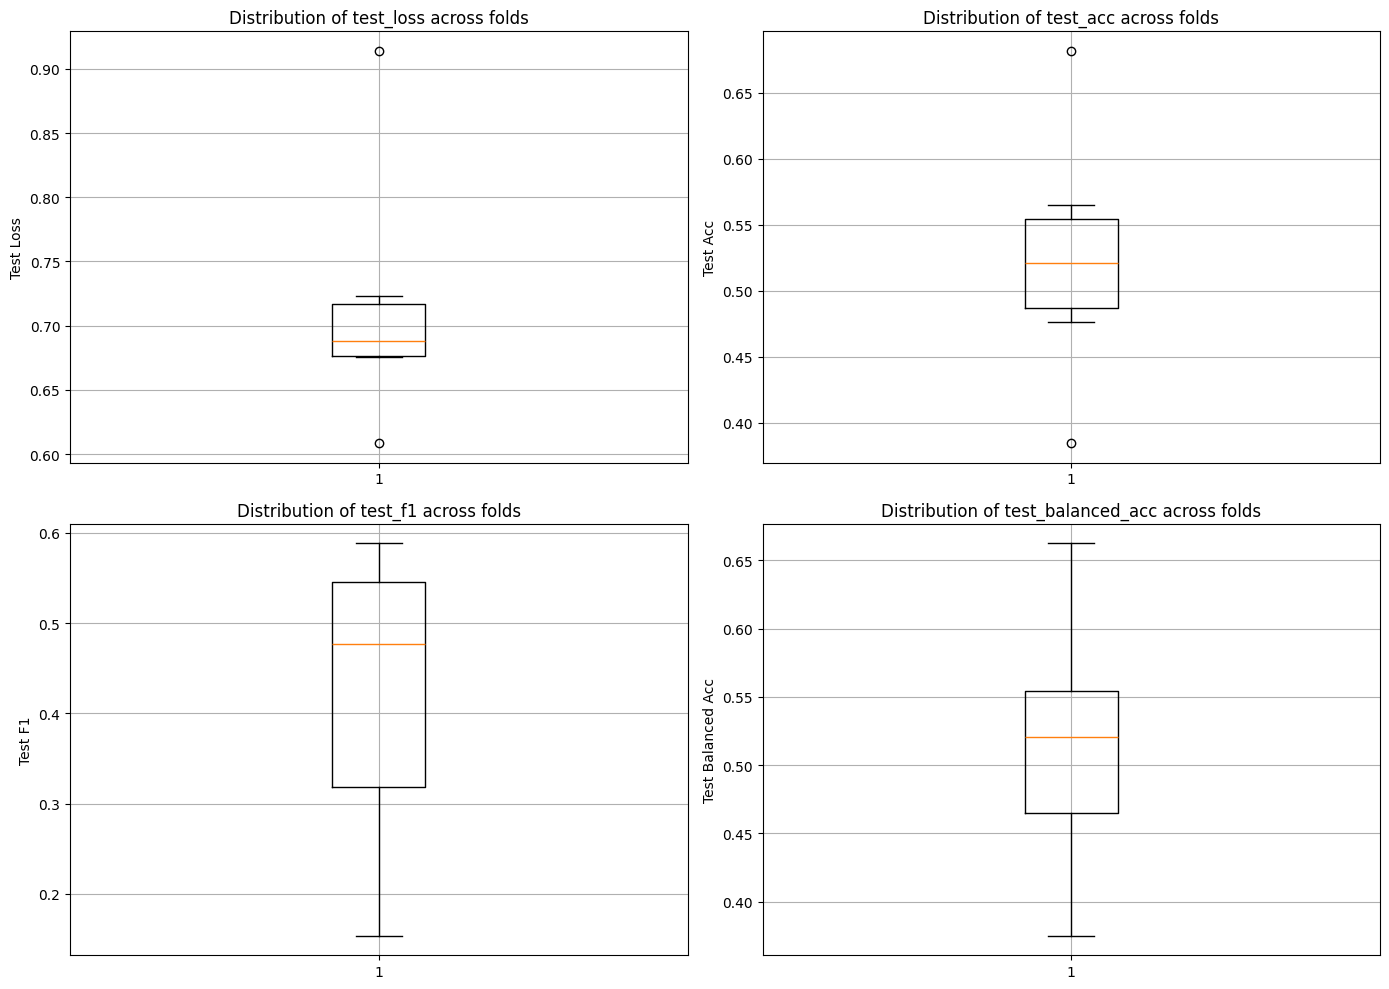

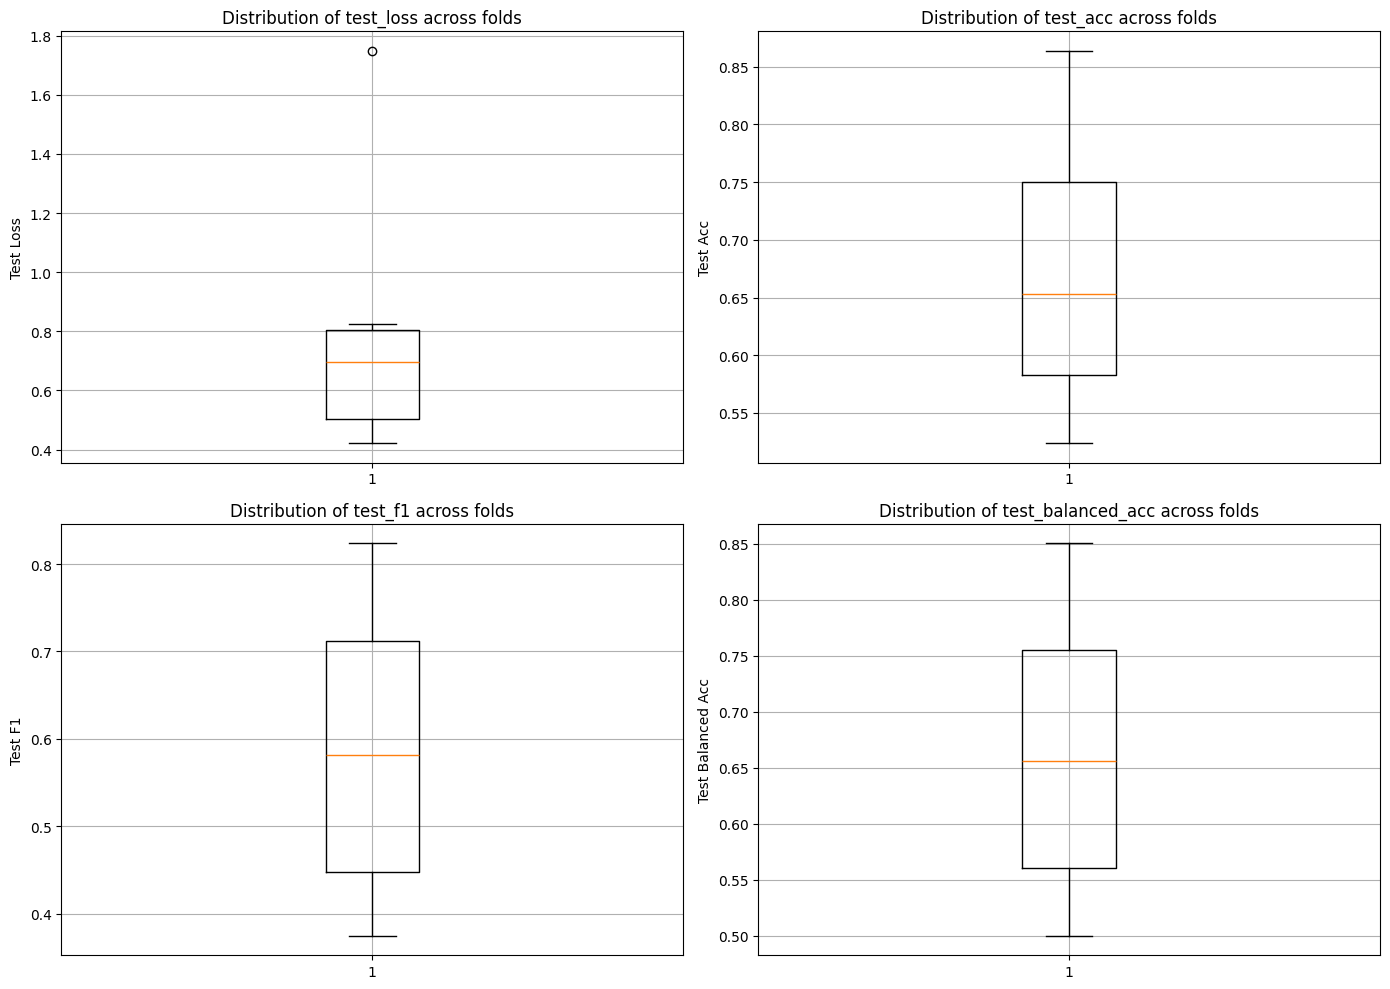

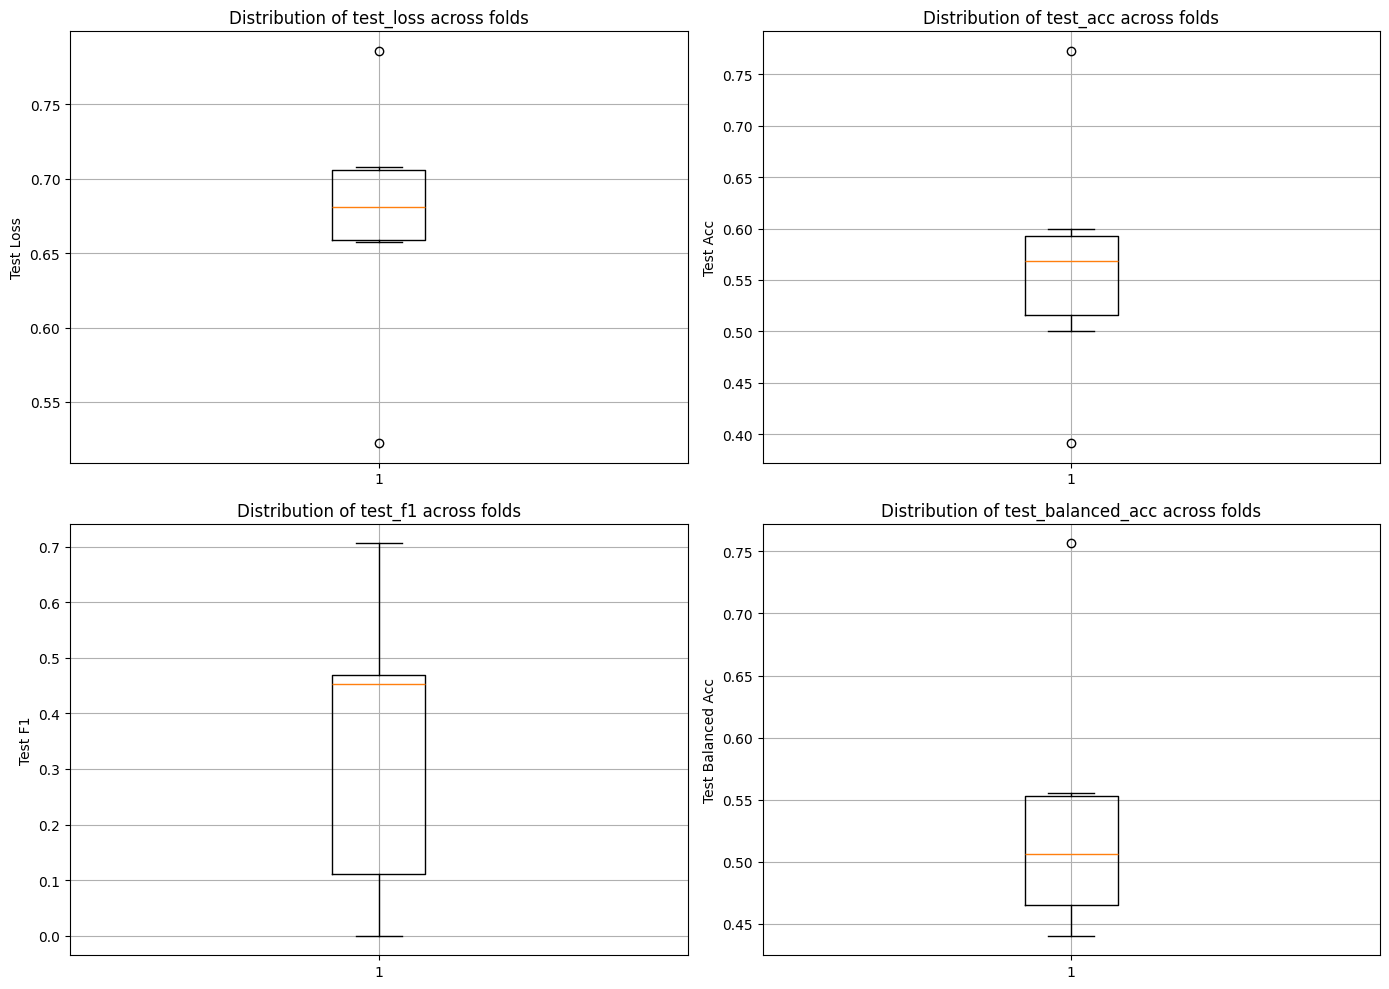

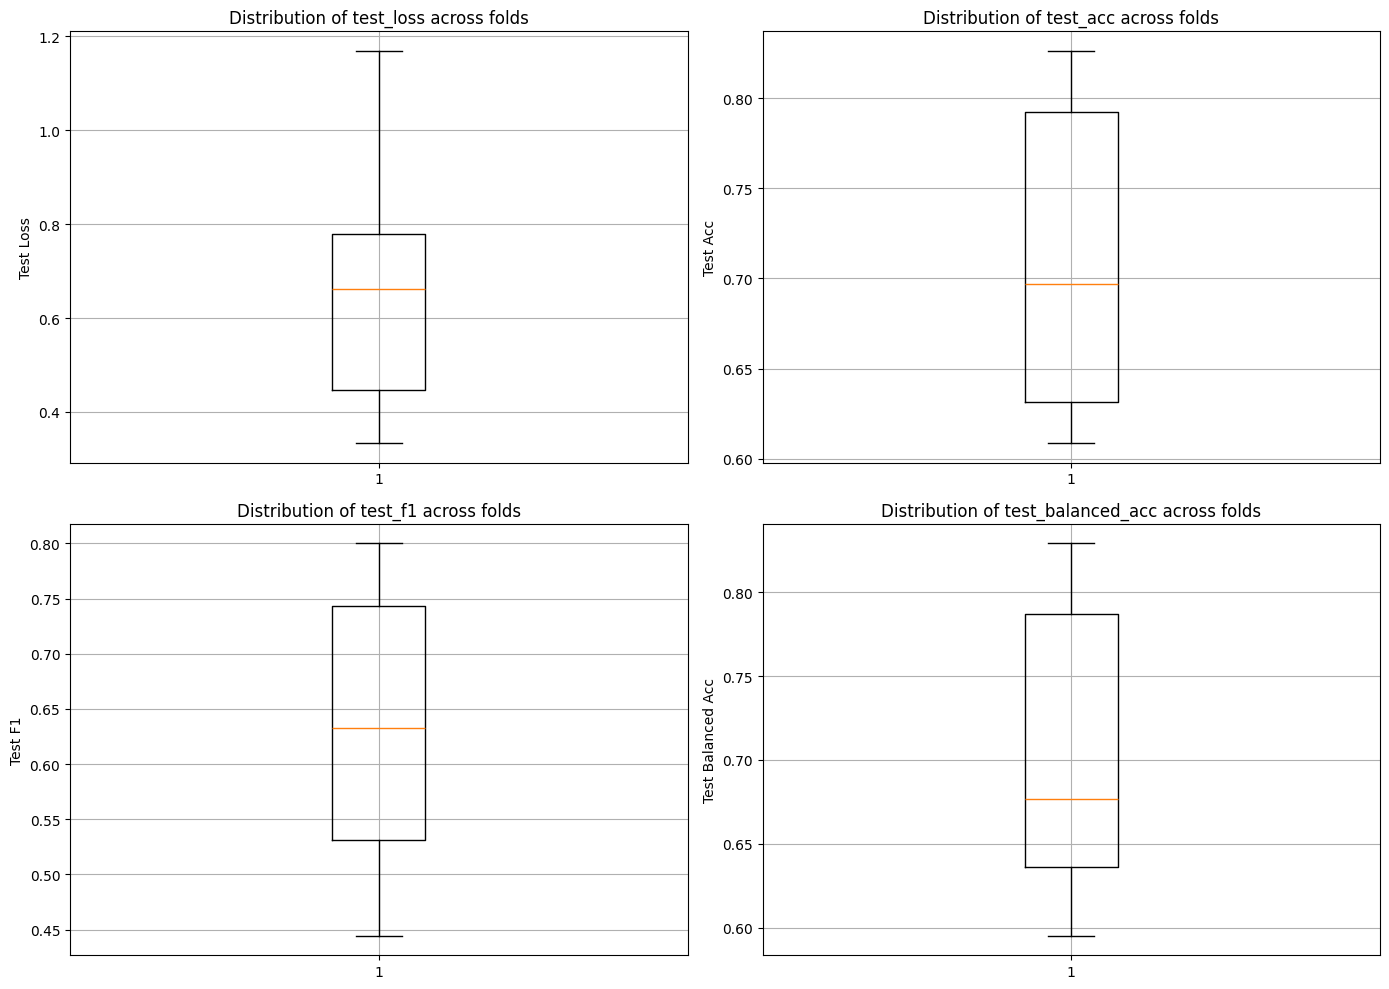

In [23]:
from utils.train_functions import BaseSSLClassifier, SSLClassifierModule, nested_cv_stratified_by_patient
import copy
from utils.train_functions import  SSLClassifierModule

FREEZE_ENCODER = True 
encoders = [byol_encoder, byol_encoder_notPretrained]
bool_list = [True, False] 
for encoder in encoders:
    for FREEZE_ENCODER in bool_list:
        if encoder == byol_encoder:
            if simsiam:
                encoder_type = "SimSiam"
            else:
                encoder_type = "BYOL"
        else:
            encoder_type = "NOSSL"
            
        def model_factory(lr: float)-> torch.nn.Module:
            """
        Model‐factory that instantiates a fresh SSLClassifierModule
        with the given learning rate.
        """
            fresh_encoder = copy.deepcopy(encoder)
            return SSLClassifierModule(
                encoder=fresh_encoder,     # capture this from your outer scope
                num_classes=2,
                freeze_encoder=FREEZE_ENCODER,
                lr=cfg.get_learning_rate(),
                backbone_output_dim=feats.shape[1],
                # input_shape=input_shape= (1, num_input_channels, 256, 256),  # Adjust as needed (B, C, H, W)
            )

        from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
        # cfg.set_freezed_layer_index(None)
        experiment = NestedCVStratifiedByPatient(
            df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
            pretrained_weights = pretrained_weights,
            class_names = class_names, model_factory=model_factory, num_folds=6
        )
        # cfg.set_freezed_layer_index(None)
        # hold_out_cv = True
        using_cosine_scheduler = False

        per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


        from utils.mlflow_functions import log_SSL_run_to_mlflow
        def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
            """
            Get the index of the best fold based on a specified metric.

            Args:
                outer_fold_test_results (list of dict): List containing test results for 
                    each outer fold. Each element should be a dictionary with metrics 
                    as keys.
                metric (str): The metric name to use for selecting the best fold. 
                    Default is "test_balanced_acc".

            Returns:
                int: The index of the fold with the highest value for the specified metric.

            Example:
                best_idx = get_best_fold_idx(results, metric="test_f1")
            """

            print(outer_fold_test_results)
            best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
            # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
            best_fold_result = outer_fold_test_results[best_fold_idx]
            print(f"Best {metric} Fold Result: {best_fold_result}")
            fold_idx = best_fold_result["fold"]
            return fold_idx

        #loading the best model for the metric selected, it's then used for computing gradcams during logging
        best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
        model_instance_for_logging, _ = experiment._get_model_and_device()
        model_instance_for_logging.eval()
        try:
            model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
        except FileNotFoundError:
            raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
        except Exception as e:
            raise Exception(f"Error loading model weights: {str(e)}")

        # Now, call the logging function:
        train_transforms, val_transforms,_ = experiment.get_current_fold_transforms()
        # Now, call the logging function:
        # or "moco" if using MoCo
        log_SSL_run_to_mlflow(
            environmentFlags=environment_flags,
            cfg=cfg,
            model=model_factory(0.001),  # Pass a dummy model to log the run
            class_names=class_names,
            fold_results=outer_fold_test_results,
            per_fold_metrics=per_fold_training_metrics,
            hold_out_cv=True,
            test_transforms=val_transforms,
            all_images_paths_np=images_paths_np,
            all_labels_np=labels_np,
            test_images_paths_np=test_images_paths_np,
            test_true_labels_np=test_true_labels_np,
            yaml_path=yaml_path,
            color_transforms=color_transforms,
            model_library=model_library,
            encoder_type= encoder_type,
            pretrained_backbone_path = STABLE_BACKBONE_PATH,
            train_transforms=train_transforms,
            # val_transforms=val_transforms,
            freeze_encoder= FREEZE_ENCODER,
            ssl=True,
        )

In [31]:
from utils.train_functions import solve_cuda_oom


solve_cuda_oom()

Memory cleared - Before: 785.31MB -> After: 603.90MB
Peak memory during session: 5421.53MB


{'initial': {'allocated': 823457792,
  'reserved': 5762973696,
  'max_allocated': 5684890112,
  'max_reserved': 5775556608},
 'final': {'allocated': 633231872, 'reserved': 849346560}}

### LOGGING

In [23]:
freezed_layer_index = cfg.get_freezed_layer_index()
print(f"Freezed layer index: {freezed_layer_index}")

Freezed layer index: None


Removed fc from encoder.
Encoder output dim: 512
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
you are on linux
Run name: Resnet18_oversamp_TL_pretrained:False__freeze:-1__color_transforms:monai_05-08_at:13-59-13
Current tracking uri: /home/zano/Documents/TESI/mlruns
-1

classifier_model
classifier_model.encoder
classifier_model.encoder.conv1
classifier_model.encoder.bn1
classifier_model.encoder.act
classifier_model.encoder.maxpool
classifier_model.encoder.layer1
classifier_model.encoder.layer1.0
classifier_model.encoder.layer1.0.conv1
classifier_model.encoder.layer1.0.bn1
classifier_model.encoder.layer1.0.act
classifier_model.encoder.layer1.0.conv2
classifier_model.encoder.layer1.0.bn2
classifier_model.encoder.layer1.1
classifier_model.encoder.layer1.1.conv1
classifier_model.encoder.layer1.1.bn1
classifier_model.encoder.layer1.1.act
classifier_model.encoder.layer1.1.conv2
classifier_model.encoder.

2025/05/08 13:59:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 224, 224])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)


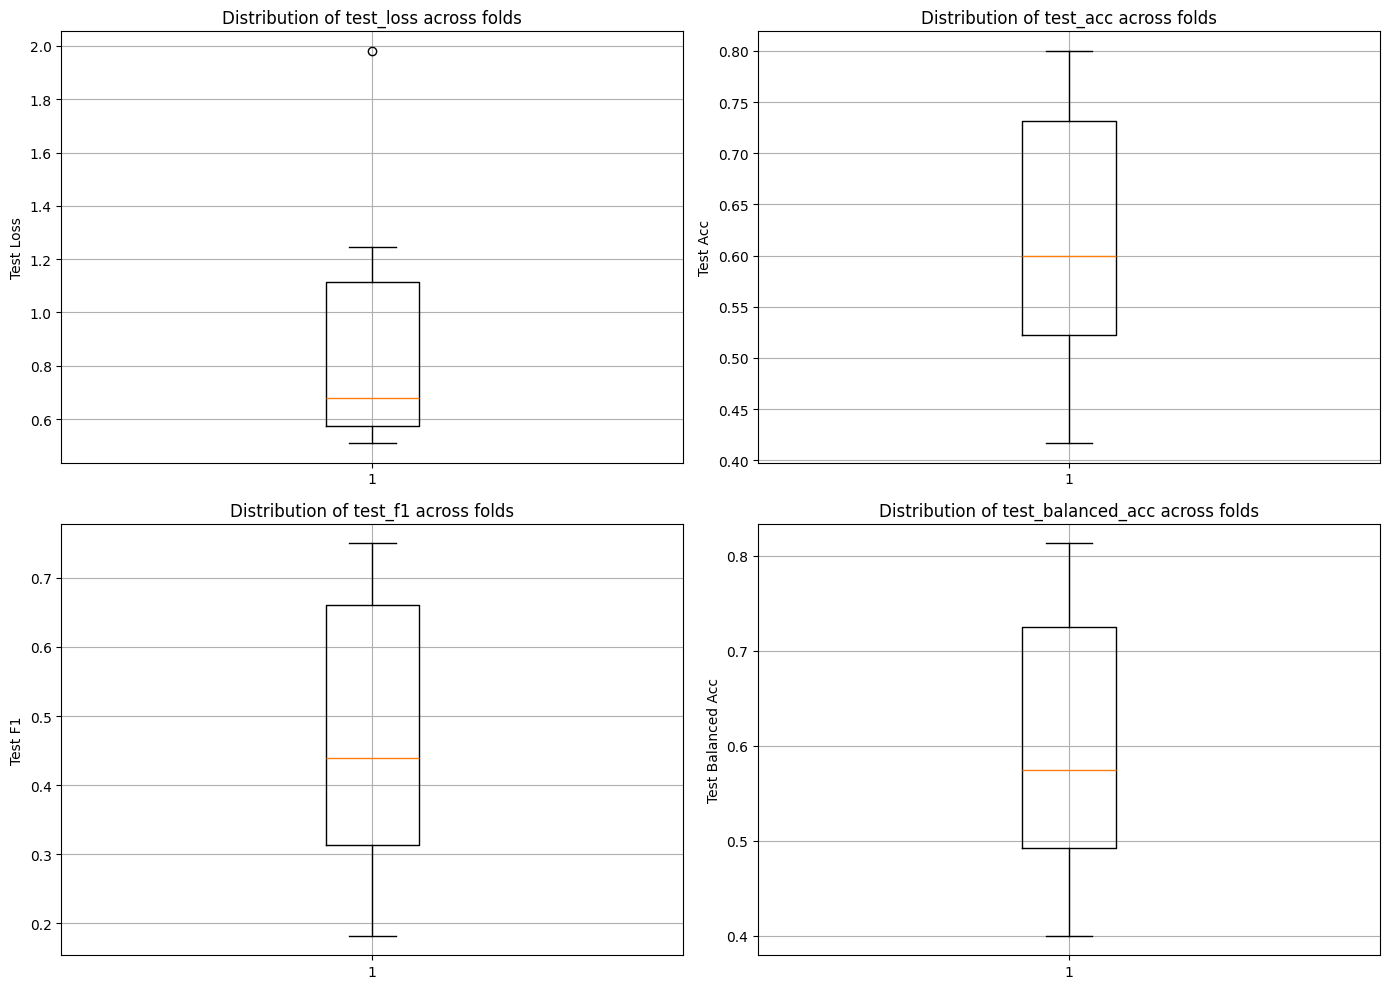

In [44]:
from utils.mlflow_functions import log_SSL_run_to_mlflow

# # Define missing arguments
# environmentFlags = {
#     "gdrive": False,
#     "kaggle": False,
#     "linux": True
# }

log_SSL_run_to_mlflow(
    environmentFlags=environment_flags,
    cfg=cfg,
    model=model_factory(0.001),  # Pass a dummy model to log the run
    class_names=class_names,
    fold_results=fold_results,
    per_fold_metrics=per_fold_metrics,
    hold_out_cv=hold_out_cv,
    test_transforms=test_transforms,
    all_images_paths_np=images_paths_np,
    all_labels_np=labels_np,
    test_images_paths_np=test_images_paths_np,
    test_true_labels_np=test_true_labels_np,
    yaml_path=yaml_path,
    color_transforms=color_transforms,
    model_library=model_library,
    encoder_type= encoder_type,
    pretrained_backbone_path = STABLE_BACKBONE_PATH ,
)

8. Patch-Based or Additional Data Strategies

Because your dataset is small, you might want to:

- Extract multiple random patches per 2D MIP (e.g., 256×256 patches from a larger 512×512 or 1024×1024 image) to artificially increase your unlabeled dataset for BYOL.
- If you can access more unlabeled confocal images (even from different but somewhat related conditions), that can improve self-supervised training.
- the BYOL loss to ensure it’s not collapsing. If your batch size is very small (e.g., 2–4), you may need to tweak the moving_average_decay.

## MOCO-v2

Using fixed, hand-extracted patches as your only “images” for MoCo-v3 pretraining usually isn’t ideal—MoCo-v3 (and most SSL methods) rely on random crops of various scales so the network learns both global structure and fine details.

In [62]:
# this is the code to define callbacks for pl training early stopping with knn evaluation accuracy as metric
import torch
import torch.nn.functional as F
from utils.train_functions import make_loader

# Function to evaluate k-NN accuracy
# This function computes the k-NN accuracy of a given backbone model on a specified data loader.
# It uses cosine similarity and temperature-scaled softmax voting to determine the accuracy.
@torch.no_grad()
def knn_eval(backbone, loader, k=20, temperature=0.1, device="cuda"):
    """
    Compute k-NN top1 accuracy of `backbone` on `loader`.
    Uses cosine similarity and temperature-scaled softmax voting.
    """
    backbone.eval()
    feats, labels = [], []

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)
        feats.append(backbone(x).flatten(start_dim=1))
        labels.append(y)
    feats = torch.cat(feats)                    # [N, D]
    labels = torch.cat(labels)                  # [N]
    feats = F.normalize(feats, dim=1)

    # cosine similarity of each sample to every other
    sim = feats @ feats.t() / temperature       # [N, N]
    _, idx = sim.topk(k=k + 1, largest=True)    # self in first position

    # Exclude itself
    idx = idx[:, 1:]                            # [N, k]

    top1 = 0
    for i in range(feats.size(0)):
        neigh_labels = labels[idx[i]]           # labels of k neighbours
        # majority vote (temperature already applied in sim)
        pred = torch.mode(neigh_labels)[0]
        top1 += int(pred == labels[i])
    return top1 / feats.size(0)


import pytorch_lightning as pl

#lightning callback to evaluate k-NN accuracy
class KNNMonitor(pl.Callback):
    """
    Compute k-NN accuracy on a fixed probe set every `frequency` epochs.
    Logs it as 'knn_acc' so EarlyStopping can watch it.
    """
    def __init__(self, probe_loader, k=20, frequency=1, temperature=0.1, device=None):
        super().__init__()
        self.probe_loader = probe_loader
        self.k = k
        self.freq = frequency
        self.temp = temperature
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    def on_train_epoch_end(self, trainer, pl_module):
        # run only every `frequency` epochs
        if (trainer.current_epoch + 1) % self.freq != 0:
            return

        acc = knn_eval(
            backbone=pl_module.backbone,        # online encoder
            loader=self.probe_loader,
            k=self.k,
            temperature=self.temp,
            device=self.device,
        )
        # log so that EarlyStopping can monitor it
        pl_module.log("knn_acc", acc, prog_bar=True, on_epoch=True, logger=True)
        epoch = trainer.current_epoch
        print(f"[Epoch {epoch}]  k-NN accuracy: {acc*100:.2f}%")

# Create a new DataLoader for knn test used for early stopping
test_images_paths_np = np.array(balanced_test_images_paths)
test_true_labels_np = np.array(test_true_labels)

knn_loader = make_loader(
    balanced_test_images_paths,
    test_true_labels_np,
    transforms=val_transforms,
    cfg=cfg,
    shuffle=False,
)

from pytorch_lightning.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="knn_acc",
    mode="max",        # we want accuracy to go UP
    patience=100,        # stop if no improvement in 5 evals
    min_delta=0.0,
    check_on_train_epoch_end=True,
)

knn_cb = KNNMonitor(
    probe_loader=knn_loader,
    k=20,
    frequency=1,       # every epoch
)

class PrintEpochLossCallback(pl.Callback):
    """
    Prints the epoch-level loss after each training epoch.
    Assumes you log a metric called 'train_loss'.
    """

    def on_train_epoch_end(self, trainer, pl_module):
        # 'trainer.callback_metrics' holds the metrics you logged this epoch
        epoch_loss = trainer.callback_metrics.get("train_loss")
        current_epoch = trainer.current_epoch
        if epoch_loss is not None:
            print(f"[Epoch {current_epoch}] => train_loss: {epoch_loss:.4f}")
        else:
            print(f"[Epoch {current_epoch}] => train_loss not found!")

print_epoch_loss = PrintEpochLossCallback()

In [63]:
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset
from pathlib import Path
import random
import tifffile, numpy as np

class RandomPatchDataset(Dataset):
    def __init__(self, paths, patch_size=256, patches_per_image=8, transform=None):
        self.paths = list(map(Path, paths))
        self.ps = patch_size
        self.np = patches_per_image
        self.transform = transform

    def __len__(self):
        # length is “virtual”: n_images × patches_per_image
        return len(self.paths) * self.np

    def __getitem__(self, idx):
        img_path = self.paths[idx // self.np]
        img = tifffile.imread(img_path)           # CHW or HWC, adapt as needed
        if img.ndim == 3 and img.shape[0] <= 4:   # CHW → HWC
            img = np.transpose(img, (1, 2, 0))

        h, w = img.shape[:2]
        y = random.randint(0, h - self.ps)
        x = random.randint(0, w - self.ps)
        patch = img[y:y+self.ps, x:x+self.ps]

        patch = TF.to_pil_image(patch)
        if self.transform:
            patch = self.transform(patch)         # produces two views for MoCo
        return patch


In [ ]:
###############################################################
# File: moco_lightning.py
#
# Install required libs:
#   pip install lightly pytorch-lightning torchvision torch
#
# Then run:
#   python moco_lightning.py
###############################################################
import copy

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
# Lightly imports
from lightly.data import LightlyDataset
from lightly.loss import NTXentLoss
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.utils.scheduler import cosine_schedule


class MoCo(pl.LightningModule):
    """
    A PyTorch Lightning module implementing MoCo v2-like training.
    """

    def __init__(self, base_encoder="resnet50", num_ftrs=512, out_dim=128, max_epochs=10):
        """
        Args:
            base_encoder: Which torchvision ResNet to use. e.g. 'resnet18' => 512-d final layer
                          'resnet50' => 2048-d final layer.
            num_ftrs: Dimension of the backbone's output before the final FC.
                      For resnet18 => 512, for resnet50 => 2048.
            out_dim: Dimension of the projection head output (128 typical).
            max_epochs: For scheduling momentum with cosine_schedule.
        """
        super().__init__()
        # Build a standard torchvision backbone (without the final FC)
        resnet = getattr(torchvision.models, base_encoder)(weights = None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC

        # Projection head for the online encoder
        self.projection_head = MoCoProjectionHead(num_ftrs, num_ftrs, out_dim)

        # Create momentum backbone and head as copies
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze momentum backbone to avoid gradient updates
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

        # Contrastive loss with memory bank
        # size=(memory_bank_size, out_dim), e.g. memory_bank_size=4096, out_dim=128
        # Use NTXentLoss as recommended in lightly docs for MoCo v2
        self.criterion = NTXentLoss(memory_bank_size=4096)

        # We will do a cosine schedule for momentum
        self.max_epochs = max_epochs

    def forward(self, x):
        """
        Forward pass of the online (query) encoder.
        x: (B, C, H, W) => returns the projection vector of shape (B, out_dim).
        """
        query = self.backbone(x).flatten(start_dim=1)    # e.g. shape (B, 512) for resnet18
        query = self.projection_head(query)              # shape (B, out_dim)
        return query

    def forward_momentum(self, x):
        """
        Forward pass of the momentum (key) encoder.
        """
        key = self.backbone_momentum(x).flatten(start_dim=1)
        key = self.projection_head_momentum(key).detach()
        return key

    def training_step(self, batch, batch_idx):
        if batch_idx == 0 and self.current_epoch == 0:
            print("DEBUG shapes:", len(batch), batch[0].shape, batch[1].shape)
        views = batch[0]
        q = self.forward(views[0])
        k = self.forward_momentum(views[1])
        loss = self.criterion(q, k)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    # keep the EMA update *after* optimiser step
    def on_train_batch_end(self, *_):
        m = cosine_schedule(self.current_epoch, self.max_epochs, 0.996, 1.0)
        update_momentum(self.backbone,        self.backbone_momentum,        m)
        update_momentum(self.projection_head, self.projection_head_momentum, m)

    def configure_optimizers(self):
        # batch_size = 32
        opt = torch.optim.SGD(self.parameters(),
                              lr=0.03 * (32/256),
                              momentum=0.9, weight_decay=1e-4)
    
        return opt

# 1) Create the MoCo model with a resnet18 backbone
#    If you want resnet50 => num_ftrs=2048
print("Creating MoCo model...")
max_epochs = 100
model = MoCo(base_encoder="resnet50", num_ftrs=2048, out_dim=128, max_epochs=max_epochs)

# 2) Define your transforms
#    MoCoV2Transform returns two views: x_query, x_key
#    input_size=256 => randomly resize/crop to 256
transform = MoCoV2Transform(input_size=cfg.get_image_shape()[0],
                            # cj_prob=0.5,  # color jitter probability
                            # cj_strength=0.5,  # color jitter strength
                            # cj_bright=0.4,  # brightness strength
                            # cj_contrast=0.4,  # contrast strength
                            # cj_sat=0.4,  # saturation strength
                            # gaussian_blur=0.1,  # gaussian blur probability
                            )

# 3) Create a dataset from your unlabeled folder of images
#    e.g., data/unlabeled/
# dataset = LightlyDataset(f"/home/zano/Documents/TESI/{num_input_channels}c_MIP_new/ALL/", transform=transform)
# print("Number of samples in the dataset:", len(dataset))

# 4) Create a DataLoader
transform = MoCoV2Transform(
    input_size=256,           # match patch dimension
    # gaussian_blur=0.2,
    # cj_prob=0.5,
)

ds = RandomPatchDataset(all_images_paths, patch_size=256,
                        patches_per_image=10, transform=transform)

print("Number of samples in the dataset:", len(ds))


loader = DataLoader(ds, batch_size=64, shuffle=True,  # TODO: change to a much greater batch size at least 128
                    num_workers=4, drop_last=True
                    )
# 5) Train with PyTorch Lightning
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(
    gradient_clip_val=1.0,
    max_epochs=max_epochs,
    min_epochs=1,
    max_steps=-1, 
    devices=1,
    accelerator=accelerator,
    #log_every_n_steps=1
    precision="32-true",  # mixed precision
    enable_progress_bar=False,            # turn off TQDM updates
    callbacks=[
            print_epoch_loss,
            knn_cb,                    
            early_stop,
        ]  # use our custom callback
)

trainer.fit(model=model, train_dataloaders=dataloader)

# 6) Save your trained model (the "online" part)
#    Typically you keep the backbone for downstream tasks
encoder_name = "moco_backbone_es"
encoder_weights = torch.save(model.backbone.state_dict(), encoder_name + ".pth")
print(f"MoCo training completed. Saved backbone to {encoder_name}.pth")

# load the saved model
moco_encoder = MoCo(base_encoder="resnet50", num_ftrs=2048, out_dim=128, max_epochs=10)
moco_encoder.backbone.load_state_dict(torch.load(encoder_name + ".pth"))

In [ ]:
"""
tiny_moco_patches.py
--------------------
MoCo-v2 pre-training on very small datasets by turning each high-resolution
image into many random 256×256 patches.

* 10 patches per slide  →  152 slides  →  1 520 virtual samples
* batch 64 with NVIDIA mixed-precision (fits 12 GB GPU)
* NT-Xent queue 512 (updates fully every 8 steps)
* momentum schedule 0.95 → 0.90
* loss should fall from ≈5.4 to <4 within 10-15 epochs
"""

from pathlib import Path
import math, random, copy, tifffile, numpy as np
import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from lightly.loss import NTXentLoss
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.moco_transform import MoCoV2Transform


# ------------------------------------------------------------------
# 1)  Random-patch dataset
# ------------------------------------------------------------------
class RandomPatchDataset(Dataset):
    def __init__(self, paths, patch=256, per_img=10, transform=None):
        self.paths, self.ps, self.per_img, self.tf = list(paths), patch, per_img, transform

    def __len__(self):
        return len(self.paths) * self.per_img     # virtual length

    def __getitem__(self, idx):
        img = tifffile.imread(self.paths[idx // self.per_img])
        if img.ndim == 3 and img.shape[0] <= 4:          # CHW → HWC
            img = np.transpose(img, (1, 2, 0))
        h, w = img.shape[:2]; p = self.ps
        y, x = random.randint(0, h - p), random.randint(0, w - p)
        patch = img[y:y+p, x:x+p]
        patch = torchvision.transforms.functional.to_pil_image(patch)
        return self.tf(patch)            # MoCoV2Transform returns [view_q, view_k]


# ------------------------------------------------------------------
# 2)  Simple collate-fn that stacks the two views
# ------------------------------------------------------------------
def moco_collate(batch):
    # batch = [[v_q0, v_k0], [v_q1, v_k1], ...]
    x_q = torch.stack([b[0] for b in batch], 0)
    x_k = torch.stack([b[1] for b in batch], 0)
    return x_q, x_k


# ------------------------------------------------------------------
# 3)  MoCo model (ResNet-50 backbone)
# ------------------------------------------------------------------
class MoCo(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        resnet = torchvision.models.resnet50(weights=None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])        # 2048-d
        self.head = MoCoProjectionHead(2048, 2048, out_dim)

        self.backbone_m = copy.deepcopy(self.backbone)
        self.head_m     = copy.deepcopy(self.head)
        deactivate_requires_grad(self.backbone_m)
        deactivate_requires_grad(self.head_m)

    def forward(self, x):
        z = self.backbone(x).flatten(1)
        return self.head(z)

    @torch.no_grad()
    def forward_m(self, x):
        z = self.backbone_m(x).flatten(1)
        return self.head_m(z)


# ------------------------------------------------------------------
# 4)  Build data loaders
# ------------------------------------------------------------------
num_input_channels = 3   # <-- set 1, 2, 3, or 4 depending on your TIFFs

img_dir = Path(f"/home/zano/Documents/TESI/{num_input_channels}c_MIP_new/ALL")
paths   = sorted(p for p in img_dir.glob("*.tif*"))        # adapt extension if PNG/JPG

transform = MoCoV2Transform(
    input_size=256,
    gaussian_blur=0.5,
    cj_prob=0.8,
)

from torchvision import transforms

# overwrite the default RandomResizedCrop with a custom one
transform.random_resized_crop = transforms.RandomResizedCrop(
    size=256,
    scale=(0.5, 1.0),          # ← wider scale range
    ratio=(3/4, 4/3),
    interpolation=transforms.InterpolationMode.BICUBIC,
    antialias=True
)

# from torchvision import transforms
# # from lightly.transforms.utils import GaussianBlur

# transform = transforms.Compose([
#     transform.ensure_cha
#     transforms.RandomResizedCrop(
#         256, scale=(0.5, 1.0), ratio=(3/4, 4/3),
#         interpolation=transforms.InterpolationMode.BICUBIC,
#         antialias=True),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomApply([
#         transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
#     ], p=0.8),
#     transforms.RandomGrayscale(p=0.2),
#     # GaussianBlur(0.5),                       # same as MoCoV2 default
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406][:num_input_channels],
#         std =[0.229, 0.224, 0.225][:num_input_channels]),
# ])

dataset = RandomPatchDataset(paths, patch=256, per_img=10, transform=transform)
loader  = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True,
                     num_workers=4, collate_fn=moco_collate)

print(f"Slides: {len(paths)}  |  virtual patches/epoch: {len(dataset)}")


# ------------------------------------------------------------------
# 5)  Model, optimiser, loss, scaler
# ------------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = MoCo().to(device)

criterion = NTXentLoss(memory_bank_size=128, temperature=0.1)
opt = torch.optim.SGD(model.parameters(), lr=0.03 * (64/256),
                      momentum=0.9, weight_decay=1e-4)
scaler = GradScaler()

# ------------------------------------------------------------------
# 6)  Training
# ------------------------------------------------------------------
epochs = 100
for ep in range(epochs):
    model.train()
    total = 0.0
    m_val = 0.90 + 0.05 * (1 + math.cos(math.pi * ep / epochs)) / 2   # 0.95→0.90

    for x_q, x_k in loader:
        x_q, x_k = x_q.to(device), x_k.to(device)

        # momentum encoder update *before* forward pass (official MoCo order)
        update_momentum(model.backbone, model.backbone_m, m_val)
        update_momentum(model.head,     model.head_m,     m_val)

        with autocast():                            # mixed precision
            q = model(x_q)
            k = model.forward_m(x_k)
            loss = criterion(q, k)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
        total += loss.detach()

    avg = (total / len(loader)).item()
    print(f"Epoch {ep:03d}  NT-Xent loss: {avg:.4f}")

print("Finished.  Save backbone with:")
print("torch.save(model.backbone.state_dict(), 'moco_backbone.pth')")


In [ ]:
#print(model)
import torchvision
from torchvision import models
resnet = getattr(torchvision.models, 'resnet50')(weights = None)
print(*list(resnet.children())[:-2])

In [ ]:
import optuna
from utils.data_visualization_functions import generate_cv_results_figure
from utils.train_functions import train_epoch, undersample_majority, val_epoch, train_epoch_mixUp, oversample_minority
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from monai.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

# class BaseSSLClassifier(nn.Module): as defined in byol/simsiam


# Example usage in a PyTorch Lightning module for supervised fine-tuning:
class SSLClassifierModule(pl.LightningModule):
    def __init__(self, encoder: nn.Module, num_classes: int = 2, freeze_encoder: bool = True, backbone_output_dim: int = None, lr: float = 1e-4):
        super().__init__()
        self.save_hyperparameters(ignore=["encoder"])
        self.classifier_model = BaseSSLClassifier(encoder, num_classes, freeze_encoder, backbone_output_dim)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.classifier_model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", acc, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.lr)




from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    RandFlipd, RandRotate90d, Resized, ToTensord, NormalizeIntensityd
)

# Define transforms for training with data augmentation
train_transforms = Compose([
    LoadImaged(keys=["image"], reader="itkreader"),  # Load the image from disk
    EnsureChannelFirstd(keys=["image"]),  # Convert to channel-first format
    LambdaD(keys=["image"], func=lambda x: x[:3, ...]),  # Keep only first 3 channels
    Resized(keys=["image"], spatial_size=(224, 224)),  # Resize to match model input
    RandFlipd(keys=["image"], prob=0.5),  # Random horizontal flips
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),  # Scale to [0, 1]
    # NormalizeIntensityd(
    #     keys=["image"], 
    #     mean=[0.485, 0.456, 0.406], 
    #     std=[0.229, 0.224, 0.225]
    # ),  # ImageNet normalization
    ToTensord(keys=["image"]),  # Convert to PyTorch tensor
])

# Define transforms for validation/testing (no augmentations)
val_transforms = Compose([
    LoadImaged(keys=["image"], reader="itkreader"),  # Load the image from disk
    EnsureChannelFirstd(keys=["image"]),
    LambdaD(keys=["image"], func=lambda x: x[:3, ...]),  # Keep only first 3 channels
    Resized(keys=["image"], spatial_size=(224, 224)),
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    # NormalizeIntensityd(
    #     keys=["image"], 
    #     mean=[0.485, 0.456, 0.406], 
    #     std=[0.229, 0.224, 0.225]
    # ),
    ToTensord(keys=["image"]),
])

test_transforms = val_transforms  # Same transforms for testing

# Call the function:
results = run_outer_cv_patient_stratified(
    df=df,
    unique_pat_ids=unique_pat_ids,
    pat_labels=pat_labels,
    cfg=cfg,
    encoder = moco_encoder,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    test_transforms=test_transforms,
)

## Barlow Twins

In [ ]:
%pip install transformers

In [ ]:
# GEMINI VERSION OF PRETRAINING THE BACKBONE
from torch.utils.data import DataLoader
from torch.optim import AdamW
# Import PyTorch schedulers
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR

# Lightly imports (make sure these are installed and correct)
from lightly.data import LightlyDataset
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
# Assuming BarlowTwinsProjectionHead and BarlowTwinsLoss are defined correctly elsewhere
# from your_module import BarlowTwinsProjectionHead, BarlowTwinsLoss

LEARNING_RATE = 3e-4 # Initial learning rate (peak after warmup)
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 250     # Or your desired number
WARMUP_EPOCHS = 10   # Number of epochs for linear warmup
BATCH_SIZE = 32      # Increase if GPU memory allows (e.g., 64, 128, 256)
NUM_WORKERS = 4
GRADIENT_CLIP_VAL = 1.0 # Max norm for gradient clipping
# --- Ensure num_input_channels is defined BEFORE this line ---
# Example: num_input_channels = 3
try:
    num_input_channels
except NameError:
    print("Warning: 'num_input_channels' was not defined before INPUT_DIR usage. Assuming 3.")
    num_input_channels = 3
INPUT_DIR = f"/home/zano/Documents/TESI/{num_input_channels}c_MIP_new/CONTROL"
BARLOW_PROJECT_DIM = 2048 # Or your desired projection dim


# --- Helper function for linear warmup lambda ---
def linear_warmup_decay(warmup_steps):
    """ Linear warmup for warmup_steps steps. """
    def fn(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0 # Constant multiplier after warmup
    return fn

########################################################
# 2) Barlow Twins LightningModule (Using PyTorch Schedulers, Fixed Setup)
########################################################
class BarlowTwins(pl.LightningModule):
    def __init__(self, learning_rate, warmup_epochs, max_epochs):
        """
        ResNet18 backbone -> 512-d features
        Projection head -> (512 -> proj_dim -> proj_dim)
        BarlowTwinsLoss for self-supervised training
        """
        super().__init__()
        # Save hyperparameters like learning_rate, warmup_epochs, max_epochs
        # These are needed for scheduler setup in configure_optimizers
        self.save_hyperparameters()

        # Create ResNet18, initialized with ImageNet weights
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        resnet_output_dim = 512

        # Barlow Twins head
        self.projection_head = BarlowTwinsProjectionHead(
            resnet_output_dim,
            BARLOW_PROJECT_DIM,
            BARLOW_PROJECT_DIM
        )
        self.criterion = BarlowTwinsLoss()

        # Store steps_per_epoch, calculated in setup
        self.steps_per_epoch = 0

    # --- REVISED setup method ---
    def setup(self, stage=None):
        """Calculate steps_per_epoch after dataloader is available."""
        if stage == 'fit' or stage is None:
            # Check if trainer and dataloaders are available
            if not self.trainer or not self.trainer.train_dataloader:
                print("Warning: Trainer or train_dataloader not available in setup.")
                return

            try:
                # Get the length of the dataloader
                self.steps_per_epoch = len(self.trainer.train_dataloader)
                print(f"Calculated steps per epoch in setup: {self.steps_per_epoch}")

            except TypeError:
                # Handle cases where dataloader has no __len__ (e.g., IterableDataset)
                # Estimate based on limit_train_batches if set
                if self.trainer.limit_train_batches:
                     if isinstance(self.trainer.limit_train_batches, int):
                         self.steps_per_epoch = self.trainer.limit_train_batches
                     elif isinstance(self.trainer.limit_train_batches, float):
                          # Estimate requires dataset size, difficult to get reliably here
                          self.steps_per_epoch = 500 # Fallback guess
                          print(f"Warning: Cannot determine length from dataloader and limit_train_batches is a float.")
                          print(f"Using fallback estimate for steps_per_epoch: {self.steps_per_epoch}")
                     else:
                          self.steps_per_epoch = 500 # Fallback guess
                          print(f"Warning: Unknown type for limit_train_batches.")
                          print(f"Using fallback estimate for steps_per_epoch: {self.steps_per_epoch}")
                     print(f"Using limit_train_batches to set steps_per_epoch: {self.steps_per_epoch}")
                else:
                     # If no length and no limit, estimation is hard. Use a default with warning.
                     self.steps_per_epoch = 500 # Fallback guess
                     print(f"Warning: Could not determine dataloader length (possibly IterableDataset without length).")
                     print(f"Using fallback estimate for steps_per_epoch: {self.steps_per_epoch}")
                     print(f"For accurate scheduler behaviour, ensure train dataloader has __len__ or set trainer's limit_train_batches.")

            if self.steps_per_epoch == 0:
                 raise ValueError("Could not determine steps_per_epoch for LR scheduler. Aborting.")

    def forward(self, x):
        """ Forward pass for one augmented view x. """
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_idx):
        """ Barlow Twins requires two augmented views (x0, x1). """
        # Adapt based on actual batch structure from LightlyDataset
        if isinstance(batch, (list, tuple)) and len(batch) == 3:
             (x0, x1), _, _ = batch # common case: (views), labels, fnames
        elif isinstance(batch, (list, tuple)) and len(batch) == 2 and isinstance(batch[0], (list, tuple)):
             (x0, x1), _ = batch # case: (views), labels
        elif isinstance(batch, (list, tuple)) and len(batch) == 1 and isinstance(batch[0], (list, tuple)):
             (x0, x1) = batch[0] # case: (views)
        else:
            # Attempt to handle dictionary batches if applicable
            try:
                 views = batch[0] # Assuming views are the first element if it's not a standard lightly format
                 if isinstance(views, (list, tuple)) and len(views) == 2:
                      x0, x1 = views
                 else:
                      raise TypeError("Could not extract two views from batch[0]")
            except (IndexError, KeyError, TypeError) as e:
                 raise ValueError(f"Unexpected batch format in training_step. Type: {type(batch)}, Content sample: {str(batch)[:100]}, Error: {e}")


        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)

        # Log loss and learning rate
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        """ Use AdamW and a SequentialLR scheduler (Warmup + Cosine Decay). """
        optimizer = AdamW(self.parameters(),
                          lr=self.hparams.learning_rate,
                          weight_decay=WEIGHT_DECAY)

        # Ensure setup has run and calculated steps_per_epoch
        if self.steps_per_epoch == 0:
             # If setup didn't run or failed (e.g. Trainer(fast_dev_run=True))
             # Use a reasonable fallback, but warn the user.
             self.steps_per_epoch = 500
             print(f"Warning: steps_per_epoch was 0 in configure_optimizers. Using fallback: {self.steps_per_epoch}. "
                   "This might happen with fast_dev_run or if setup failed.")


        warmup_steps = self.steps_per_epoch * self.hparams.warmup_epochs
        # Adjust total_steps calculation based on max_epochs potentially changing
        max_epochs = self.trainer.max_epochs if self.trainer and self.trainer.max_epochs else self.hparams.max_epochs
        total_steps = self.steps_per_epoch * max_epochs
        decay_steps = total_steps - warmup_steps

        # Ensure decay_steps is not negative if warmup_epochs >= max_epochs
        decay_steps = max(1, decay_steps)

        print(f"Optimizer: AdamW, Initial LR: {self.hparams.learning_rate}")
        print(f"Scheduler: SequentialLR(Warmup + CosineAnnealingLR)")
        print(f"  Total estimated steps: {total_steps}")
        print(f"  Warmup steps: {warmup_steps}")
        print(f"  Cosine decay steps: {decay_steps}")


        scheduler_warmup = LambdaLR(
            optimizer,
            lr_lambda=linear_warmup_decay(warmup_steps)
        )
        scheduler_cosine = CosineAnnealingLR(
            optimizer,
            T_max=decay_steps,
            eta_min=1e-7 # Slightly higher minimum LR
        )
        lr_scheduler = SequentialLR(
            optimizer,
            schedulers=[scheduler_warmup, scheduler_cosine],
            milestones=[warmup_steps]
        )

        scheduler_config = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler_config]

########################################################
# 3) Main Function to Run Training (Using PyTorch Schedulers)
########################################################

# (Make sure BarlowTwinsProjectionHead and BarlowTwinsLoss are correctly defined/imported)
# Example Stubs:
class BarlowTwinsProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim, bias=False),
        )
    def forward(self, x):
        return self.layers(x)

class BarlowTwinsLoss(nn.Module):
     def __init__(self, lambda_param=5e-3):
         super().__init__()
         self.lambda_param = lambda_param
     def forward(self, z_a: torch.Tensor, z_b: torch.Tensor) -> torch.Tensor:
         z_a_norm = (z_a - z_a.mean(0)) / (z_a.std(0) + 1e-6) # Add epsilon for stability
         z_b_norm = (z_b - z_b.mean(0)) / (z_b.std(0) + 1e-6) # Add epsilon for stability
         N = z_a.size(0)
         D = z_a.size(1)
         c = torch.mm(z_a_norm.T, z_b_norm) / N
         c_diff = (c - torch.eye(D, device=c.device)).pow(2)
         c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
         loss = c_diff.sum()
         return loss

# 1) Define Transforms
transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=256, gaussian_blur=0.1),
    view_2_transform=BYOLView2Transform(input_size=256, gaussian_blur=0.1),
)

# 2) Create Dataset
dataset = LightlyDataset(
    input_dir=INPUT_DIR,
    transform=transform
)
print(f"Dataset size: {len(dataset)}")

# 3) Create DataLoader
# Consider using pin_memory=True if using GPU and not seeing slowdowns
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    # pin_memory=True # Optional
)

# 4) Create the Barlow Twins model instance
model = BarlowTwins(learning_rate=LEARNING_RATE,
                    warmup_epochs=WARMUP_EPOCHS,
                    max_epochs=MAX_EPOCHS)

# 5) Setup Callbacks
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')
progress_bar = pl.callbacks.TQDMProgressBar(refresh_rate=20)

# 6) Train with PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed",
    gradient_clip_val=GRADIENT_CLIP_VAL,
    callbacks=[lr_monitor, progress_bar],
    # logger= # Add logger if desired
    # log_every_n_steps=50
)

print("Starting Barlow Twins pre-training (using PyTorch LR schedulers)...")
# The trainer automatically calls model.setup('fit') before starting training
trainer.fit(model=model, train_dataloaders=dataloader)
print("Pre-training finished.")

# 7) After training, save ONLY the backbone
save_dir = "."
os.makedirs(save_dir, exist_ok=True)
backbone_save_path = os.path.join(save_dir, "barlow_backbone_stable_pytorch_sched.pth")

torch.save(model.backbone.state_dict(), backbone_save_path)
print(f"Stable Barlow Twins pretraining completed. Saved backbone to '{backbone_save_path}'.")

In [ ]:
# lightning VERSION NOT WORKING --> IT CREATES EXPLODING GRADIENTS

import pytorch_lightning as pl
import torchvision
from torch import nn
from torch.utils.data import DataLoader

# Lightly imports
from lightly.data import LightlyDataset
from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLTransform, BYOLView1Transform, BYOLView2Transform
)
########################################################
# 1) Custom Callback to Print Epoch Loss
########################################################
class PrintEpochLossCallback(pl.Callback): #inherits from pl.Callback
    """
    Prints the 'train_loss' metric (averaged over the epoch)
    after each epoch ends, on a new console line.
    """
    def on_train_epoch_end(self, trainer, pl_module):
        epoch_loss = trainer.callback_metrics.get("train_loss")
        current_epoch = trainer.current_epoch
        if epoch_loss is not None:
            print(f"[Epoch {current_epoch}] => train_loss: {epoch_loss:.4f}")
        else:
            print(f"[Epoch {current_epoch}] => train_loss not found!")


########################################################
# 2) Barlow Twins LightningModule
########################################################
class BarlowTwins(pl.LightningModule):
    def __init__(self):
        """
        ResNet18 backbone -> 512-d features
        Projection head -> (512 -> 2048 -> 2048)
        BarlowTwinsLoss for self-supervised training
        """
        super().__init__()
        # Create ResNet18, remove the final FC layer
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) #TODO start using imagenet weights
        # bnuild the backbone by removing the final FC layer from the resnet
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # shape (B,512,1,1)

        # Barlow Twins head: 512 -> 2048 -> 2048
        self.projection_head = BarlowTwinsProjectionHead(
            512,  # input dimension from resnet18
            2048,  # hidden dim
            2048   # output dim
        )
        self.criterion = BarlowTwinsLoss()

    def forward(self, x):
        """
        Forward pass for one augmented view x.
        Returns the projected embedding (z).
        """
        # backbone output shape: (B,512,1,1)
        x = self.backbone(x).flatten(start_dim=1)  # shape: (B,512)
        z = self.projection_head(x)               # shape: (B,2048)
        return z

    def training_step(self, batch, batch_idx):
        """
        Barlow Twins requires two augmented views (x0, x1) of the same image.
        We'll produce embeddings for each and compute the correlation loss.
        """
        (x0, x1) = batch[0]  # BYOLTransform returns a tuple: (x_query, x_key)
        z0 = self.forward(x0)
        z1 = self.forward(x1)

        loss = self.criterion(z0, z1)

        # Log the epoch-level average of 'train_loss'
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        """
        Simple SGD. Adjust the learning rate for your data scale.
        """
        optimizer = torch.optim.SGD(self.parameters(), lr=0.06, momentum=0.9, weight_decay=1e-4)
        return optimizer


########################################################
# 3) Main Function to Run Training
########################################################
# 1) Create the Barlow Twins model
model = BarlowTwins()
encoder_type = "barlow_twins"  # or "moco" if using MoCo
# 2) Define your transforms
#    We'll use the BYOL transforms with 256×256 crops. 
#    You can tune gaussian_blur, color jitter, etc.
transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=256, gaussian_blur=0.1),
    view_2_transform=BYOLView2Transform(input_size=256, gaussian_blur=0.1),
)

# 3) Create a dataset from your folder of unlabeled images
#    e.g., "path/to/unlabeled" must contain .png, .jpg, etc.
dataset = LightlyDataset(
    input_dir=f"/home/zano/Documents/TESI/{num_input_channels}c_MIP_new/ALL",
    transform=transform
)

# 4) Create a DataLoader
#    Adjust batch_size to fit your GPU memory. 
#    If your dataset is very small, you can do batch_size=8 or 16.
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,  # ensures pairs are well-defined
    num_workers=4,
)

# 5) Train with PyTorch Lightning
#    We disable the standard progress bar and print each epoch's loss ourselves.
trainer = pl.Trainer(
    max_epochs=250,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    enable_progress_bar=False,
    callbacks=[PrintEpochLossCallback()],
)
trainer.fit(model=model, train_dataloaders=dataloader)

# 6) After training, you can save the ONLY the backbone
torch.save(model.backbone.state_dict(),"barlow_backbone.pth")
print("Barlow Twins pretraining completed. Saved backbone to 'barlow_backbone.pth'.")
# Load the saved model
resnet = torchvision.models.resnet18(weights=None)
        # bnuild the backbone by removing the final FC layer from the resnet
backbone = nn.Sequential(*list(resnet.children())[:-1])  # shape (B,512,1,1)
backbone.load_state_dict(torch.load("barlow_backbone.pth"))

print("Checking pre-trained backbone weights...")
try:
    # Recreate the backbone structure
    resnet = torchvision.models.resnet18(weights=None)
    backbone = nn.Sequential(*list(resnet.children())[:-1])
    state_dict = torch.load("barlow_backbone.pth", map_location=torch.device('cpu')) # Load to CPU
    backbone.load_state_dict(state_dict)

    found_nan_inf = False
    for name, param in backbone.named_parameters():
        if torch.isnan(param).any() or torch.isinf(param).any():
            print(f"!!! NaN or Inf found in backbone parameter: {name} !!!")
            found_nan_inf = True

    if not found_nan_inf:
        print("Pre-trained backbone weights seem OK (no NaNs/Infs numerically).")
        # If weights are OK, check their magnitude
        max_abs_weight = 0.0
        for name, param in backbone.named_parameters():
             max_abs_weight = max(max_abs_weight, param.abs().max().item())
        print(f"Maximum absolute weight value in backbone: {max_abs_weight}") # If this is huge (e.g., >1000), it indicates instability.

    else:
        print("!!! PROBLEM: Pre-trained backbone contains NaN/Inf weights! File is corrupt. !!!")
except Exception as e:
    print(f"Error loading or checking backbone weights: {e}")           
# print("Barlow Twins pretraining completed. Saved backbone to 'barlow_backbone.pth'.")

The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | backbone        | Sequential                | 11.2 M | train
1 | projection_head | BarlowTwinsProjectionHead | 9.4 M  | train
2 | criterion       | BarlowTwinsLoss           | 0      | train
----------------------------------------------------------------------
20.6 M    Trainable params
0         Non-trainable params
20.6 M    Total params
82.496    T

[Epoch 0] => train_loss: 4540.4937
[Epoch 1] => train_loss: 4060.8516
[Epoch 2] => train_loss: 3834.5703
[Epoch 3] => train_loss: 2469.3174
[Epoch 4] => train_loss: 2342.6111
[Epoch 5] => train_loss: 2747.8271
[Epoch 6] => train_loss: 2696.9636
[Epoch 7] => train_loss: 2213.5923
[Epoch 8] => train_loss: 2646.3271
[Epoch 9] => train_loss: 2554.6865
[Epoch 10] => train_loss: 3139.9590
[Epoch 11] => train_loss: 2155.1694
[Epoch 12] => train_loss: 2207.0103
[Epoch 13] => train_loss: 2790.9976
[Epoch 14] => train_loss: 2548.6050
[Epoch 15] => train_loss: 2756.0396
[Epoch 16] => train_loss: 2028.0131
[Epoch 17] => train_loss: 2222.5039
[Epoch 18] => train_loss: 2309.2612
[Epoch 19] => train_loss: 2095.9587
[Epoch 20] => train_loss: 2469.3398
[Epoch 21] => train_loss: 2240.1345
[Epoch 22] => train_loss: 2043.0676
[Epoch 23] => train_loss: 2147.9463
[Epoch 24] => train_loss: 2193.4202
[Epoch 25] => train_loss: 2470.4141
[Epoch 26] => train_loss: 2622.2744
[Epoch 27] => train_loss: 2195.2515
[E

`Trainer.fit` stopped: `max_epochs=250` reached.


[Epoch 249] => train_loss: 1891.0044
Barlow Twins pretraining completed. Saved backbone to 'barlow_backbone.pth'.
Checking pre-trained backbone weights...
Pre-trained backbone weights seem OK (no NaNs/Infs numerically).
Maximum absolute weight value in backbone: 4575.54541015625


In [ ]:
# import torchvision, copy, torch.nn as nn

# barlow_backbone = nn.Sequential(*list(torchvision.models.resnet18(weights=None).children())[:-1])
# _ = barlow_backbone.load_state_dict(torch.load("barlow_backbone.pth"))
# barlow_backbone.eval()          # good practice; will be copied later


# resnet = torchvision.models.resnet18(weights=None)
#         # bnuild the backbone by removing the final FC layer from the resnet
# backbone = nn.Sequential(*list(resnet.children())[:-1])  # shape (B,512,1,1)
# backbone.load_state_dict(torch.load("barlow_backbone.pth"))

<All keys matched successfully>

In [31]:
STABLE_BACKBONE_PATH = "barlow_backbone_stable_pytorch_sched.pth"
FEATURE_DIM = 512 # Output dimension of ResNet-18 backbone

# 1. Create the backbone architecture instance
#    Initialize with weights=None because we are loading our specific pre-trained weights.
print("1. Creating ResNet-18 backbone architecture (weights=None)...")
base_resnet = torchvision.models.resnet18(weights=None)
# The architecture saved was the ResNet excluding the final fully connected layer
pretrained_backbone = nn.Sequential(*list(base_resnet.children())[:-1])
print("   Architecture created.")

# 2. Load the saved state dictionary
print(f"\n2. Loading state dictionary from: {STABLE_BACKBONE_PATH}")
try:
    # Load to CPU first for flexibility, we'll move it to the correct device later
    state_dict = torch.load(STABLE_BACKBONE_PATH, map_location=torch.device('cpu'))
    print("   State dictionary loaded from file.")

    # 3. Load the state_dict into the architecture instance
    print("\n3. Loading state dictionary into the backbone model instance...")
    pretrained_backbone.load_state_dict(state_dict)
    print("   Successfully loaded pre-trained weights into the backbone.")

except FileNotFoundError:
    print(f"   ERROR: Weight file not found at '{STABLE_BACKBONE_PATH}'.")
    print("   Please ensure the file exists and the path is correct.")
    # Handle the error appropriately - maybe exit or raise
    exit()
except RuntimeError as e:
    print(f"   ERROR loading state_dict: {e}")
    print("   This might indicate a mismatch between the saved weights")
    print("   and the created ResNet-18 backbone architecture.")
    # Handle the error
    exit()
except Exception as e:
    print(f"   An unexpected error occurred: {e}")
    # Handle the error
    exit()


# 4. Prepare the backbone for use (optional but good practice)
#    Set to evaluation mode if you plan to freeze it or use it for inference directly.
#    If you plan to fine-tune it, you might skip .eval() here and control it later.
pretrained_backbone.eval()
print("\n4. Pre-trained backbone set to evaluation mode.")

1. Creating ResNet-18 backbone architecture (weights=None)...
   Architecture created.

2. Loading state dictionary from: barlow_backbone_stable_pytorch_sched.pth
   State dictionary loaded from file.

3. Loading state dictionary into the backbone model instance...
   Successfully loaded pre-trained weights into the backbone.

4. Pre-trained backbone set to evaluation mode.


In [ ]:
from utils.data_visualization_functions import generate_cv_results_figure
from utils.train_functions import train_epoch, undersample_majority, val_epoch, train_epoch_mixUp, oversample_minority
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from utils.train_functions import SSLClassifierModule, BaseSSLClassifier

import torchvision, copy, torch.nn as nn

# -------------------------------------------------
# 1.  Use the pretrained backbone only
# -------------------------------------------------
# barlow_backbone is already loaded and available in the notebook

# -------------------------------------------------
# 2.  model factory
# -------------------------------------------------
# print("Loading the saved model")
# barlow_encoder = BarlowTwins()
# barlow_encoder.backbone.load_state_dict(torch.load('barlow_backbone.pth'))
# # barlow_encoder.projection_head = nn.Identity()

# barlow_encoder.eval()         

feature_dim = 512                             # ResNet-18 → 512

#########################################
def model_factory(lr: float):
    fresh_encoder = copy.deepcopy(pretrained_backbone)
    return SSLClassifierModule(
        encoder=fresh_encoder,
        num_classes=2,
        freeze_encoder=True,
        backbone_output_dim=feature_dim,       # ② pin the dim
        lr=lr,
    )

import copy
from utils.train_functions import  SSLClassifierModule

FREEZE_ENCODER = True  
bool_list = [True, False] 
for FREEZE_ENCODER in bool_list:
    def model_factory(lr: float)-> torch.nn.Module:
        """
        Model‐factory that instantiates a fresh SSLClassifierModule
        with the given learning rate.
        """
        fresh_encoder = copy.deepcopy(pretrained_backbone)
        return SSLClassifierModule(
            encoder=fresh_encoder,     # capture this from your outer scope
            num_classes=2,
            freeze_encoder=FREEZE_ENCODER,
            lr=lr,
            backbone_output_dim=feats.shape[1],
            # input_shape=(1,3,256,256),  # Adjust as needed (B, C, H, W)
        )
        

    from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
    # cfg.set_freezed_layer_index(None)
    experiment = NestedCVStratifiedByPatient(
        df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
        pretrained_weights = pretrained_weights,
        class_names = class_names, model_factory=model_factory, num_folds=6
    )
    # cfg.set_freezed_layer_index(None)
    # hold_out_cv = True
    using_cosine_scheduler = False

    per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


    from utils.mlflow_functions import log_SSL_run_to_mlflow
    def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
        """
        Get the index of the best fold based on a specified metric.

        Args:
            outer_fold_test_results (list of dict): List containing test results for 
                each outer fold. Each element should be a dictionary with metrics 
                as keys.
            metric (str): The metric name to use for selecting the best fold. 
                Default is "test_balanced_acc".

        Returns:
            int: The index of the fold with the highest value for the specified metric.

        Example:
            best_idx = get_best_fold_idx(results, metric="test_f1")
        """

        print(outer_fold_test_results)
        best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
        # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
        best_fold_result = outer_fold_test_results[best_fold_idx]
        print(f"Best {metric} Fold Result: {best_fold_result}")
        fold_idx = best_fold_result["fold"]
        return fold_idx

    #loading the best model for the metric selected, it's then used for computing gradcams during logging
    best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
    model_instance_for_logging, _ = experiment._get_model_and_device()
    model_instance_for_logging.eval()
    try:
        model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
    except FileNotFoundError:
        raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
    except Exception as e:
        raise Exception(f"Error loading model weights: {str(e)}")

    # Now, call the logging function:
    train_transforms, val_transforms,_ = experiment.get_current_fold_transforms()
    # Now, call the logging function:
      # or "moco" if using MoCo
    log_SSL_run_to_mlflow(
        environmentFlags=environment_flags,
        cfg=cfg,
        model=model_factory(0.001),  # Pass a dummy model to log the run
        class_names=class_names,
        fold_results=outer_fold_test_results,
        per_fold_metrics=per_fold_training_metrics,
        hold_out_cv=True,
        test_transforms=val_transforms,
        all_images_paths_np=images_paths_np,
        all_labels_np=labels_np,
        test_images_paths_np=test_images_paths_np,
        test_true_labels_np=test_true_labels_np,
        yaml_path=yaml_path,
        color_transforms=color_transforms,
        model_library=model_library,
        encoder_type= encoder_type,
        pretrained_backbone_path = STABLE_BACKBONE_PATH,
        train_transforms=train_transforms,
        # val_transforms=val_transforms,
        freeze_encoder=FREEZE_ENCODER,
        ssl=True,
    )

### logging


you are on linux
Run name: Resnet50_oversamp__color_transforms:monai_04-30_at:13-43-11
Current tracking uri: /home/zano/Documents/TESI/mlruns
None

classifier_model
classifier_model.encoder
classifier_model.encoder.0
classifier_model.encoder.1
classifier_model.encoder.2
classifier_model.encoder.3
classifier_model.encoder.4
classifier_model.encoder.4.0
classifier_model.encoder.4.0.conv1
classifier_model.encoder.4.0.bn1
classifier_model.encoder.4.0.relu
classifier_model.encoder.4.0.conv2
classifier_model.encoder.4.0.bn2
classifier_model.encoder.4.1
classifier_model.encoder.4.1.conv1
classifier_model.encoder.4.1.bn1
classifier_model.encoder.4.1.relu
classifier_model.encoder.4.1.conv2
classifier_model.encoder.4.1.bn2
classifier_model.encoder.5
classifier_model.encoder.5.0
classifier_model.encoder.5.0.conv1
classifier_model.encoder.5.0.bn1
classifier_model.encoder.5.0.relu
classifier_model.encoder.5.0.conv2
classifier_model.encoder.5.0.bn2
classifier_model.encoder.5.0.downsample
classifier_

2025/04/30 13:43:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: tuple index out of range


Backward hook for classifier_model.encoder.7.1.conv2 is not triggered; `requires_grad` of classifier_model.encoder.7.1.conv2 should be `True`.


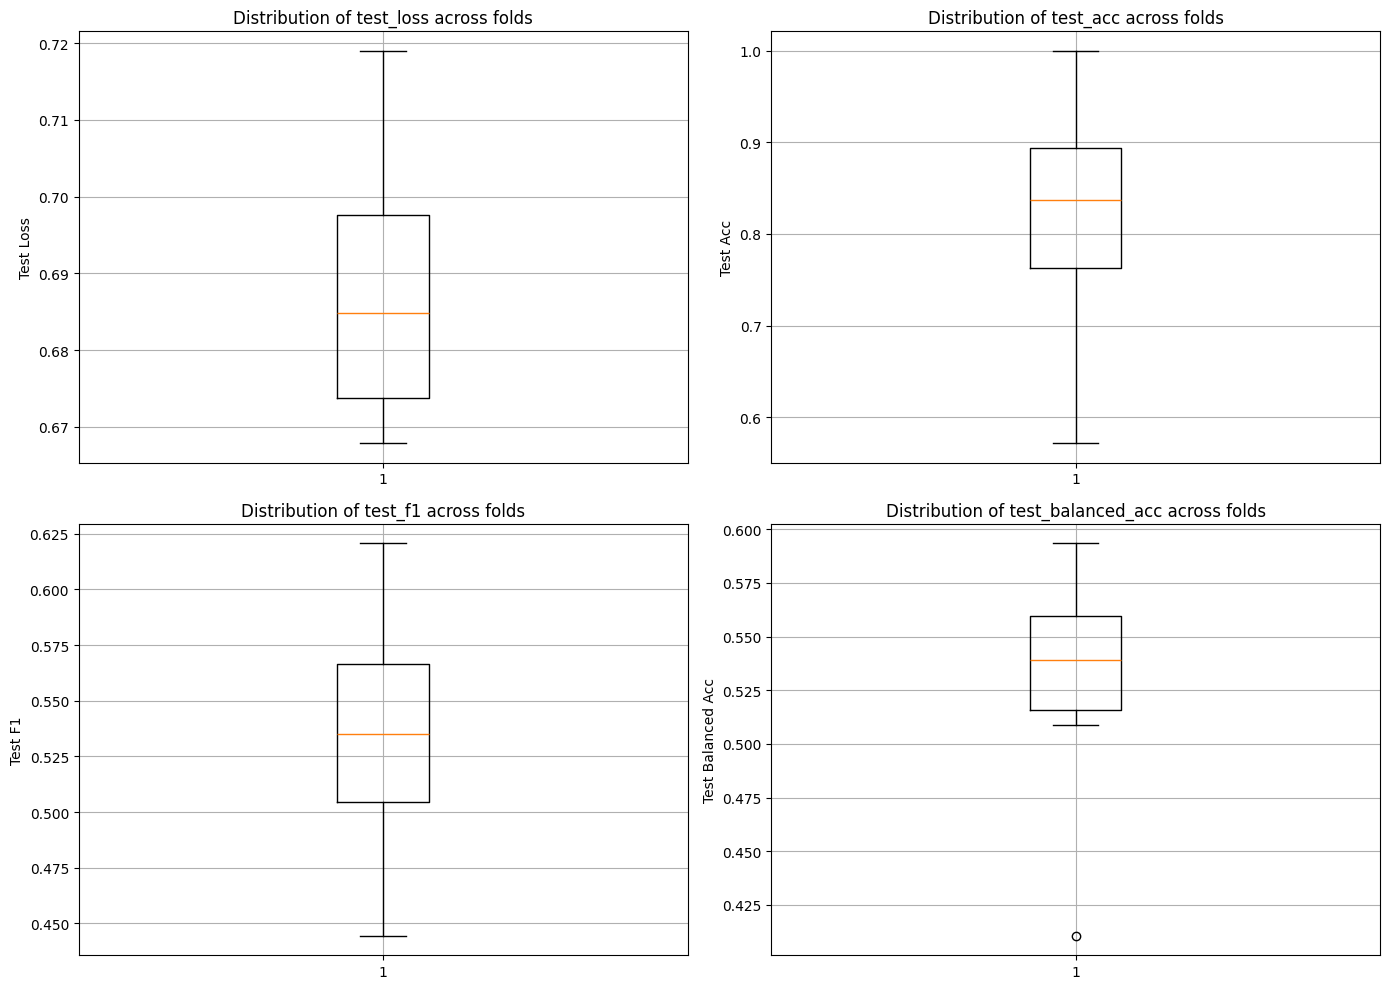

In [42]:
from utils.mlflow_functions import log_SSL_run_to_mlflow

# Define missing arguments
# environmentFlags = {
#     "gdrive": False,
#     "kaggle": False,
#     "linux": True
# }
encoder_type = "barlow_twins"  # or "moco" if using MoCo
log_SSL_run_to_mlflow(
    environmentFlags=environment_flags,
    cfg=cfg,
    model=model_factory(0.001),  # Pass a dummy model to log the run
    class_names=class_names,
    fold_results=fold_results,
    per_fold_metrics=per_fold_metrics,
    hold_out_cv=hold_out_cv,
    test_transforms=test_transforms,
    all_images_paths_np=images_paths_np,
    all_labels_np=labels_np,
    test_images_paths_np=test_images_paths_np,
    test_true_labels_np=test_true_labels_np,
    yaml_path=yaml_path,
    color_transforms=color_transforms,
    model_library=model_library,
    encoder_type= encoder_type,
    pretrained_backbone_path = STABLE_BACKBONE_PATH ,
)

## MAE

In [ ]:
%pip install "lightly[timm]" pytorch-lightning torch torchvision
%pip install --upgrade timm

In [ ]:
from lightly.utils import dependency as _dependency
print(_dependency.timm_vit_available())

In [ ]:
from configs.ConfigLoader import ConfigLoader
from utils.train_functions import (
    train_epoch,
    val_epoch,
    #setup_model,
    print_model_summary,
    plot_cv_results,
    train_epoch_mixUp,
    print_layers,
    oversample_minority,
    undersample_majority,
    freeze_layers_up_to,
    freeze_layers_up_to_progressive_ft,
    train_epoch_vit,
    val_epoch_vit,
    )

from utils.test_functions import evaluate_model
from utils.data_visualization_functions import plot_confusion_matrix, show_misclassified_images, plot_roc_curve

import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/vit.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "monai" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [50]:
###########################################################
# mae_lightning_example.py
# Example script for Masked Autoencoder (MAE) pre-training using PyTorch Lightning,
# Lightly (for data handling and transforms), and TIMM (for ViT models).
# Installation: pip install "lightly[timm]" pytorch-lightning torch torchvision timm
###########################################################
import pytorch_lightning as pl
import torch
from timm.models.vision_transformer import vit_base_patch32_224 # Base Vision Transformer model from TIMM
from torch import nn
from torch.utils.data import DataLoader

# Lightly imports
from lightly.data import LightlyDataset                        # Dataset wrapper for image folders
from lightly.transforms import MAETransform                    # Specific data transforms for MAE
from lightly.models import utils                             # Helper utilities (e.g., masking)
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM # MAE-specific encoder and decoder modules

###########################################################
# 1) Callback to Print Epoch Loss
###########################################################
class PrintEpochLossCallback(pl.Callback):
    """
    A simple PyTorch Lightning Callback that prints the average 'train_loss'
    logged during the epoch to the console after each training epoch finishes.
    Useful for quick monitoring when a full progress bar is disabled.
    """
    def on_train_epoch_end(self, trainer, pl_module):
        # Access metrics logged during the epoch via the trainer
        epoch_loss = trainer.callback_metrics.get("train_loss")
        current_epoch = trainer.current_epoch
        if epoch_loss is not None:
            # Print formatted loss
            print(f"[Epoch {current_epoch}] => train_loss: {epoch_loss:.4f}")
        else:
            # Handle case where loss might not have been logged (e.g., first epoch sanity check)
            print(f"[Epoch {current_epoch}] => train_loss not found in metrics")


###########################################################
# 2) MAE LightningModule Definition
###########################################################
class MAE(pl.LightningModule):
    """
    Implementation of the Masked Autoencoder (MAE) self-supervised learning strategy
    using a Vision Transformer (ViT) backbone from TIMM.

    The core idea is to:
    1. Randomly mask a large portion of input image patches.
    2. Feed only the *visible* (unmasked) patches to the ViT encoder.
    3. Use a lightweight decoder to reconstruct the *original pixels* of the *masked* patches
       based on the encoded representations of the visible patches and learnable mask tokens.
    """

    def __init__(self, mask_ratio: float = 0.75):
        """
        Initializes the MAE model components.

        Args:
            mask_ratio: The fraction of input image patches to randomly mask (hide) during training.
                        Defaults to 0.75 (75%), as used in the original MAE paper.
        """
        super().__init__()
        self.save_hyperparameters() # Saves mask_ratio to hparams

        # --- Encoder Setup ---
        # Load a pre-defined Vision Transformer base model from TIMM library.
        # vit_base_patch32_224: Base-sized ViT, 32x32 patches, expects 224x224 input.
        # Note: weights are not loaded here; we train from scratch or load MAE pre-trained later.
        vit = vit_base_patch32_224(pretrained=False) # Start from scratch for pre-training
        self.patch_size = vit.patch_embed.patch_size[0]

        # Wrap the TIMM ViT with Lightly's MaskedVisionTransformerTIMM.
        # This wrapper allows the ViT encoder to process only a subset of patch tokens (the visible ones).
        self.backbone = MaskedVisionTransformerTIMM(vit=vit)

        # Store the sequence length (number of patches + potentially a class token)
        self.sequence_length = self.backbone.sequence_length # e.g., (224/32)**2 = 49 patches + 1 CLS = 50

        # --- Decoder Setup ---
        # Create the MAE decoder module. It's typically much smaller/shallower than the encoder.
        self.decoder = MAEDecoderTIMM(
            num_patches=vit.patch_embed.num_patches, # Total number of patches (e.g., 49)
            patch_size=self.patch_size,              # Patch size (e.g., 32)
            embed_dim=vit.embed_dim,                 # Encoder's embedding dimension (e.g., 768 for ViT-Base)
            decoder_embed_dim=512,                   # Decoder's embedding dimension (can be smaller)
            decoder_depth=1,                         # Number of transformer blocks in the decoder (shallow)
            decoder_num_heads=16,                    # Number of attention heads in the decoder
            mlp_ratio=4.0,                           # MLP expansion ratio in decoder blocks
            proj_drop_rate=0.0,                      # Dropout rates (often disabled in decoder)
            attn_drop_rate=0.0,
        )

        # --- Loss Function ---
        # MAE reconstructs raw pixel values of the masked patches.
        # Mean Squared Error (MSE) loss is used to measure the reconstruction quality.
        self.criterion = nn.MSELoss()

    def forward_encoder(self, images: torch.Tensor, idx_keep: torch.Tensor = None) -> torch.Tensor:
        """
        Runs the forward pass through the MAE encoder (ViT backbone).

        Args:
            images: Batch of input images (B, C, H, W).
            idx_keep: Tensor containing the indices of the patches to *keep* (process).
                      If None, all patches are processed. Shape: (B, num_kept_patches).

        Returns:
            Tensor containing the encoded representations of the kept patches.
            Shape: (B, num_kept_patches, encoder_embed_dim).
        """
        return self.backbone.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded: torch.Tensor, idx_keep: torch.Tensor, idx_mask: torch.Tensor) -> torch.Tensor:
        """
        Runs the forward pass through the MAE decoder to reconstruct masked patches.

        Args:
            x_encoded: Encoded representations of the visible patches from the encoder.
                       Shape: (B, num_kept_patches, encoder_embed_dim).
            idx_keep: Indices of the patches that were *kept* (visible) by the encoder.
                      Shape: (B, num_kept_patches).
            idx_mask: Indices of the patches that were *masked* (hidden) by the encoder.
                      Shape: (B, num_masked_patches).

        Returns:
            Tensor containing the predicted pixel values for the *masked* patches.
            Shape: (B, num_masked_patches, patch_size*patch_size*num_channels).
        """
        batch_size = x_encoded.shape[0]

        # 1. Project the encoded visible patches to the decoder's embedding dimension.
        x_decode = self.decoder.embed(x_encoded) # (B, num_kept, decoder_embed_dim)

        # 2. Create the full sequence input for the decoder:
        #    - Start with learnable mask tokens for all positions.
        #    - Place the embedded visible patches back into their original positions.
        # Create placeholder mask tokens for the full sequence length.
        # Shape: (B, sequence_length, decoder_embed_dim)
        x_masked = utils.repeat_token(self.decoder.mask_token, (batch_size, self.sequence_length))
        # Use `set_at_index` to insert the visible patch embeddings `x_decode`
        # at the `idx_keep` positions within the `x_masked` tensor.
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))

        # 3. Pass the full sequence (visible patches + mask tokens) through the decoder's transformer blocks.
        # Shape: (B, sequence_length, decoder_embed_dim)
        x_decoded = self.decoder.decode(x_masked)

        # 4. Select only the decoder outputs corresponding to the *originally masked* patch positions.
        # Shape: (B, num_masked_patches, decoder_embed_dim)
        x_pred = utils.get_at_index(x_decoded, idx_mask)

        # 5. Project the decoder outputs for masked patches back into pixel space.
        # Shape: (B, num_masked_patches, patch_size*patch_size*num_channels)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def training_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        """
        Performs a single training step for MAE.
        """
        # MAE typically uses only one view per image in a batch, but LightlyDataset
        # might return tuples. We expect the actual images to be the first element.
        views, _, _ = batch # Assuming LightlyDataset structure: (views_tuple), labels, fnames
        images = views[0]   # Get the actual image tensor: shape (B, C, H, W)
        batch_size = images.shape[0]

        # 1. Determine which patches to mask and which to keep.
        # `random_token_mask` generates boolean masks or indices based on the mask_ratio.
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length), # (Batch Size, Num Patches + CLS Token)
            mask_ratio=self.hparams.mask_ratio,      # Use the stored hyperparameter
            device=images.device,
        )

        # 2. Encode the visible patches using the ViT backbone.
        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)

        # 3. Decode and predict the pixel values for the masked patches.
        x_pred = self.forward_decoder(x_encoded, idx_keep, idx_mask)

        # 4. Prepare the target: Get the original pixel values of the masked patches.
        # `patchify` converts the original images into flattened patches.
        patches = utils.patchify(images, self.patch_size) # (B, num_patches, patch_size*patch_size*C)
        # Select the original patches corresponding to the masked indices.
        # Note: `idx_mask` might include an index for the CLS token position if the encoder uses one.
        # `patchify` output does not have a CLS token patch, so we might need to adjust indices
        # if the CLS token is index 0. Lightly's `utils.get_at_index` might handle this,
        # but subtracting 1 is common if idx_mask assumes a prepended CLS token. Check MaskedVisionTransformerTIMM details.
        # Assuming idx_mask needs offset if CLS token exists:
        target = utils.get_at_index(patches, idx_mask - 1 if self.backbone.vit.cls_token is not None else idx_mask)

        # 5. Calculate the reconstruction loss (MSE) between predicted and target patches.
        loss = self.criterion(x_pred, target)

        # Log the loss for monitoring (average over epoch).
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True) # Added prog_bar
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Sets up the optimizer for training. AdamW is commonly used for ViT/MAE.
        Learning rate might need tuning based on dataset and training duration.
        Consider adding a learning rate scheduler (e.g., Cosine Annealing with Warmup)
        for longer training runs to improve stability and performance.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=1.5e-4, weight_decay=0.05) # Added weight decay common for MAE
        # Example of adding a scheduler (optional, adjust parameters):
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6)
        # return [optimizer], [scheduler]
        return optimizer


###########################################################
# 3) Main Function to Set Up and Run Training
###########################################################

# --- Configuration ---
DATA_DIR = f"/home/zano/Documents/TESI/{num_input_channels}c_MIP_new/ALL"
INPUT_SIZE = 224 # Input size expected by the ViT model (vit_base_patch32_224)
BATCH_SIZE = 16  # Adjust based on GPU memory (e.g., 16, 32, 64)
NUM_WORKERS = 4  # Number of parallel workers for data loading
MAX_EPOCHS = 250  # Number of epochs to train for (MAE often needs many more, e.g., 100+)
SAVE_PATH = "mae_backbone.pth" # Path to save the trained encoder weights

# 1) Create the MAE model instance
print("Initializing MAE model...")
model = MAE(mask_ratio=0.75) # Can adjust mask_ratio here if needed

# 2) Create the specific MAE data transform
# This handles resizing to INPUT_SIZE, normalization (usually ImageNet stats),
# and any minimal augmentations suitable for MAE.
print(f"Setting up MAETransform with input size {INPUT_SIZE}...")
transform = MAETransform(input_size=INPUT_SIZE)

# 3) Create the LightlyDataset
# This dataset automatically finds images in the specified input directory.
print(f"Loading dataset from: {DATA_DIR}")
dataset = LightlyDataset(input_dir=DATA_DIR, transform=transform)
print(f"Dataset size: {len(dataset)}")

# 4) Create the PyTorch DataLoader
# Handles batching, shuffling, and parallel data loading.
print(f"Creating DataLoader with batch size {BATCH_SIZE}...")
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Shuffle data each epoch for better training
    drop_last=True,    # Drop the last incomplete batch
    num_workers=NUM_WORKERS,
    persistent_workers=True if NUM_WORKERS > 0 else False # Can speed up epoch start
)

# 5) Configure the PyTorch Lightning Trainer
# Manages the training loop, GPU/CPU placement, callbacks, logging, etc.
print(f"Configuring PyTorch Lightning Trainer for {MAX_EPOCHS} epochs...")
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu", # Use GPU if available
    devices=1,                                         # Number of devices to use (e.g., 1 GPU)
    enable_progress_bar=False,                         # Disable default progress bar as we use a custom callback
    callbacks=[PrintEpochLossCallback()],              # Use the custom callback to print loss per epoch
    precision="16-mixed"                               # Enable Automatic Mixed Precision (AMP) for faster training
)

# 6) Start the MAE pre-training process
print("Starting MAE pre-training...")
trainer.fit(model=model, train_dataloaders=dataloader)
print("MAE pre-training finished.")

# 7) Save the trained encoder backbone state dictionary
# We only save the `backbone` (the ViT encoder), as the decoder is usually discarded.
print(f"Saving trained MAE encoder backbone to: {SAVE_PATH}")
torch.save(model.backbone.state_dict(), SAVE_PATH)
print("Backbone saved successfully.")

The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.


Initializing MAE model...


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | backbone  | MaskedVisionTransformerTIMM | 88.2 M | train
1 | decoder   | MAEDecoderTIMM              | 5.1 M  | train
2 | criterion | MSELoss                     | 0   

Setting up MAETransform with input size 224...
Loading dataset from: /home/zano/Documents/TESI/3c_MIP_new/ALL
Dataset size: 152
Creating DataLoader with batch size 16...
Configuring PyTorch Lightning Trainer for 250 epochs...
Starting MAE pre-training...


The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


[Epoch 0] => train_loss: 2.9500
[Epoch 1] => train_loss: 1.3466
[Epoch 2] => train_loss: 0.4620
[Epoch 3] => train_loss: 0.1159
[Epoch 4] => train_loss: 0.0308
[Epoch 5] => train_loss: 0.0156
[Epoch 6] => train_loss: 0.0117
[Epoch 7] => train_loss: 0.0091
[Epoch 8] => train_loss: 0.0064
[Epoch 9] => train_loss: 0.0071
[Epoch 10] => train_loss: 0.0059
[Epoch 11] => train_loss: 0.0062
[Epoch 12] => train_loss: 0.0057
[Epoch 13] => train_loss: 0.0070
[Epoch 14] => train_loss: 0.0062
[Epoch 15] => train_loss: 0.0066
[Epoch 16] => train_loss: 0.0064
[Epoch 17] => train_loss: 0.0058
[Epoch 18] => train_loss: 0.0053
[Epoch 19] => train_loss: 0.0059
[Epoch 20] => train_loss: 0.0061
[Epoch 21] => train_loss: 0.0053
[Epoch 22] => train_loss: 0.0058
[Epoch 23] => train_loss: 0.0059
[Epoch 24] => train_loss: 0.0061
[Epoch 25] => train_loss: 0.0064
[Epoch 26] => train_loss: 0.0064
[Epoch 27] => train_loss: 0.0056
[Epoch 28] => train_loss: 0.0058
[Epoch 29] => train_loss: 0.0060
[Epoch 30] => train_


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [52]:
#  8) Example: How to load the pre-trained encoder for a downstream task (e.g., classification)
print("\nExample: Loading the saved backbone for downstream use:")
# First, create the *same architecture* as the saved backbone
vit_for_downstream = vit_base_patch32_224(pretrained=False) # Important: use same ViT config
mae_encoder = MaskedVisionTransformerTIMM(vit=vit_for_downstream)
print(" - Created encoder architecture.")
# Second, load the saved state dictionary into the architecture instance
state_dict = torch.load(SAVE_PATH)
mae_encoder.load_state_dict(state_dict)
mae_encoder.eval() # Set to evaluation mode
print(f" - Loaded state dict from '{SAVE_PATH}' into encoder.")
# Now `encoder_architecture` can be used as the backbone in a downstream model.


Example: Loading the saved backbone for downstream use:
 - Created encoder architecture.
 - Loaded state dict from 'mae_backbone.pth' into encoder.
 - Created encoder architecture.
 - Loaded state dict from 'mae_backbone.pth' into encoder.


In [56]:
## DOWNSTREAM FINE TUNING USING THE ENCODER USING LIGHTLY ND LIGHTNING
import torch.nn as nn
import pytorch_lightning as pl
import timm
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from utils.train_functions import MLPClassifierHead, LinearProbeHead
# For MLflow logging
from pytorch_lightning.loggers import MLFlowLogger
from utils.directory_functions import get_tracking_uri

##############################
# 1) A Simple Labeled Dataset
##############################
# Example: Suppose you have a folder of labeled images in a structure like:
#   data/
#     PD/*.png
#     MSA/*.png
# Or you have a list of image paths and label arrays.
# This is a "toy" version of a custom dataset.
class MyLabeledDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image
        path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


##############################
# 2) MAEFinetuneModule
##############################
from sklearn.metrics import balanced_accuracy_score
class MAEFinetuneModule(pl.LightningModule):
    """
    Loads the MAE-pretrained ViT backbone, attaches a linear classifier,
    and trains with cross-entropy for a labeled classification task.
    Includes training, validation, and test steps.
    """

    def __init__(self, mae_weights_path, num_classes=2, freeze_backbone=False):
        """
        Args:
            mae_weights_path: Path to your 'mae_backbone.pth' from MAE pretraining.
            num_classes: How many classes to predict (e.g. 2 for PD vs. MSA).
            freeze_backbone: Whether to freeze the ViT backbone weights.
        """
        super().__init__()

        # 1) Build a timm ViT model matching your MAE config
        vit = timm.create_model(
            "vit_base_patch32_224",  # must match your MAE config
            pretrained=False,
            num_classes=0  # no classifier head
        )
        vit.has_cls_token = True  # let it know there's a class token

        # 2) This is our backbone (i.e., the ViT part)
        self.vit_backbone = vit

        # 3) Load the MAE-pretrained backbone weights
        #    from "mae_backbone.pth"
        state_dict = torch.load(mae_weights_path, map_location="cpu")
        self.vit_backbone.load_state_dict(state_dict, strict=False)

        # 4) Optionally freeze the backbone
        if freeze_backbone:
            for param in self.vit_backbone.parameters():
                param.requires_grad = False

        # 5) Attach a classification head (suppose embed_dim=768)
        self.classifier = LinearProbeHead(768, num_classes)
        #   self.classifier = nn.Linear(768, num_classes)

        # 6) Loss function for classification
        self.criterion = nn.CrossEntropyLoss()
        # self.val_balanced_acc = BalancedAccuracy(num_classes=num_classes)
        # self.test_balanced_acc = BalancedAccuracy(num_classes=num_classes)

    def forward(self, x):
        """
        Forward pass: encode with ViT, then pass through classifier.
        """
        feats = self.vit_backbone(x)  # shape: (B, 768)
        logits = self.classifier(feats)  # shape: (B, num_classes)
        return logits

    def configure_optimizers(self):
        # Typical choice for finetuning
        return torch.optim.AdamW(self.parameters(), lr=1e-4)

    ##############################
    # Training / Validation / Test
    ##############################
    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        # bacc = self.val_balanced_acc(logits, labels)
        # self.log("val_balanced_acc", bacc, on_epoch=True, sync_dist=True)
        self.log("val_loss", loss, on_epoch=True, sync_dist=True)
        self.log("val_acc", acc, on_epoch=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", acc, on_epoch=True)
        return loss


##############################
# 3) Full Example Pipeline
##############################
# A basic transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

dataset_all = MyLabeledDataset(images_paths_np, labels_np, transform=transform)

# 2) Split into train / val / test
train_size = int(0.7 * len(dataset_all))
print(f"Train size: {train_size}")
val_size = int(0.15 * len(dataset_all))
print(f"Val size: {val_size}")
test_size = len(dataset_all) - train_size - val_size
print(f"Test size: {test_size}")
print(f"Total size: {train_size + val_size + test_size}")

dataset_train, dataset_val, dataset_test = random_split(
    dataset_all, [train_size, val_size, test_size]
)

train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=8, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=8, shuffle=False)

# 3) Create the MAE Finetune model
model = MAEFinetuneModule(
    mae_weights_path="mae_backbone.pth", 
    num_classes=2,
    freeze_backbone=False
)

# 4) Setup MLflow logger
# You need: pip install mlflow
# Then run "mlflow ui" or set up your remote tracking server
mlflow_logger = MLFlowLogger(
    experiment_name="PDvsMSA-FineTune",  # or any 
    run_name="MAE_FineTune_Experiment",
    tracking_uri= get_tracking_uri(gdrive,kaggle=False,linux=True)        # logs to local ./mlruns folder
)
# This will log metrics like train_loss, val_loss, etc. to MLflow.

# 5) Print some metrics each epoch (optional)
class PrintTrainValCallback(pl.Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        """
        Called after the validation loop ends each epoch,
        so we have both train and val metrics available in trainer.callback_metrics.
        """
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch

        # Retrieve both train and val metrics with fallback values
        train_loss = metrics.get("train_loss", None)
        train_acc = metrics.get("train_acc", None)
        val_loss = metrics.get("val_loss", None)
        val_acc = metrics.get("val_acc", None)
        

        # Build a single line of output with safe formatting
        train_loss_str = f"{train_loss:.4f}" if train_loss is not None else "N/A"
        train_acc_str = f"{train_acc:.4f}" if train_acc is not None else "N/A"
        val_loss_str = f"{val_loss:.4f}" if val_loss is not None else "N/A"
        val_acc_str = f"{val_acc:.4f}" if val_acc is not None else "N/A"
        
        msg = (
            f"[Epoch {epoch}] "
            f"train_loss: {train_loss_str}, train_acc: {train_acc_str}, "
            f"val_loss: {val_loss_str}, val_acc: {val_acc_str}"
        )
        print(msg)


trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=mlflow_logger,                 # enable MLflow logging
    enable_progress_bar=True,             # show TQDM bar or set to False if you prefer
    callbacks=[PrintTrainValCallback()]
)

# 6) Train
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# 7) Test
trainer.test(model, dataloaders=test_loader)

Train size: 93
Val size: 19
Test size: 21
Total size: 133


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name

you are on linux


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


[Epoch 0] train_loss: N/A, train_acc: N/A, val_loss: 0.6895, val_acc: 0.5625


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 0] train_loss: 0.7931, train_acc: 0.6000, val_loss: 0.6310, val_acc: 0.6842


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 1] train_loss: 0.6486, train_acc: 1.0000, val_loss: 0.6394, val_acc: 0.6842


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 2] train_loss: 0.6681, train_acc: 0.6000, val_loss: 0.7640, val_acc: 0.3158


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 3] train_loss: 0.7649, train_acc: 0.2000, val_loss: 0.6688, val_acc: 0.6842


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 4] train_loss: 0.9253, train_acc: 0.4000, val_loss: 0.6344, val_acc: 0.6842


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 5] train_loss: 0.6837, train_acc: 0.6000, val_loss: 0.7879, val_acc: 0.3158


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 6] train_loss: 0.8448, train_acc: 0.4000, val_loss: 0.6163, val_acc: 0.6842


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 7] train_loss: 0.5608, train_acc: 0.8000, val_loss: 0.6562, val_acc: 0.6842


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 8] train_loss: 0.4058, train_acc: 1.0000, val_loss: 0.6962, val_acc: 0.5263


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 9] train_loss: 0.4892, train_acc: 0.8000, val_loss: 0.6419, val_acc: 0.6842



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
import collections
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm # Make sure timm is installed
import copy
import numpy as np # Added for mean calculation later
import matplotlib.pyplot as plt # Added for plot later
import torchvision.transforms as T # Assuming you might use torchvision transforms

# Import your custom utility functions
from utils.train_functions import MLPClassifierHead, LinearProbeHead # Assuming this defines your classifier head
from utils.train_functions import nested_cv_stratified_by_patient # Your nested CV function
from utils.data_visualization_functions import generate_cv_results_figure # Your plotting function

# --- Configuration ---
MAE_BACKBONE_PATH = "mae_backbone.pth" # Path to your trained MAE weights file
FEATURE_DIM = 768                # Expected output dimension of ViT-Base CLS token (embed_dim)
NUM_CLASSES = 2                  # Number of downstream classes for your specific task
INPUT_SIZE = 224                 # Input image size (HxW) the MAE ViT was pre-trained on and expects

def load_mae_vit_backbone_state_dict(
    model: nn.Module,
    checkpoint_path: str,
    prefix: str = "vit."
) -> None:
    """
    Loads weights from a MAE pre-trained backbone checkpoint into a standard TIMM ViT model.

    Handles the common case where MAE training saves weights with a model-specific
    prefix (e.g., "vit.") which needs to be removed before loading into a base TIMM model.
    It also skips weights that don't belong in the base model (like mask_token or head layers
    if the target model has num_classes=0).

    Args:
        model (nn.Module): The target TIMM ViT model instance (e.g., created with
                           timm.create_model(..., num_classes=0)) into which the
                           weights should be loaded. This model is modified in-place.
        checkpoint_path (str): Path to the .pth file containing the saved state_dict
                               from MAE pre-training (typically model.backbone.state_dict()).
        prefix (str, optional): The prefix expected in the keys of the checkpoint's
                                state_dict that should be removed. Defaults to "vit.".
    """
    # print(f"\n--- Loading MAE Backbone Weights ---")
    # print(f"Target Model Type: {type(model).__name__}")
    # print(f"Loading from Checkpoint: {checkpoint_path}")
    # print(f"Expecting prefix in checkpoint keys: '{prefix}'")

    # --- Load the state dictionary from the file ---
    try:
        # Load to CPU first for flexibility and to avoid GPU memory issues during processing
        checkpoint_state_dict = torch.load(checkpoint_path, map_location="cpu")
        # print(f"  Successfully loaded state dictionary from file.")
    except FileNotFoundError:
        # print(f"  ERROR: Checkpoint file not found at '{checkpoint_path}'. Cannot load weights.")
        # Depending on requirements, you might want to raise the error instead of just printing
        # raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
        return # Exit the function if file not found
    except Exception as e:
        # print(f"  ERROR: Failed to load checkpoint file '{checkpoint_path}': {e}")
        # raise e
        return # Exit on other loading errors

    # --- Process the loaded state dictionary ---
    processed_state_dict = collections.OrderedDict() # Use OrderedDict to maintain key order potentially
    target_model_keys = set(model.state_dict().keys()) # Get keys expected by the target model

    # print("  Processing checkpoint keys...")
    keys_processed_count = 0
    keys_skipped_prefix = 0
    keys_skipped_mismatch = 0

    for k, v in checkpoint_state_dict.items():
        # Check if the key starts with the expected prefix
        if k.startswith(prefix):
            # Remove the prefix to get the corresponding key in the target model
            new_key = k[len(prefix):]

            # IMPORTANT: Check if this new key actually exists in the target model
            if new_key in target_model_keys:
                processed_state_dict[new_key] = v
                # print(f"    Mapping '{k}' -> '{new_key}'") # Uncomment for detailed debug
                keys_processed_count += 1
            else:
                # This key (e.g., vit.head.weight) exists in the checkpoint but not
                # in the target model (which has num_classes=0). Skip it.
                # print(f"    Skipping key '{k}': Corresponding key '{new_key}' not found in target model.") # Uncomment for detailed debug
                keys_skipped_mismatch += 1
        else:
            # This key doesn't have the prefix. Skip it as it likely belongs to
            # the MAE wrapper (e.g., 'mask_token') or is unexpected.
            # print(f"    Skipping key '{k}': Does not have expected prefix '{prefix}'.") # Uncomment for detailed debug
            keys_skipped_prefix += 1

    print(f"  Processing complete:")
    print(f"    {keys_processed_count} keys mapped and kept.")
    print(f"    {keys_skipped_mismatch} prefixed keys skipped (target mismatch, e.g., head layers).")
    print(f"    {keys_skipped_prefix} non-prefixed keys skipped (e.g., mask_token).")

    if keys_processed_count == 0:
        # print("  ERROR: No keys were successfully mapped from the checkpoint to the target model!")
        # print("         Please check the `prefix` argument and the checkpoint file contents.")
        return # Exit if no keys were useful

    # --- Load the processed state dictionary into the target model ---
    print("  Attempting to load processed state dictionary into the target model...")
    try:
        # Use strict=True because we expect a perfect match after processing
        missing_keys, unexpected_keys = model.load_state_dict(processed_state_dict, strict=True)

        # These should ideally be empty if processing was correct and strict=True worked
        if missing_keys:
             print(f"  ERROR: Missing keys AFTER processing: {missing_keys}")
        if unexpected_keys:
             print(f"  ERROR: Unexpected keys AFTER processing: {unexpected_keys}")

        if not missing_keys and not unexpected_keys:
             print("  Successfully loaded processed weights into the target model.")

    except Exception as e:
        print(f"  ERROR: Failed to load processed state_dict into model: {e}")
        print(f"         Mapped keys ({len(processed_state_dict)}): {list(processed_state_dict.keys())[:5]}...")
        print(f"         Target keys ({len(target_model_keys)}): {list(target_model_keys)[:5]}...")

    print(f"--- Finished Loading MAE Backbone Weights ---")
    
# --- Lightning Module for ViT Fine-tuning ---
class ViTFinetuneModule(pl.LightningModule):
    """
    PyTorch Lightning module specifically for fine-tuning a MAE pre-trained ViT backbone.
    It handles:
    1. Loading the ViT architecture (via TIMM).
    2. Loading the pre-trained MAE backbone weights.
    3. Attaching a classification head (MLP).
    4. Freezing the backbone (optional).
    5. Defining the forward pass, loss, optimizer, and train/val/test steps.
    Designed to be instantiated by the `model_factory` for use with `nested_cv_stratified_by_patient`.
    """
    def __init__(self, mae_weights_path: str, num_classes: int, freeze_backbone: bool, lr: float):
        """
        Args:
            mae_weights_path (str): Path to the '.pth' file containing MAE backbone weights.
            num_classes (int): Number of target classes for the downstream task.
            freeze_backbone (bool): If True, sets `requires_grad=False` for backbone parameters.
            lr (float): Learning rate for the optimizer.
        """
        super().__init__()
        # Save hyperparameters (num_classes, freeze_backbone, lr) to self.hparams
        # Makes them accessible later (e.g., self.hparams.lr) and logs them automatically.
        # We don't save mae_weights_path as it's used only during init here.
        self.save_hyperparameters("num_classes", "freeze_backbone", "lr")
        # 1. Build ViT Backbone Architecture using TIMM
        # Create the specified ViT model ('vit_base_patch32_224').
        # `pretrained=False`: Do not load ImageNet weights, we'll load MAE weights.
        # `num_classes=0`: Remove the default classifier head from the TIMM model.
        #                  This typically makes the model output the CLS token embedding.
        # print("  Initializing ViT backbone architecture (timm)...")
        vit = timm.create_model(
            "vit_base_patch32_224",
            pretrained=False,
            num_classes=0 # No classifier head, we will add our own later
        )
        self.vit_backbone = vit
        # Get the embedding dimension directly from the loaded TIMM model (robust)
        self.feature_dim = self.vit_backbone.embed_dim
        # print(f"  ViT backbone embedding dimension: {self.feature_dim}") # Should be 768

        # 2. Load MAE Pre-trained Weights into the Backbone
        load_mae_vit_backbone_state_dict(
            model=self.vit_backbone,         # Pass the model instance here
            checkpoint_path=mae_weights_path # Pass the path to the weights file
            # prefix="vit." # Default is "vit.", change if your MAE model used a different internal name
        )

        # 3. Freeze Backbone (Optional)
        # If `freeze_backbone` is True, iterate through backbone parameters and disable gradient calculation.
        if self.hparams.freeze_backbone:
            # print("  Freezing MAE backbone parameters (requires_grad=False).")
            for param in self.vit_backbone.parameters():
                param.requires_grad = False
            # Set the frozen backbone to evaluation mode (disables dropout, uses running stats in BatchNorm if any)
            self.vit_backbone.eval()

        # 4. Attach Classification Head
        # Use the imported MLPClassifierHead utility function.
        # It needs the backbone's output feature dimension (768) and the number of classes.
        # print(f"  Attaching MLPClassifierHead (input_dim={self.feature_dim}, num_classes={self.hparams.num_classes}).")
        #   self.classifier = MLPClassifierHead(self.feature_dim, self.hparams.num_classes)
        self.classifier = LinearProbeHead(self.feature_dim, self.hparams.num_classes)

        # 5. Define Loss Function
        # Standard Cross-Entropy Loss for multi-class classification.
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Defines the forward pass of the model. """
        # Pass input `x` through the ViT backbone.
        # For timm ViTs with num_classes=0, this call typically returns the CLS token embedding.
        # Expected output shape: (batch_size, embed_dim) -> (B, 768)
        features = self.vit_backbone(x)
        # Pass the extracted features (CLS token embedding) through the classifier head.
        logits = self.classifier(features)
        # Return the final logits (raw scores for each class).
        return logits

    def configure_optimizers(self):
        """ Defines the optimizer and optionally learning rate schedulers. """
        # Use AdamW optimizer, common for Transformers.
        # `filter(lambda p: p.requires_grad, self.parameters())`: Ensures only parameters
        # that require gradients (i.e., not frozen) are passed to the optimizer.
        print(f"  Configuring AdamW optimizer with LR={self.hparams.lr}.")
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()),
                                       lr=self.hparams.lr)
        # --- Optional: Add LR Scheduler ---
        # Example: Reduce learning rate when validation loss plateaus
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": {
        #         "scheduler": scheduler,
        #         "monitor": "val_loss", # Metric to monitor for scheduler step
        #         "interval": "epoch",   # Check metric at the end of each epoch
        #         "frequency": 1
        #     },
        # }
        # --- End Optional Scheduler ---
        return optimizer # Return only optimizer if no scheduler is used

    # --- Training, Validation, and Test Steps ---
    # These define the logic executed during the respective phases of training.

    def training_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        """ Performs one step of training. """
        # Assumes batch is a dictionary with 'image' and 'label' keys. Adapt if different.
        images, labels = batch["image"], batch["label"]
        # Get model output (logits) by calling the forward method
        logits = self(images)
        # Calculate the loss
        loss = self.criterion(logits, labels)
        # Calculate accuracy
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        # Log metrics using Lightning's self.log method
        # `on_epoch=True`: aggregates over the epoch. `prog_bar=True`: shows in progress bar.
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True, logger=True)
        return loss # Return the loss tensor

    def validation_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        """ Performs one step of validation. """
        images, labels = batch["image"], batch["label"]
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        # `sync_dist=True`: aggregates metrics correctly across multiple GPUs (if used).
        self.log("val_loss", loss, on_epoch=True, sync_dist=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, sync_dist=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        """ Performs one step of testing. """
        images, labels = batch["image"], batch["label"]
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("test_loss", loss, on_epoch=True, logger=True)
        self.log("test_acc", acc, on_epoch=True, logger=True)
        return loss

# --- Model Factory Function ---
# This function is designed to be passed to `nested_cv_stratified_by_patient`.
# It creates a fresh instance of the `ViTFinetuneModule` for each call.
freeze_backbone = False # Set to True if you want to freeze the backbone during fine-tuning
def model_factory(lr: float) -> pl.LightningModule:
    """
    Factory function that creates and returns an instance of ViTFinetuneModule.
    Called by the nested CV loop, potentially with different learning rates.

    Args:
        lr (float): The learning rate to use for this specific model instance.

    Returns:
        pl.LightningModule: An initialized ViTFinetuneModule instance.
    """
    print(f"  model_factory called: Creating ViTFinetuneModule instance with LR={lr}")
    # Instantiate the Lightning module, passing necessary arguments.
    # Weight loading happens inside ViTFinetuneModule's __init__.
    model = ViTFinetuneModule(
        mae_weights_path=MAE_BACKBONE_PATH,
        num_classes=NUM_CLASSES,
        freeze_backbone=freeze_backbone,  # Standard practice: start fine-tuning with backbone frozen
        lr=lr                  # Pass the learning rate from the factory argument
    )
    # No need for copy.deepcopy since a new object is created on each call.
    return model

# --- Prepare for Nested CV Call ---
# print("\nSetup complete for Nested CV using MAE ViT backbone.")
# print(f"-> Ensure input images are transformed to {INPUT_SIZE}x{INPUT_SIZE}.")
# print(f"-> Ensure classifier MLP head ({type(MLPClassifierHead).__name__}) is defined correctly.")
# print(f"-> Classifier head expects input dimension {FEATURE_DIM}.")

# Define required data transformations for the downstream task.

normalization_params = {
        "subtrahend": [0.485, 0.456, 0.406],
        "divisor": [0.229, 0.224, 0.225],
    }

# **CRITICAL**: Must resize/crop images to INPUT_SIZE (e.g., 224x224).
# **CRITICAL**: Must include normalization (e.g., ImageNet stats) if the ViT expects it.
print(f"Defining example downstream transforms for input size {INPUT_SIZE}x{INPUT_SIZE}...")
from classes.CustomTiffFileReader import CustomTiffFileReader

train_transforms_224 = Compose([
            CustomTiffFileReader(keys=["image"]),
            EnsureTyped(keys=['image', 'label'], data_type="tensor", dtype=torch.float32),
            Resized(keys="image", spatial_size=(224,224), mode='bilinear', size_mode='all'),
            # CenterSpatialCropd(keys="image", roi_size=(224,224)),
            ScaleIntensityd(keys="image"),  # Scale to [0.0, 1.0]
            NormalizeIntensityd(
                keys=["image"],
                subtrahend=normalization_params["subtrahend"],
                divisor=normalization_params["divisor"],
                channel_wise=True
            ),
        ])

val_transforms_224 = Compose([
            CustomTiffFileReader(keys=["image"]),
            EnsureTyped(keys=['image', 'label'], data_type="tensor", dtype=torch.float32),
            Resized(keys="image", spatial_size=(224,224), mode='bilinear', size_mode='all'),
            # CenterSpatialCropd(keys="image", roi_size=(224,224)),
            ScaleIntensityd(keys="image"),  # Scale to [0.0, 1.0]
            NormalizeIntensityd(
                keys=["image"],
                subtrahend=normalization_params["subtrahend"],
                divisor=normalization_params["divisor"],
                channel_wise=True
            ),
            ])
                
# --- Execute Nested Cross-Validation ---
print("\nStarting nested cross-validation...")
# Replace placeholder variables (df, cfg, labels_np, etc.) with your actual data/config.
# Make sure these variables are defined before this call.
# Example placeholder values (replace them!
# Ensure all required variables are loaded/defined before this call
if any(x is None for x in [df, cfg, labels_np, pat_labels, unique_pat_ids]):
     print("WARNING: One or more placeholder variables (df, cfg, etc.) are None.")
     print("Skipping nested_cv_stratified_by_patient call.")
else:
    per_fold_metrics, fold_results = nested_cv_stratified_by_patient(
        df=df,                           # DataFrame with image paths, labels, patient IDs
        cfg=cfg,                         # Configuration object
        model_factory=model_factory,     # Use the factory returning ViTFinetuneModule
        labels_np=labels_np,             # Image-level labels
        pat_labels=pat_labels,           # Patient-level labels for outer fold stratification
        unique_pat_ids=unique_pat_ids,   # Unique patient IDs corresponding to pat_labels
        train_transforms=train_transforms_224, # Pass the 224x224 transforms
        val_transforms=val_transforms_224,     # Pass the 224x224 transforms
        pretrained_weights=None,         # CRITICAL: Set to None as weights are loaded internally
        class_names=class_names,         # List of class names for evaluation/plotting
        model_manager=None               # Set to None if not using a separate model manager
    )

    print("\nNested Cross-Validation Finished.")

    # --- Process and Display Results ---
    print("Generating results figure...")
    # Ensure generate_cv_results_figure and plt are imported and work correctly
    try:
        fold_box_plot_fig = generate_cv_results_figure(fold_results, 'test')
        plt.show() # Display the plot
    except Exception as plot_e:
        print(f"Error generating or displaying plot: {plot_e}")


    print("\nCalculating mean metrics across outer folds...")
    # Calculate average metrics across all folds for summary report
    mean_test_acc = np.mean([r["test_acc"] for r in fold_results])
    mean_test_loss = np.mean([r["test_loss"] for r in fold_results])
    mean_test_f1 = np.mean([r["test_f1"] for r in fold_results])
    mean_test_balanced_acc = np.mean([r["test_balanced_acc"] for r in fold_results])
    mean_test_recall = np.mean([r["test_recall"] for r in fold_results])
    mean_test_precision = np.mean([r["test_precision"] for r in fold_results]) # Check if precision is calculated/returned

    # Print summary metrics
    print(f"\nMean Test Loss across outer folds: {mean_test_loss:.4f}")
    print(f"Mean Test Acc across outer folds: {mean_test_acc:.4f}")
    print(f"Mean Test F1 across outer folds: {mean_test_f1:.4f}")
    print(f"Mean Test Balanced Acc across outer folds: {mean_test_balanced_acc:.4f}")
    print(f"Mean Test Precision across outer folds: {mean_test_precision:.4f}")
    print(f"Mean Test Recall across outer folds: {mean_test_recall:.4f}")

  model_factory called: Creating ViTFinetuneModule instance with LR=0.001
  Processing complete:
    150 keys mapped and kept.
    2 prefixed keys skipped (target mismatch, e.g., head layers).
    1 non-prefixed keys skipped (e.g., mask_token).
  Attempting to load processed state dictionary into the target model...
  Successfully loaded processed weights into the target model.
--- Finished Loading MAE Backbone Weights ---
you are on linux
Run name: ViT_oversamp__color_transforms:monai_04-30_at:19-45-35
Current tracking uri: /home/zano/Documents/TESI/mlruns
None

vit_backbone
vit_backbone.patch_embed
vit_backbone.patch_embed.proj
vit_backbone.patch_embed.norm
vit_backbone.pos_drop
vit_backbone.patch_drop
vit_backbone.norm_pre
vit_backbone.blocks
vit_backbone.blocks.0
vit_backbone.blocks.0.norm1
vit_backbone.blocks.0.attn
vit_backbone.blocks.0.attn.qkv
vit_backbone.blocks.0.attn.q_norm
vit_backbone.blocks.0.attn.k_norm
vit_backbone.blocks.0.attn.attn_drop
vit_backbone.blocks.0.attn.proj

2025/04/30 19:45:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([20, 3, 512, 512])
Error generating GradCAM with threshold: Input height (512) doesn't match model (224).


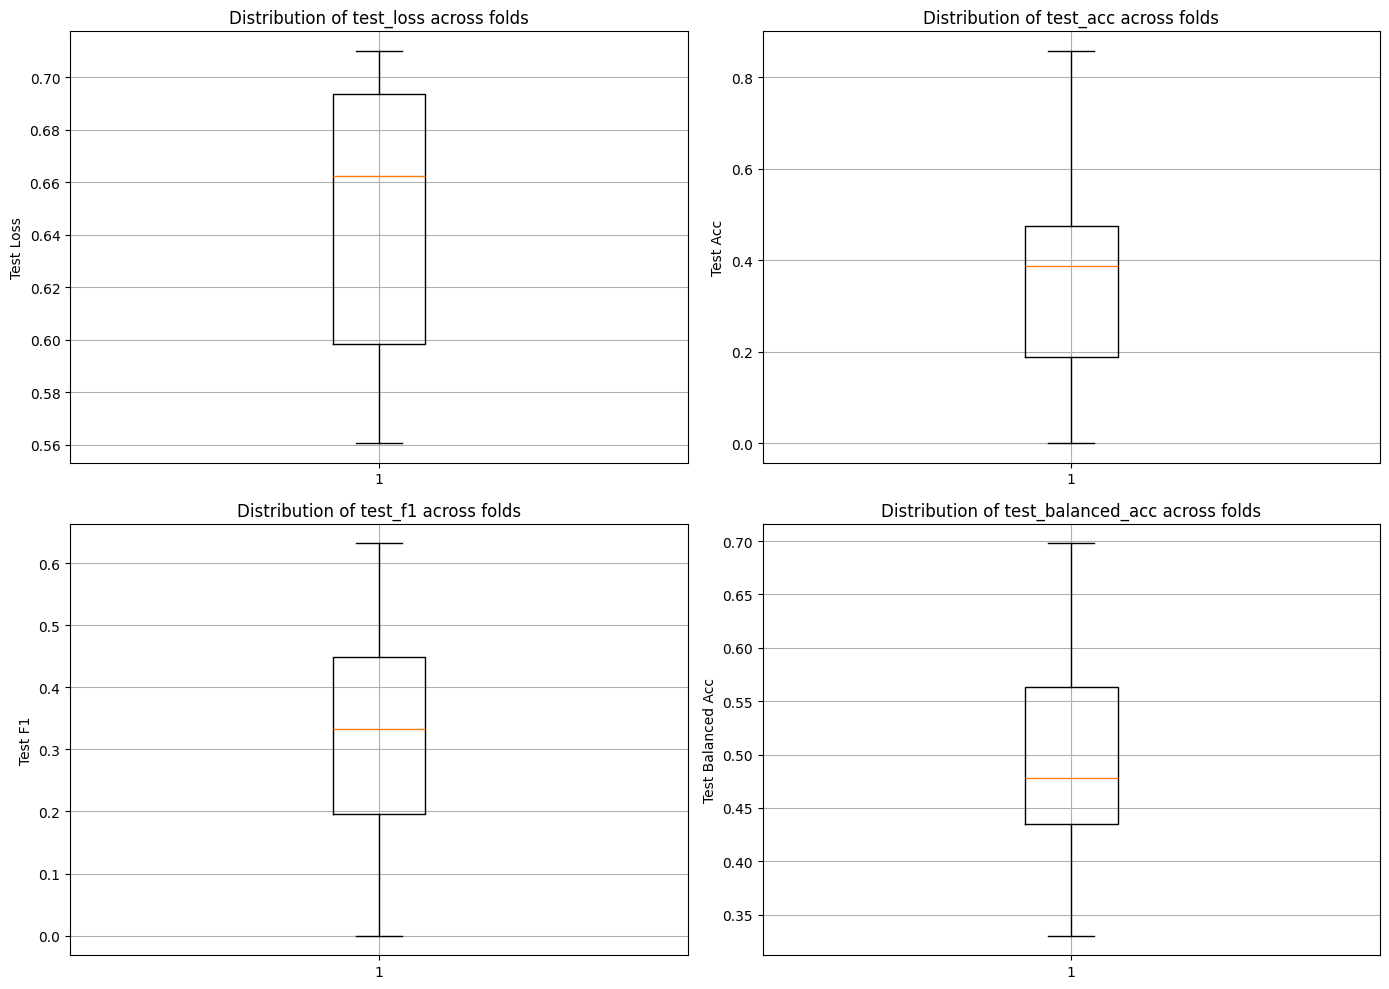

In [65]:
from utils.mlflow_functions import log_SSL_run_to_mlflow

encoder_type = "mae"  # or "moco" if using MoCo
log_SSL_run_to_mlflow(
    environmentFlags=environment_flags,
    cfg=cfg,
    model=model_factory(0.001),  # Pass a dummy model to log the run
    class_names=class_names,
    fold_results=fold_results,
    per_fold_metrics=per_fold_metrics,
    hold_out_cv=True,
    test_transforms=test_transforms,
    all_images_paths_np=images_paths_np,
    all_labels_np=labels_np,
    test_images_paths_np=test_images_paths_np,
    test_true_labels_np=test_true_labels_np,
    yaml_path=yaml_path,
    color_transforms=color_transforms,
    model_library=model_library,
    encoder_type= encoder_type,
    pretrained_backbone_path = MAE_BACKBONE_PATH,
    ssl=True,
)

MLflow UI will start on http://127.0.0.1:5000
Open this URL in web browser

to kill all mlflow processes in case of bugs: 
> ps aux | grep mlflow


> pkill -f mlflow

## T-SNE EVALUATION

In [ ]:
import torch
import torch.nn as nn
from monai.networks.nets import DenseNet121
from utils.mlflow_functions import get_tracking_uri, load_mlflow_model

# Define your feature extractor as before
class FeatureExtractorWrapper(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Extract intermediate convolutional features from your model.
        # This depends on the model's architecture. For MONAI's DenseNet121,
        # the features are available via `model.features(x)`.
        features = self.model.features(x)
        # Apply global average pooling to reduce the spatial dimensions.
        pooled = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        # Flatten to (B, C)
        feature_vector = pooled.view(pooled.size(0), -1)
        return feature_vector

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)  # Replace with your tracking URI
experiment_name = f"{class0_name}_vs_{class1_name}_classifier"
model = load_mlflow_model(tracking_uri, experiment_name, gdrive,kaggle,linux)

feature_extractor = FeatureExtractorWrapper(model).to(device)
features_list = extract_images_features(image_paths, feature_extractor, transforms)
## 2D t-sne
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=cfg.data_splitting["random_seed"])
features_tsne = tsne.fit_transform(features_pca)  # or features if skipping PCA
print("t-SNE result shape:", features_tsne.shape)

# Define color mapping
color_map = {0: 'red', 1: 'blue'}
true_point_colors = [color_map[label] for label in labels]

# Create figure and plot scatter
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=true_point_colors, alpha=0.7)

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=class0_name if label == 0 else class1_name,
                            markersize=10)
                  for label, color in color_map.items()]
plt.legend(handles=legend_elements)

plt.title("t-SNE Visualization of Image Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
## 3D t-sne
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, max_iter=1000, random_state=cfg.data_splitting["random_seed"])
features_tsne = tsne.fit_transform(features_pca)  # or features if skipping PCA
print("t-SNE result shape:", features_tsne.shape)
# Suppose features_tsne is of shape (N, 3) and labels is an array of 0s and 1s.
# Define your custom colors for each label:
color_map = {0: 'red', 1: 'blue'}

# Map each label to its corresponding color.
true_point_colors = [color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_tsne[:, 0],
                     features_tsne[:, 1],
                     features_tsne[:, 2],
                     c=true_point_colors,
                     alpha=0.7)

# Create custom legend handles.
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=class0_name if label == 0 else class1_name,
                            markersize=10)
                  for label, color in color_map.items()]
ax.legend(handles=legend_elements, title="Labels")
# 
ax.set_title("3D t-SNE Visualization of Image Features")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
plt.show()
## INTERACTIVE 3D t-sne
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
from utils.data_visualization_functions import visualize_tiff

# Create a DataFrame that holds your metadata.
df = pd.DataFrame({
    'x': features_tsne[:, 0],
    'y': features_tsne[:, 1],
    'z': features_tsne[:, 2],
    'label': labels,
    'image_path': image_paths,  # full paths or names for your images
})

# Define a discrete color mapping for your classes.
color_map = {0: 'red', 1: 'blue'}
true_point_colors = [color_map[label] for label in df['label']]

# Create an interactive 3D scatter plot using Plotly FigureWidget.
fig = go.FigureWidget(data=[go.Scatter3d(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    mode='markers',
    marker=dict(
        size=5,
        color=true_point_colors  # manually assign colors for discrete labels
    ),
    # Save the image path in customdata to access in the callback.
    customdata=df['image_path'],
    # Set a hovertemplate to show the image path on hover.
    hovertemplate="Image: %{customdata}<extra></extra>"
)])
fig.update_layout(
    title='Interactive 3D t-SNE Visualization',
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    width=1000,  # Set the width (in pixels)
    height=1000
)

# Create an Output widget to display messages and images.
output = widgets.Output()
display(output)

# Define the click callback function using the Output widget.
def click_fn(trace, points, state):
    if points.point_inds:
        idx = points.point_inds[0]
        image_path = trace.customdata[idx]
        with output:
            output.clear_output(wait=True)
            print("Clicked on image:", image_path)
            try:
                visualize_tiff(image_path)
            except Exception as e:
                print("Error displaying image:", e)

# Attach the callback to the scatter trace.
fig.data[0].on_click(click_fn)

# Display the interactive figure.
fig
## K MEAN CLUSTERING
from utils.clustering_functions import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
print("Features shape before K-Means:", features_list.shape)
# Optionally, you could also cluster on PCA-reduced features,
# but here we cluster on the original features.
n_clusters = 4# Change if needed.
# features_list = PCA(n_components=5).fit_transform(features_list)
raw_cluster_labels, predicted_labels, cluster_to_class_dict = perform_clustering(features_list, true_labels, n_clusters, class0_name, class1_name)

#plot_clusters_2d(features_list, true_labels, raw_cluster_labels, predicted_labels, cluster_to_class_dict, class0_name, class1_name)  

plot_clusters_2dx(features_list, true_labels, raw_cluster_labels, predicted_labels, class0_name, class1_name)
# -------------------------------
# Step 5: Print per-cluster info and misclassifications
# -------------------------------
# Optionally, print the number of images in each cluster by true label.
print("Cluster statistics:")
for cl in np.unique(raw_cluster_labels):
    indices = np.where(raw_cluster_labels == cl)[0]
    cluster_true = [true_labels[i] for i in indices]
    predicted_class = cluster_to_class_dict[cl]
    print(f"\nCluster {cl}: Predicted as class {predicted_class} ({class0_name if predicted_class==0 else class1_name})")
    for label in np.unique(cluster_true):
        count = sum(1 for x in cluster_true if x == label)
        print(f"  True label {label} ({class0_name if label==0 else class1_name}): {count} images")
        
evaluate_cluster(true_labels, raw_cluster_labels,class0_name,class1_name)
# Create a figure with two side-by-side subplots
fig = plt.figure(figsize=(20, 8))

# First subplot - Without K-means clusters (now first)
ax1 = fig.add_subplot(121, projection='3d')
correct_color_map = {0: "blue", 1: "red"}
true_point_colors = [correct_color_map[label] for label in labels]
pca_3d = PCA(n_components=3, random_state=42)
features_pca3d = pca_3d.fit_transform(features_pca)
sc1 = ax1.scatter(features_pca3d[:, 0],
                 features_pca3d[:, 1],
                 features_pca3d[:, 2],
                 c=true_point_colors, alpha=0.7)
ax1.set_title("PCA 3D Visualization Without K-Means Clusters")
ax1.set_xlabel("PCA Dimension 1")
ax1.set_ylabel("PCA Dimension 2")
ax1.set_zlabel("PCA Dimension 3")

# Second subplot - With K-means clusters (now second)
ax2 = fig.add_subplot(122, projection='3d')
final_point_colors = [get_color(t, p) for t, p in zip(true_labels, predicted_labels)]
sc2 = ax2.scatter(features_pca3d[:, 0],
                 features_pca3d[:, 1],
                 features_pca3d[:, 2],
                 c=final_point_colors, alpha=0.7)
ax2.set_title("PCA 3D Visualization with K-Means Clusters")
ax2.set_xlabel("PCA Dimension 1")
ax2.set_ylabel("PCA Dimension 2")
ax2.set_zlabel("PCA Dimension 3")

# Create legends (order switched to match plots)
legend_elements1 = [
    Line2D([0], [0], marker='o', color='w', label=f"{class0_name}", markerfacecolor="blue", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class1_name}", markerfacecolor="red", markersize=10),
]

legend_elements2 = [
    Line2D([0], [0], marker='o', color='w', label=f"{class0_name} (correct)", markerfacecolor="blue", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class1_name} (correct)", markerfacecolor="red", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class0_name} misclassified", markerfacecolor="orange", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class1_name} misclassified", markerfacecolor="cyan", markersize=10)
]

ax1.legend(handles=legend_elements1, fontsize='small', markerscale=0.7)
ax2.legend(handles=legend_elements2, fontsize='small', markerscale=0.7)

plt.tight_layout()
plt.show()
#shows each cluster in a different color
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from utils.data_visualization_functions import visualize_tiff

# Create a DataFrame that holds your metadata.
df = pd.DataFrame({
    'x': features_pca3d[:, 0],
    'y': features_pca3d[:, 1],
    'z': features_pca3d[:, 2],
    'label': raw_cluster_labels,
    'image_path': image_paths,  # full paths or names for your images
})

# Define a discrete color mapping for your classes.
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'black'}
true_point_colors = [color_map[label] for label in df['label']]

# Create an interactive 3D scatter plot using Plotly FigureWidget.
fig = go.FigureWidget(data=[go.Scatter3d(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    mode='markers',
    marker=dict(
        size=5,
        color=true_point_colors
    ),
    # Save the image path in customdata to access in the callback.
    customdata=df['image_path'],
    # Set a hovertemplate to show the image path on hover.
    hovertemplate="Image: %{customdata}<extra></extra>"
)])
fig.update_layout(
    title='Interactive 3D t-SNE Visualization',
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    width=1000,  # Set the width (in pixels)
    height=1000
)

# Create an Output widget to display messages and images.
output = widgets.Output()
display(output)

# Define the click callback function using the Output widget.
def click_fn(trace, points, state):
    if points.point_inds:
        idx = points.point_inds[0]
        image_path = trace.customdata[idx]
        with output:
            output.clear_output(wait=True)
            print("Clicked on image:", image_path)
            try:
                visualize_tiff(image_path)
            except Exception as e:
                print("Error displaying image:", e)

# Attach the callback to the scatter trace.
fig.data[0].on_click(click_fn)

# Display the interactive figure.
fig
from utils.clustering_functions import get_cluster_image_names, compute_cluster_mapping

# Get cluster image names
cluster_images = get_cluster_image_names(image_paths, raw_cluster_labels)

# Get cluster to class mapping (majority class for each cluster)
cluster_to_class = compute_cluster_mapping(true_labels, raw_cluster_labels)

# For each cluster, analyze class distribution
for cluster_id, image_names in cluster_images.items():
    # Get color of this cluster
    cluster_color = color_map.get(cluster_id, 'gray')
    
    # Get indices of images in this cluster
    cluster_indices = np.where(raw_cluster_labels == cluster_id)[0]
    
    # Count images of each class in this cluster
    class0_count = np.sum(true_labels[cluster_indices] == 0)
    class1_count = np.sum(true_labels[cluster_indices] == 1)
    
    # Get majority class name
    majority_class = class0_name if cluster_to_class[cluster_id] == 0 else class1_name
    
    # Print summary
    print(f"\nCluster {cluster_id} (Color: {cluster_color}) contains {len(image_names)} images:")
    print(f"  - {class0_name}: {class0_count} images ({class0_count/len(cluster_indices):.1%})")
    print(f"  - {class1_name}: {class1_count} images ({class1_count/len(cluster_indices):.1%})")
    print(f"  - Majority class: {majority_class}")

    num_images_to_print = 5
    # Print a few image names
    print("  - Sample images:")
    for img in image_names[:num_images_to_print]:
        print(f"    * {img}")
    if len(image_names) > num_images_to_print:
        print(f"    * ... and {len(image_names) - num_images_to_print} more")
from IPython.display import display, HTML

for cluster_id, image_names in cluster_images.items():
    # Get color and indices
    cluster_color = color_map.get(cluster_id, 'gray')
    cluster_indices = np.where(raw_cluster_labels == cluster_id)[0]
    
    # Count class distribution
    class0_count = np.sum(true_labels[cluster_indices] == 0)
    class1_count = np.sum(true_labels[cluster_indices] == 1)
    
    # Get majority class
    majority_class = class0_name if cluster_to_class[cluster_id] == 0 else class1_name
    
    # Create HTML output
    color_box = f'<div style="display:inline-block; width:20px; height:20px; background-color:{cluster_color}; margin-right:5px;"></div>'
    
    html = f"{color_box} <b>Cluster {cluster_id}</b> ({len(image_names)} total images)<br>"
    html += f"<ul>"
    html += f"<li><b>{class0_name}:</b> {class0_count} images ({class0_count/len(cluster_indices):.1%})</li>"
    html += f"<li><b>{class1_name}:</b> {class1_count} images ({class1_count/len(cluster_indices):.1%})</li>"
    html += f"<li><b>Majority class:</b> {majority_class}</li>"
    html += "</ul>"
    
    display(HTML(html))
## K MEAN CLASSIFIER
from utils.image_processing_functions import extract_images_features
from sklearn.decomposition import PCA
from monai.transforms import Lambda
from classes.PrintShapeTransform import PrintShapeTransform
# ---------------------
# 4. Feature Extraction from test and train test images
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(
    spatial_dims=2,
    in_channels=3,
    out_channels=2,
    pretrained=True,
).to(device)

# model = load_mlflow_model(tracking_uri, experiment_name, gdrive,kaggle,linux)

feature_extractor = FeatureExtractorWrapper(model).to(device)

from monai.transforms import LoadImaged, EnsureChannelFirstd, LambdaD, Resized, ScaleIntensityd, Compose

transforms = Compose([
    LoadImaged(keys="image", reader="ITKReader"),
    #PrintShapeTransform(keys=["image"], tag="After LoadImaged", print_stats=True),
    EnsureChannelFirstd(keys="image", channel_dim=-1),
    #PrintShapeTransform(keys=["image"], tag="After ensure channel", print_stats=True),
    LambdaD(keys="image", func=lambda x: x[:3, ...]),  # keep only first 3 channels
    #PrintShapeTransform(keys=["image"], tag="After LamdaD", print_stats=True),
    Resized(keys="image", spatial_size=cfg.data_augmentation["resize_spatial_size"]),
    PrintShapeTransform(keys=["image"], tag="After Resized", print_stats=True),
    ScaleIntensityd(keys="image"),
])

train_true_labels = np.array(labels)
# extract test data and labels

# test_dir = os.path.join(data_dir, "TEST")
# #test_dir = os.path.join(data_dir, "MIX1")
# test_images_paths = list(sorted(glob.glob(os.path.join(test_dir, "*.tif"))))
# print(f"class 0:{class0_name} class 1:{class1_name}")

def check_image_shapes(image_paths):
    import tifffile as tiff
    if not image_paths:
        print("No images found.")
        return

    with tiff.TiffFile(image_paths[0]) as tif:
        first_image = tif.asarray()
    
    expected_shape = first_image.shape
    print(f"Expected image shape: {expected_shape}")

    for path in image_paths[1:]:
        with tiff.TiffFile(path) as tif:
            image = tif.asarray()
        
        if image.shape != expected_shape:
            print(f"Shape mismatch: {path} has shape {image.shape}, expected {expected_shape}")
            return
    
    print("All images have the same shape.")

#check_image_shapes(test_images_paths)
# test_msa_ids = [7144,7120,7239,7293]
# test_pd_ids = [7155,7222,7229,7284]

# test_true_labels = [get_label(path,test_msa_ids,test_pd_ids) for path in test_images_paths]
# test_true_labels = np.array(test_true_labels)
print(f"Found {len(balanced_test_images_paths)} test images.")
print(balanced_test_images_paths)
print(test_true_labels)

#extract features from train and test images
train_features_list = extract_images_features(images_paths, feature_extractor, transforms)
test_features_list = extract_images_features(balanced_test_images_paths, feature_extractor, transforms)
print("FINISHED FEATURE EXTRACTION")
print("single feature shape:",test_features_list[0].shape)
print("total features:",len(test_features_list))
# ---------------------
# 5. Dimensionality Reduction with PCA
# ---------------------
pca = PCA(n_components=45) # Reduce the feature vector dimensionality to (N_images, n_components), keep components until they explain 95% or more of variance
train_features_pca = pca.fit_transform(train_features_list)
test_features_pca = pca.transform(test_features_list)
print("Train features shape after PCA:", train_features_pca.shape)
print("Test features shape after PCA:", test_features_pca.shape)
print("FINISHED FEATURE EXTRACTION")
print("Original feature shape:", train_features_list[0].shape)
print("Total features:", len(train_features_list))
print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Explained Variance:", np.cumsum(pca.explained_variance_ratio_))
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

# Define range of clusters to test
min_clusters = 2  # Minimum should be at least the number of classes
max_clusters = 25
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
bal_accs = []

# Loop through each cluster count
for n_clusters in cluster_range:
    print(f"Testing with {n_clusters} clusters...")
    
    # Train K-Means on the training PCA features
    kmeans = KMeans(n_clusters=n_clusters, random_state=cfg.data_splitting["random_seed"])
    train_cluster_labels = kmeans.fit_predict(train_features_pca)
    
    # Map clusters to class labels via majority voting
    train_cluster_mappings = compute_cluster_mapping(train_true_labels, train_cluster_labels)
    
    # Predict cluster assignments for test data
    test_predicted_cluster_labels = kmeans.predict(test_features_pca)
    
    # Map clusters to classes
    predicted_test_labels = np.array([train_cluster_mappings[cl] for cl in test_predicted_cluster_labels])
    
    # Compute metrics
    accuracy = accuracy_score(test_true_labels, predicted_test_labels)
    precision = precision_score(test_true_labels, predicted_test_labels)
    recall = recall_score(test_true_labels, predicted_test_labels)
    f1 = f1_score(test_true_labels, predicted_test_labels)
    bal_acc = balanced_accuracy_score(test_true_labels, predicted_test_labels)
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    bal_accs.append(bal_acc)
    
    print(f"Clusters: {n_clusters}, Accuracy: {accuracy:.3f}, F1: {f1:.3f}")

# Plot results
plt.figure(figsize=(12, 8))
# plt.plot(cluster_range, accuracies, 'o-', label='Accuracy')
# plt.plot(cluster_range, precisions, 'o-', label='Precision')
# plt.plot(cluster_range, recalls, 'o-', label='Recall')
plt.plot(cluster_range, f1_scores, 'o-', label='F1 Score')
plt.plot(cluster_range, bal_accs, 'o-', label='Balanced Accuracy')

plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Classification Performance vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Find best number of clusters based on F1 score
best_cluster_count = cluster_range[np.argmax(f1_scores)]
print(f"Best number of clusters: {best_cluster_count} with F1 score: {max(f1_scores):.3f}")

# Visualize results with best cluster count
best_kmeans = KMeans(n_clusters=best_cluster_count, random_state=cfg.data_splitting["random_seed"])
raw_cluster_labels = best_kmeans.fit_predict(train_features_pca)
train_cluster_mappings = compute_cluster_mapping(train_true_labels, raw_cluster_labels)
predicted_labels = np.array([train_cluster_mappings[cl] for cl in raw_cluster_labels])

plot_clusters_2dx(train_features_pca, train_true_labels, raw_cluster_labels, predicted_labels, class0_name, class1_name)
#plot_clusters_2dx(test_features_pca, test_true_labels, test_predicted_cluster_labels, predicted_test_labels, class0_name, class1_name)
def plot_clusters_with_test(train_features, train_true_labels, train_cluster_labels, 
                          test_features, test_true_labels,
                          class0_name="Class 0", class1_name="Class 1"):
    """
    Plot clusters from training data and show test data positioning.
    performs PCA to reduce dimensionality to 2D for visualization.
    
    Args:
        train_features: Training feature matrix
        train_true_labels: Training ground truth labels
        train_cluster_labels: Training cluster assignments
        test_features: Test feature matrix
        test_true_labels: Test ground truth labels
        cluster_to_class_mapping: Dictionary mapping cluster IDs to predicted classes
        class0_name: Name for class 0 (default: "Class 0")
        class1_name: Name for class 1 (default: "Class 1")
    """
    # Reduce dimensionality to 2D using PCA
    pca_2d = PCA(n_components=2, random_state=42)
    # Fit PCA on training data and transform both train and test
    train_pca2d = pca_2d.fit_transform(train_features)
    test_pca2d = pca_2d.transform(test_features)
    
    # Create figure and axis
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    
    # Define color schemes
    cluster_colors = ['#FFB3B3', '#B3FFB3', '#B3B3FF', '#FFFFA8']  # Pastel colors for clusters
    label_colors = ['#000000', '#0000FF']  # Black for class 0, Blue for class 1
    
    # Plot cluster backgrounds using convex hull for training data
    from scipy.spatial import ConvexHull
    
    for i, cluster_id in enumerate(np.unique(train_cluster_labels)):
        # Get points belonging to the cluster
        mask = train_cluster_labels == cluster_id
        cluster_points = train_pca2d[mask]
        
        if len(cluster_points) > 2:  # Need at least 3 points for ConvexHull
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            
            # Add padding to hull
            centroid = np.mean(hull_points, axis=0)
            hull_points = hull_points + (hull_points - centroid) * 0.1
            
            plt.fill(hull_points[:, 0], hull_points[:, 1],
                    color=cluster_colors[i % len(cluster_colors)],
                    alpha=0.3,
                    label=f'Cluster {cluster_id} Region')
    
    # Plot training points
    for label in [0, 1]:
        mask = train_true_labels == label
        plt.scatter(train_pca2d[mask, 0], 
                   train_pca2d[mask, 1],
                   c=[label_colors[label]],
                   marker='o',
                   s=80,
                   alpha=0.7,
                   label=f'{class0_name if label == 0 else class1_name} (Train)')
    
    # Plot test points with different markers
    for label in [0, 1]:
        mask = test_true_labels == label
        plt.scatter(test_pca2d[mask, 0],
                   test_pca2d[mask, 1],
                   c=[label_colors[label]],
                   marker='X',
                   s=100,
                   alpha=0.7,
                   label=f'{class0_name if label == 0 else class1_name} (Test)')
    
    # Add arrows from test points to their nearest cluster centroid
    train_centroids = {}
    for cluster_id in np.unique(train_cluster_labels):
        mask = train_cluster_labels == cluster_id
        centroid = np.mean(train_pca2d[mask], axis=0)
        train_centroids[cluster_id] = centroid
    
    # Calculate and plot nearest centroid connections for test points
    from scipy.spatial.distance import cdist
    
    # Calculate distances between test points and cluster centroids
    centroids = np.array(list(train_centroids.values()))
    for i in range(len(test_pca2d)):
        # Find nearest centroid
        distances = cdist([test_pca2d[i]], centroids)
        nearest_idx = np.argmin(distances)
        nearest_centroid = centroids[nearest_idx]
        
        # Draw arrow with low opacity
        plt.arrow(test_pca2d[i, 0], test_pca2d[i, 1],
                 nearest_centroid[0] - test_pca2d[i, 0],
                 nearest_centroid[1] - test_pca2d[i, 1],
                 head_width=0.1, head_length=0.1, fc='gray', ec='gray',
                 alpha=0.2)
    
    # Customize plot
    plt.title("Cluster Visualization with Training and Test Data")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    
    # Add grid with low opacity
    plt.grid(True, alpha=0.2)
    
    # Create legend with better positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
              borderaxespad=0., frameon=True, fancybox=True)
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Usage example:
fig = plot_clusters_with_test(
    train_features=train_features_pca,
    train_true_labels=train_true_labels,
    train_cluster_labels=train_cluster_labels,
    test_features=test_features_pca,
    test_true_labels=test_true_labels,
    class0_name=class0_name,
    class1_name=class1_name
)

plt.show()
def plot_train_test_clusters(train_features: np.ndarray,
                           test_features: np.ndarray,
                           train_labels: np.ndarray,
                           test_labels: np.ndarray,
                           predicted_test_labels: np.ndarray,
                           random_seed: int = 42,
                           class0_name: str = "Class 0",
                           class1_name: str = "Class 1") -> None:
    """
    Visualizes train and test data in 2D using PCA, highlighting the relationship
    between training and test samples and their classifications.

    Args:
        train_features (np.ndarray): Training feature matrix
        test_features (np.ndarray): Test feature matrix
        train_labels (np.ndarray): True labels for training data
        test_labels (np.ndarray): True labels for test data
        predicted_test_labels (np.ndarray): Predicted labels for test data
        random_seed (int): Random seed for PCA
        class0_name (str): Name for class 0
        class1_name (str): Name for class 1
    """
    plt.figure(figsize=(12, 8))

    # Fit PCA on training data only
    pca = PCA(n_components=2, random_state=random_seed)
    train_features_2d = pca.fit_transform(train_features)
    
    # Transform test features using the same PCA
    test_features_2d = pca.transform(test_features)

    # Plot training points
    for label in [0, 1]:
        mask = train_labels == label
        plt.scatter(train_features_2d[mask, 0], 
                   train_features_2d[mask, 1],
                   marker='o',
                   s=100,
                   label=f'{class0_name if label == 0 else class1_name} (Train)',
                   alpha=0.6,
                   color='blue' if label == 0 else 'red')

    # Plot test points - correctly classified
    for label in [0, 1]:
        correct_mask = (test_labels == label) & (predicted_test_labels == label)
        plt.scatter(test_features_2d[correct_mask, 0],
                   test_features_2d[correct_mask, 1],
                   marker='*',
                   s=200,
                   label=f'{class0_name if label == 0 else class1_name} (Test Correct)',
                   alpha=0.8,
                   color='lightblue' if label == 0 else 'pink')

    # Plot misclassified test points
    misclassified = test_labels != predicted_test_labels
    if np.any(misclassified):
        plt.scatter(test_features_2d[misclassified, 0],
                   test_features_2d[misclassified, 1],
                   marker='X',
                   s=200,
                   c='black',
                   label='Misclassified Test',
                   alpha=0.7)

    # Customize plot
    plt.title('Train vs Test Data Distribution (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Optional: Add explained variance ratio
    var_ratio = pca.explained_variance_ratio_
    plt.xlabel(f'First Principal Component ({var_ratio[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component ({var_ratio[1]:.1%} variance)')
    
    plt.tight_layout()
    plt.show()

print("Visualizing Train vs Test Clusters:")
print("Train features shape:", train_features_pca.shape)
print("Test features shape:", test_features_pca.shape)
print("Train labels shape:", train_true_labels.shape)
print("Test labels shape:", test_true_labels.shape)
print("Predicted test labels shape:", predicted_test_labels.shape)
   
plot_train_test_clusters(
    train_features=train_features_pca,
    test_features=test_features_pca,
    train_labels=train_true_labels,
    test_labels=test_true_labels,
    predicted_test_labels=predicted_test_labels,
    random_seed=cfg.data_splitting["random_seed"],
    class0_name=class0_name,
    class1_name=class1_name,
)

In [ ]:
# code for conversion from tif to png

import os
import glob
from PIL import Image

def convert_tiff_to_png(input_dir, output_dir):
    """
    Converts all .tif/.tiff images in `input_dir` into 3-channel PNGs,
    saving them to `output_dir`.

    Args:
        input_dir (str): Path to the folder containing TIFF images.
        output_dir (str): Path to the folder where PNGs will be saved.
    """

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Look for .tif or .tiff files
    tiff_paths = glob.glob(os.path.join(input_dir, "*.tif"))
    tiff_paths.extend(glob.glob(os.path.join(input_dir, "*.tiff")))

    for path in tiff_paths:
        # Load with PIL
        with Image.open(path) as im:
            # If not already "RGB" mode, convert
            if im.mode != "RGB":
                im = im.convert("RGB")

            # Build output path
            base_name = os.path.splitext(os.path.basename(path))[0]
            png_path = os.path.join(output_dir, base_name + ".png")

            # Save as PNG
            im.save(png_path, format="PNG")

if __name__ == "__main__":
    # Example usage:
    input_dir = "/home/zano/Documents/TESI/3c_version/ALL_IMAGES"
    output_dir = "/home/zano/Documents/TESI/3c_version/ALL_IMAGES/PNG"
    convert_tiff_to_png(input_dir, output_dir)
    print("Conversion complete!")

Conversion complete!


MOSSE: MAX_6657, 6773 gh, 7105 gh, 7144 gh, 7185 gh, 7191 gh n2(why so intense??), 7293 gh, 6337 gh, 6599 gh, 6657 gh2 

ALL GREEN: 6427 gh